In [ ]:
# conda activate cGAN


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
# from google.colab import drive

import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate


# drive.mount('/content/drive')

# os.chdir("/content/drive/MyDrive/colab/cGAN")
# print(os.getcwd())

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
trainX = np.load('trainX_color.npy')  
trainY = np.load('trainY_color.npy')

# shuffle
idx = np.arange(trainX.shape[0])
np.random.shuffle(idx)
trainX = trainX[idx]
trainY = trainY[idx]

print('trainX: ', trainX.shape)
print('trainY: ', trainY.shape)
print(trainX.dtype)

trainX:  (61827, 64, 64, 3)
trainY:  (61827,)
uint8


In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=14):
	in_label = Input(shape=(1,))  # label input
	li = Embedding(n_classes, 50)(in_label)  # embedding for categorical input
	n_nodes = in_shape[0] * in_shape[1]   # scale up to image dimensions with linear activation
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  # reshape to additional channel

	in_image = Input(shape=in_shape)   # image input
	
	merge = Concatenate()([in_image, li])   # concat label as a channel
	
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)  # downsample (32x32)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)  # downsample  (16x16)
	fe = LeakyReLU(alpha=0.2)(fe)

	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)  # downsample  (8x8)
	fe = LeakyReLU(alpha=0.2)(fe)
 
	fe = Flatten()(fe)   # flatten feature maps
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)  # output
	model = Model([in_image, in_label], out_layer)  # define model
	opt = Adam(lr=0.0002, beta_1=0.5)  # compile model
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


# define the standalone generator model
def define_generator(latent_dim, n_classes=14):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen)
	
	# merge image gen and label input
	merge = Concatenate()([gen, li])
 
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 64x64
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load fashion mnist images
def load_real_samples():
  trainX = np.load('trainX_color.npy')  
  trainY = np.load('trainY_color.npy')

  # shuffle
  idx = np.arange(trainX.shape[0])
  np.random.shuffle(idx)
  trainX = trainX[idx]
  trainY = trainY[idx]
  
  trainX = trainX.astype('float32')
  trainX = (trainX - 127.5) / 127.5
  return [trainX, trainY]
  # (trainX, trainy), (_, _) = load_data()  # load dataset
	# X = expand_dims(trainX, axis=-1)  # expand to 3d, e.g. add channels
	# X = X.astype('float32') # convert from ints to floats
	# X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1]

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	images, labels = dataset  # split into images and labels
	ix = randint(0, images.shape[0], n_samples)  # choose random instances
	X, labels = images[ix], labels[ix]  # select images and labels
	y = ones((n_samples, 1))  # generate class labels
	return [X, labels], y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=14):
	x_input = randn(latent_dim * n_samples)  # generate points in the latent space
	z_input = x_input.reshape(n_samples, latent_dim)  # reshape into a batch of inputs for the network
	labels = randint(0, n_classes, n_samples)  # generate labels
	return [z_input, labels]


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)  # generate points in latent space
	images = generator.predict([z_input, labels_input])  # predict outputs
	y = zeros((n_samples, 1))  # create class labels
	return [images, labels_input], y  

In [ ]:
# train the generator and discriminator
# def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')


In [ ]:
latent_dim = 140  # size of the latent space
d_model = define_discriminator()  # create the discriminator
g_model = define_generator(latent_dim)  # create the generator
gan_model = define_gan(g_model, d_model)  # create the gan
dataset = load_real_samples()  # load image data


C:\Users\nlx14\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim)  # train model

>1, 1/483, d1=0.672, d2=0.695 g=0.692
>1, 2/483, d1=0.518, d2=0.697 g=0.690
>1, 3/483, d1=0.391, d2=0.700 g=0.687
>1, 4/483, d1=0.270, d2=0.706 g=0.683
>1, 5/483, d1=0.179, d2=0.715 g=0.676
>1, 6/483, d1=0.108, d2=0.729 g=0.671
>1, 7/483, d1=0.058, d2=0.732 g=0.675
>1, 8/483, d1=0.045, d2=0.725 g=0.695
>1, 9/483, d1=0.030, d2=0.719 g=0.720
>1, 10/483, d1=0.025, d2=0.727 g=0.735
>1, 11/483, d1=0.021, d2=0.729 g=0.754
>1, 12/483, d1=0.026, d2=0.691 g=0.787
>1, 13/483, d1=0.037, d2=0.637 g=0.832
>1, 14/483, d1=0.043, d2=0.607 g=0.853
>1, 15/483, d1=0.042, d2=0.599 g=0.834
>1, 16/483, d1=0.049, d2=0.610 g=0.804
>1, 17/483, d1=0.019, d2=0.616 g=0.793
>1, 18/483, d1=0.015, d2=0.622 g=0.784
>1, 19/483, d1=0.012, d2=0.627 g=0.777
>1, 20/483, d1=0.013, d2=0.642 g=0.766
>1, 21/483, d1=0.008, d2=0.690 g=0.737
>1, 22/483, d1=0.008, d2=0.780 g=0.674
>1, 23/483, d1=0.007, d2=0.863 g=0.649
>1, 24/483, d1=0.013, d2=0.802 g=0.744
>1, 25/483, d1=0.009, d2=0.579 g=1.071
>1, 26/483, d1=0.008, d2=0.422 g=1

>1, 209/483, d1=0.234, d2=0.242 g=3.088
>1, 210/483, d1=0.282, d2=0.615 g=2.494
>1, 211/483, d1=0.430, d2=0.797 g=2.315
>1, 212/483, d1=0.770, d2=0.443 g=2.999
>1, 213/483, d1=0.655, d2=0.197 g=3.023
>1, 214/483, d1=0.418, d2=0.283 g=3.073
>1, 215/483, d1=0.261, d2=0.339 g=2.688
>1, 216/483, d1=0.427, d2=0.783 g=2.143
>1, 217/483, d1=0.750, d2=0.825 g=1.563
>1, 218/483, d1=0.745, d2=0.630 g=1.696
>1, 219/483, d1=0.397, d2=0.353 g=2.168
>1, 220/483, d1=0.424, d2=0.431 g=1.970
>1, 221/483, d1=0.437, d2=0.556 g=1.674
>1, 222/483, d1=0.512, d2=0.681 g=1.685
>1, 223/483, d1=0.544, d2=0.524 g=1.644
>1, 224/483, d1=0.435, d2=0.450 g=1.837
>1, 225/483, d1=0.661, d2=0.459 g=1.995
>1, 226/483, d1=0.607, d2=0.393 g=1.969
>1, 227/483, d1=0.523, d2=0.480 g=2.143
>1, 228/483, d1=0.501, d2=0.573 g=1.959
>1, 229/483, d1=0.537, d2=0.594 g=1.692
>1, 230/483, d1=0.600, d2=0.394 g=1.622
>1, 231/483, d1=0.558, d2=0.573 g=1.545
>1, 232/483, d1=0.341, d2=0.455 g=1.830
>1, 233/483, d1=0.465, d2=0.483 g=1.707


>1, 414/483, d1=0.407, d2=0.604 g=1.489
>1, 415/483, d1=0.424, d2=0.430 g=1.652
>1, 416/483, d1=0.499, d2=0.509 g=1.767
>1, 417/483, d1=0.318, d2=0.482 g=2.069
>1, 418/483, d1=0.349, d2=0.375 g=2.514
>1, 419/483, d1=0.362, d2=0.299 g=2.485
>1, 420/483, d1=0.277, d2=0.305 g=2.606
>1, 421/483, d1=0.386, d2=0.273 g=2.598
>1, 422/483, d1=0.316, d2=0.387 g=2.081
>1, 423/483, d1=0.295, d2=0.571 g=2.089
>1, 424/483, d1=0.325, d2=0.556 g=1.860
>1, 425/483, d1=0.366, d2=0.579 g=2.048
>1, 426/483, d1=0.443, d2=0.662 g=1.940
>1, 427/483, d1=0.507, d2=0.549 g=1.733
>1, 428/483, d1=0.534, d2=0.825 g=1.766
>1, 429/483, d1=0.452, d2=0.783 g=1.797
>1, 430/483, d1=0.511, d2=0.879 g=1.749
>1, 431/483, d1=0.807, d2=0.679 g=1.936
>1, 432/483, d1=0.584, d2=0.489 g=2.414
>1, 433/483, d1=0.611, d2=0.264 g=2.564
>1, 434/483, d1=0.534, d2=0.210 g=2.538
>1, 435/483, d1=0.495, d2=0.367 g=2.291
>1, 436/483, d1=0.387, d2=0.282 g=1.981
>1, 437/483, d1=0.292, d2=0.306 g=2.163
>1, 438/483, d1=0.372, d2=0.392 g=2.148


>2, 139/483, d1=0.347, d2=0.488 g=1.804
>2, 140/483, d1=0.333, d2=0.588 g=2.156
>2, 141/483, d1=0.476, d2=0.464 g=2.155
>2, 142/483, d1=0.418, d2=0.624 g=2.122
>2, 143/483, d1=0.419, d2=0.501 g=2.024
>2, 144/483, d1=0.479, d2=0.501 g=2.062
>2, 145/483, d1=0.539, d2=0.450 g=2.074
>2, 146/483, d1=0.402, d2=0.507 g=2.224
>2, 147/483, d1=0.384, d2=0.390 g=2.166
>2, 148/483, d1=0.456, d2=0.313 g=2.244
>2, 149/483, d1=0.446, d2=0.282 g=2.148
>2, 150/483, d1=0.389, d2=0.442 g=2.332
>2, 151/483, d1=0.363, d2=0.392 g=2.211
>2, 152/483, d1=0.340, d2=0.413 g=2.410
>2, 153/483, d1=0.489, d2=0.388 g=2.427
>2, 154/483, d1=0.429, d2=0.388 g=2.214
>2, 155/483, d1=0.622, d2=0.436 g=1.842
>2, 156/483, d1=0.488, d2=0.506 g=2.088
>2, 157/483, d1=0.417, d2=0.432 g=2.336
>2, 158/483, d1=0.418, d2=0.234 g=2.253
>2, 159/483, d1=0.413, d2=0.376 g=2.290
>2, 160/483, d1=0.279, d2=0.327 g=2.514
>2, 161/483, d1=0.373, d2=0.256 g=2.724
>2, 162/483, d1=0.297, d2=0.194 g=3.139
>2, 163/483, d1=0.339, d2=0.163 g=3.297


>2, 344/483, d1=0.397, d2=0.483 g=1.761
>2, 345/483, d1=0.363, d2=0.862 g=1.935
>2, 346/483, d1=0.618, d2=0.546 g=1.963
>2, 347/483, d1=0.503, d2=0.306 g=2.608
>2, 348/483, d1=0.500, d2=0.342 g=2.929
>2, 349/483, d1=0.377, d2=0.195 g=3.205
>2, 350/483, d1=0.349, d2=0.226 g=2.661
>2, 351/483, d1=0.280, d2=0.353 g=2.237
>2, 352/483, d1=0.268, d2=0.372 g=2.175
>2, 353/483, d1=0.318, d2=0.383 g=2.503
>2, 354/483, d1=0.489, d2=0.329 g=2.257
>2, 355/483, d1=0.353, d2=0.300 g=2.214
>2, 356/483, d1=0.470, d2=0.288 g=2.119
>2, 357/483, d1=0.388, d2=0.376 g=2.075
>2, 358/483, d1=0.305, d2=0.384 g=2.044
>2, 359/483, d1=0.306, d2=0.395 g=1.876
>2, 360/483, d1=0.347, d2=0.443 g=1.992
>2, 361/483, d1=0.348, d2=0.488 g=2.175
>2, 362/483, d1=0.362, d2=0.424 g=2.254
>2, 363/483, d1=0.447, d2=0.334 g=2.148
>2, 364/483, d1=0.339, d2=0.335 g=2.262
>2, 365/483, d1=0.279, d2=0.401 g=2.317
>2, 366/483, d1=0.330, d2=0.371 g=2.249
>2, 367/483, d1=0.371, d2=0.477 g=1.947
>2, 368/483, d1=0.331, d2=0.414 g=1.966


>3, 68/483, d1=0.373, d2=0.409 g=2.317
>3, 69/483, d1=0.432, d2=0.455 g=2.113
>3, 70/483, d1=0.391, d2=0.455 g=2.294
>3, 71/483, d1=0.342, d2=0.406 g=2.025
>3, 72/483, d1=0.531, d2=0.501 g=2.138
>3, 73/483, d1=0.357, d2=0.424 g=2.428
>3, 74/483, d1=0.523, d2=0.428 g=2.305
>3, 75/483, d1=0.662, d2=0.492 g=2.076
>3, 76/483, d1=0.593, d2=0.431 g=2.238
>3, 77/483, d1=0.423, d2=0.511 g=2.154
>3, 78/483, d1=0.555, d2=0.560 g=2.162
>3, 79/483, d1=0.596, d2=0.430 g=2.201
>3, 80/483, d1=0.491, d2=0.481 g=2.582
>3, 81/483, d1=0.432, d2=0.345 g=2.198
>3, 82/483, d1=0.467, d2=0.381 g=2.458
>3, 83/483, d1=0.306, d2=0.567 g=2.372
>3, 84/483, d1=0.421, d2=0.460 g=2.356
>3, 85/483, d1=0.481, d2=0.454 g=2.215
>3, 86/483, d1=0.523, d2=0.463 g=2.146
>3, 87/483, d1=0.434, d2=0.410 g=2.206
>3, 88/483, d1=0.544, d2=0.423 g=1.929
>3, 89/483, d1=0.474, d2=0.475 g=1.685
>3, 90/483, d1=0.460, d2=0.537 g=1.832
>3, 91/483, d1=0.411, d2=0.534 g=2.168
>3, 92/483, d1=0.315, d2=0.512 g=2.279
>3, 93/483, d1=0.648, d2=

>3, 274/483, d1=0.425, d2=0.507 g=1.990
>3, 275/483, d1=0.469, d2=0.473 g=1.993
>3, 276/483, d1=0.371, d2=0.356 g=2.062
>3, 277/483, d1=0.474, d2=0.441 g=1.795
>3, 278/483, d1=0.491, d2=0.421 g=1.834
>3, 279/483, d1=0.408, d2=0.495 g=1.778
>3, 280/483, d1=0.463, d2=0.421 g=1.703
>3, 281/483, d1=0.436, d2=0.394 g=1.823
>3, 282/483, d1=0.433, d2=0.351 g=2.076
>3, 283/483, d1=0.309, d2=0.393 g=2.155
>3, 284/483, d1=0.335, d2=0.319 g=2.220
>3, 285/483, d1=0.385, d2=0.388 g=1.980
>3, 286/483, d1=0.426, d2=0.462 g=1.886
>3, 287/483, d1=0.421, d2=0.405 g=1.932
>3, 288/483, d1=0.361, d2=0.380 g=1.991
>3, 289/483, d1=0.386, d2=0.447 g=1.935
>3, 290/483, d1=0.268, d2=0.349 g=2.137
>3, 291/483, d1=0.501, d2=0.318 g=1.902
>3, 292/483, d1=0.386, d2=0.421 g=1.955
>3, 293/483, d1=0.344, d2=0.418 g=2.052
>3, 294/483, d1=0.359, d2=0.508 g=2.173
>3, 295/483, d1=0.365, d2=0.364 g=2.273
>3, 296/483, d1=0.584, d2=0.417 g=1.862
>3, 297/483, d1=0.413, d2=0.467 g=1.951
>3, 298/483, d1=0.371, d2=0.359 g=2.053


>3, 479/483, d1=0.387, d2=0.431 g=2.266
>3, 480/483, d1=0.348, d2=0.370 g=2.185
>3, 481/483, d1=0.414, d2=0.432 g=2.249
>3, 482/483, d1=0.445, d2=0.392 g=2.235
>3, 483/483, d1=0.467, d2=0.426 g=2.620
>4, 1/483, d1=0.297, d2=0.429 g=2.353
>4, 2/483, d1=0.379, d2=0.351 g=2.492
>4, 3/483, d1=0.560, d2=0.438 g=2.442
>4, 4/483, d1=0.448, d2=0.447 g=2.236
>4, 5/483, d1=0.366, d2=0.254 g=2.204
>4, 6/483, d1=0.438, d2=0.450 g=2.162
>4, 7/483, d1=0.436, d2=0.352 g=2.080
>4, 8/483, d1=0.390, d2=0.404 g=2.128
>4, 9/483, d1=0.298, d2=0.355 g=2.141
>4, 10/483, d1=0.551, d2=0.387 g=1.906
>4, 11/483, d1=0.350, d2=0.462 g=2.320
>4, 12/483, d1=0.433, d2=0.328 g=2.624
>4, 13/483, d1=0.415, d2=0.362 g=2.490
>4, 14/483, d1=0.350, d2=0.308 g=2.281
>4, 15/483, d1=0.452, d2=0.395 g=2.390
>4, 16/483, d1=0.326, d2=0.374 g=2.443
>4, 17/483, d1=0.448, d2=0.347 g=2.420
>4, 18/483, d1=0.358, d2=0.284 g=2.392
>4, 19/483, d1=0.420, d2=0.442 g=2.260
>4, 20/483, d1=0.408, d2=0.290 g=2.317
>4, 21/483, d1=0.415, d2=0.27

>4, 204/483, d1=0.367, d2=0.311 g=2.635
>4, 205/483, d1=0.328, d2=0.425 g=2.273
>4, 206/483, d1=0.403, d2=0.439 g=2.419
>4, 207/483, d1=0.372, d2=0.568 g=2.289
>4, 208/483, d1=0.394, d2=0.366 g=2.196
>4, 209/483, d1=0.448, d2=0.366 g=2.579
>4, 210/483, d1=0.365, d2=0.343 g=2.396
>4, 211/483, d1=0.383, d2=0.408 g=2.140
>4, 212/483, d1=0.266, d2=0.386 g=2.042
>4, 213/483, d1=0.348, d2=0.339 g=2.093
>4, 214/483, d1=0.323, d2=0.362 g=2.092
>4, 215/483, d1=0.365, d2=0.390 g=2.525
>4, 216/483, d1=0.453, d2=0.440 g=2.525
>4, 217/483, d1=0.374, d2=0.256 g=2.391
>4, 218/483, d1=0.397, d2=0.330 g=2.200
>4, 219/483, d1=0.442, d2=0.470 g=2.061
>4, 220/483, d1=0.425, d2=0.454 g=2.157
>4, 221/483, d1=0.325, d2=0.376 g=2.434
>4, 222/483, d1=0.409, d2=0.443 g=2.352
>4, 223/483, d1=0.397, d2=0.384 g=2.304
>4, 224/483, d1=0.476, d2=0.296 g=2.069
>4, 225/483, d1=0.297, d2=0.513 g=1.982
>4, 226/483, d1=0.478, d2=0.506 g=1.872
>4, 227/483, d1=0.307, d2=0.455 g=2.349
>4, 228/483, d1=0.471, d2=0.373 g=2.254


>4, 409/483, d1=0.353, d2=0.543 g=2.283
>4, 410/483, d1=0.476, d2=0.299 g=2.083
>4, 411/483, d1=0.390, d2=0.312 g=2.325
>4, 412/483, d1=0.367, d2=0.333 g=2.344
>4, 413/483, d1=0.363, d2=0.326 g=2.234
>4, 414/483, d1=0.382, d2=0.529 g=2.392
>4, 415/483, d1=0.342, d2=0.392 g=2.303
>4, 416/483, d1=0.584, d2=0.463 g=2.272
>4, 417/483, d1=0.413, d2=0.436 g=2.511
>4, 418/483, d1=0.404, d2=0.529 g=2.079
>4, 419/483, d1=0.395, d2=0.434 g=2.497
>4, 420/483, d1=0.623, d2=0.441 g=2.478
>4, 421/483, d1=0.524, d2=0.307 g=2.107
>4, 422/483, d1=0.477, d2=0.516 g=2.145
>4, 423/483, d1=0.416, d2=0.361 g=1.967
>4, 424/483, d1=0.400, d2=0.433 g=2.055
>4, 425/483, d1=0.283, d2=0.528 g=2.229
>4, 426/483, d1=0.488, d2=0.358 g=2.194
>4, 427/483, d1=0.441, d2=0.428 g=1.911
>4, 428/483, d1=0.560, d2=0.474 g=1.959
>4, 429/483, d1=0.525, d2=0.340 g=1.867
>4, 430/483, d1=0.375, d2=0.389 g=1.992
>4, 431/483, d1=0.290, d2=0.508 g=2.186
>4, 432/483, d1=0.299, d2=0.379 g=2.440
>4, 433/483, d1=0.446, d2=0.394 g=2.262


>5, 134/483, d1=0.390, d2=0.487 g=2.602
>5, 135/483, d1=0.507, d2=0.421 g=2.517
>5, 136/483, d1=0.503, d2=0.524 g=2.136
>5, 137/483, d1=0.510, d2=0.509 g=2.102
>5, 138/483, d1=0.467, d2=0.670 g=2.197
>5, 139/483, d1=0.719, d2=0.495 g=2.133
>5, 140/483, d1=0.612, d2=0.664 g=2.190
>5, 141/483, d1=0.659, d2=0.460 g=2.379
>5, 142/483, d1=0.576, d2=0.461 g=2.689
>5, 143/483, d1=0.531, d2=0.473 g=2.399
>5, 144/483, d1=0.542, d2=0.557 g=2.333
>5, 145/483, d1=0.594, d2=0.352 g=2.379
>5, 146/483, d1=0.479, d2=0.490 g=2.140
>5, 147/483, d1=0.483, d2=0.457 g=1.934
>5, 148/483, d1=0.399, d2=0.470 g=2.072
>5, 149/483, d1=0.602, d2=0.485 g=1.859
>5, 150/483, d1=0.484, d2=0.590 g=2.036
>5, 151/483, d1=0.531, d2=0.434 g=1.928
>5, 152/483, d1=0.640, d2=0.727 g=2.024
>5, 153/483, d1=0.542, d2=0.452 g=2.066
>5, 154/483, d1=0.536, d2=0.502 g=2.185
>5, 155/483, d1=0.574, d2=0.418 g=1.993
>5, 156/483, d1=0.548, d2=0.512 g=2.004
>5, 157/483, d1=0.501, d2=0.467 g=1.826
>5, 158/483, d1=0.554, d2=0.482 g=1.585


>5, 339/483, d1=0.454, d2=0.337 g=2.334
>5, 340/483, d1=0.459, d2=0.362 g=1.961
>5, 341/483, d1=0.485, d2=0.366 g=2.236
>5, 342/483, d1=0.365, d2=0.344 g=2.350
>5, 343/483, d1=0.378, d2=0.417 g=2.315
>5, 344/483, d1=0.450, d2=0.352 g=2.229
>5, 345/483, d1=0.393, d2=0.359 g=2.106
>5, 346/483, d1=0.384, d2=0.352 g=1.848
>5, 347/483, d1=0.354, d2=0.400 g=2.131
>5, 348/483, d1=0.401, d2=0.338 g=2.143
>5, 349/483, d1=0.345, d2=0.315 g=2.422
>5, 350/483, d1=0.380, d2=0.429 g=2.120
>5, 351/483, d1=0.341, d2=0.404 g=2.126
>5, 352/483, d1=0.395, d2=0.318 g=1.940
>5, 353/483, d1=0.393, d2=0.451 g=1.762
>5, 354/483, d1=0.329, d2=0.485 g=1.940
>5, 355/483, d1=0.397, d2=0.397 g=2.119
>5, 356/483, d1=0.339, d2=0.431 g=2.025
>5, 357/483, d1=0.399, d2=0.389 g=2.283
>5, 358/483, d1=0.411, d2=0.473 g=2.076
>5, 359/483, d1=0.507, d2=0.477 g=2.123
>5, 360/483, d1=0.388, d2=0.465 g=2.325
>5, 361/483, d1=0.573, d2=0.340 g=2.097
>5, 362/483, d1=0.541, d2=0.409 g=2.056
>5, 363/483, d1=0.520, d2=0.561 g=1.988


>6, 63/483, d1=0.443, d2=0.382 g=2.356
>6, 64/483, d1=0.551, d2=0.543 g=1.770
>6, 65/483, d1=0.456, d2=0.476 g=1.939
>6, 66/483, d1=0.387, d2=0.580 g=2.039
>6, 67/483, d1=0.523, d2=0.476 g=2.457
>6, 68/483, d1=0.579, d2=0.358 g=2.266
>6, 69/483, d1=0.565, d2=0.470 g=2.144
>6, 70/483, d1=0.499, d2=0.509 g=2.428
>6, 71/483, d1=0.491, d2=0.326 g=2.620
>6, 72/483, d1=0.464, d2=0.350 g=2.471
>6, 73/483, d1=0.396, d2=0.403 g=2.384
>6, 74/483, d1=0.446, d2=0.330 g=2.312
>6, 75/483, d1=0.511, d2=0.452 g=2.323
>6, 76/483, d1=0.427, d2=0.329 g=2.087
>6, 77/483, d1=0.494, d2=0.392 g=2.222
>6, 78/483, d1=0.473, d2=0.488 g=2.330
>6, 79/483, d1=0.356, d2=0.334 g=2.493
>6, 80/483, d1=0.533, d2=0.365 g=2.128
>6, 81/483, d1=0.467, d2=0.601 g=2.298
>6, 82/483, d1=0.433, d2=0.494 g=2.389
>6, 83/483, d1=0.601, d2=0.312 g=2.245
>6, 84/483, d1=0.471, d2=0.444 g=2.121
>6, 85/483, d1=0.279, d2=0.324 g=2.472
>6, 86/483, d1=0.453, d2=0.399 g=2.523
>6, 87/483, d1=0.366, d2=0.345 g=2.178
>6, 88/483, d1=0.341, d2=

>6, 269/483, d1=0.307, d2=0.417 g=2.412
>6, 270/483, d1=0.488, d2=0.400 g=2.159
>6, 271/483, d1=0.352, d2=0.281 g=2.232
>6, 272/483, d1=0.357, d2=0.499 g=2.436
>6, 273/483, d1=0.395, d2=0.388 g=2.246
>6, 274/483, d1=0.361, d2=0.340 g=2.004
>6, 275/483, d1=0.441, d2=0.324 g=2.027
>6, 276/483, d1=0.303, d2=0.446 g=2.267
>6, 277/483, d1=0.298, d2=0.489 g=2.304
>6, 278/483, d1=0.477, d2=0.453 g=2.026
>6, 279/483, d1=0.359, d2=0.352 g=2.437
>6, 280/483, d1=0.459, d2=0.360 g=2.027
>6, 281/483, d1=0.403, d2=0.506 g=2.043
>6, 282/483, d1=0.385, d2=0.526 g=2.303
>6, 283/483, d1=0.544, d2=0.363 g=2.154
>6, 284/483, d1=0.434, d2=0.458 g=2.223
>6, 285/483, d1=0.512, d2=0.423 g=2.374
>6, 286/483, d1=0.414, d2=0.439 g=2.363
>6, 287/483, d1=0.459, d2=0.366 g=2.358
>6, 288/483, d1=0.390, d2=0.341 g=2.406
>6, 289/483, d1=0.411, d2=0.374 g=2.435
>6, 290/483, d1=0.445, d2=0.373 g=2.206
>6, 291/483, d1=0.428, d2=0.513 g=2.282
>6, 292/483, d1=0.338, d2=0.341 g=2.705
>6, 293/483, d1=0.382, d2=0.377 g=2.536


>6, 474/483, d1=0.457, d2=0.359 g=2.046
>6, 475/483, d1=0.404, d2=0.466 g=2.066
>6, 476/483, d1=0.467, d2=0.314 g=2.102
>6, 477/483, d1=0.359, d2=0.344 g=2.139
>6, 478/483, d1=0.400, d2=0.464 g=2.373
>6, 479/483, d1=0.375, d2=0.309 g=2.427
>6, 480/483, d1=0.464, d2=0.300 g=2.306
>6, 481/483, d1=0.304, d2=0.402 g=2.353
>6, 482/483, d1=0.304, d2=0.306 g=2.601
>6, 483/483, d1=0.489, d2=0.383 g=2.197
>7, 1/483, d1=0.253, d2=0.300 g=2.256
>7, 2/483, d1=0.447, d2=0.381 g=2.050
>7, 3/483, d1=0.370, d2=0.440 g=2.163
>7, 4/483, d1=0.313, d2=0.418 g=2.217
>7, 5/483, d1=0.348, d2=0.303 g=2.214
>7, 6/483, d1=0.467, d2=0.384 g=2.004
>7, 7/483, d1=0.293, d2=0.340 g=2.064
>7, 8/483, d1=0.348, d2=0.472 g=2.074
>7, 9/483, d1=0.391, d2=0.324 g=2.053
>7, 10/483, d1=0.395, d2=0.492 g=2.226
>7, 11/483, d1=0.419, d2=0.375 g=2.409
>7, 12/483, d1=0.365, d2=0.523 g=2.500
>7, 13/483, d1=0.529, d2=0.323 g=2.319
>7, 14/483, d1=0.502, d2=0.420 g=2.100
>7, 15/483, d1=0.481, d2=0.412 g=2.231
>7, 16/483, d1=0.424, d2

>7, 199/483, d1=0.383, d2=0.452 g=2.209
>7, 200/483, d1=0.375, d2=0.384 g=2.478
>7, 201/483, d1=0.342, d2=0.269 g=2.749
>7, 202/483, d1=0.569, d2=0.328 g=2.526
>7, 203/483, d1=0.346, d2=0.388 g=2.255
>7, 204/483, d1=0.384, d2=0.441 g=3.002
>7, 205/483, d1=0.542, d2=0.311 g=2.735
>7, 206/483, d1=0.357, d2=0.385 g=2.442
>7, 207/483, d1=0.320, d2=0.363 g=2.372
>7, 208/483, d1=0.426, d2=0.369 g=1.905
>7, 209/483, d1=0.321, d2=0.551 g=2.166
>7, 210/483, d1=0.338, d2=0.433 g=2.230
>7, 211/483, d1=0.314, d2=0.372 g=2.332
>7, 212/483, d1=0.366, d2=0.312 g=2.358
>7, 213/483, d1=0.416, d2=0.396 g=1.952
>7, 214/483, d1=0.415, d2=0.513 g=2.176
>7, 215/483, d1=0.470, d2=0.622 g=2.573
>7, 216/483, d1=0.489, d2=0.406 g=2.369
>7, 217/483, d1=0.494, d2=0.392 g=2.296
>7, 218/483, d1=0.253, d2=0.373 g=2.482
>7, 219/483, d1=0.387, d2=0.300 g=2.347
>7, 220/483, d1=0.513, d2=0.383 g=2.184
>7, 221/483, d1=0.341, d2=0.465 g=2.242
>7, 222/483, d1=0.482, d2=0.300 g=2.280
>7, 223/483, d1=0.456, d2=0.588 g=2.121


>7, 404/483, d1=0.542, d2=0.423 g=1.987
>7, 405/483, d1=0.541, d2=0.408 g=1.798
>7, 406/483, d1=0.347, d2=0.609 g=2.100
>7, 407/483, d1=0.431, d2=0.284 g=2.494
>7, 408/483, d1=0.443, d2=0.324 g=2.287
>7, 409/483, d1=0.392, d2=0.360 g=2.297
>7, 410/483, d1=0.402, d2=0.433 g=2.009
>7, 411/483, d1=0.373, d2=0.413 g=2.274
>7, 412/483, d1=0.303, d2=0.392 g=2.260
>7, 413/483, d1=0.456, d2=0.371 g=2.455
>7, 414/483, d1=0.319, d2=0.321 g=2.154
>7, 415/483, d1=0.463, d2=0.447 g=2.313
>7, 416/483, d1=0.443, d2=0.464 g=2.260
>7, 417/483, d1=0.313, d2=0.290 g=2.467
>7, 418/483, d1=0.486, d2=0.408 g=2.274
>7, 419/483, d1=0.364, d2=0.366 g=2.507
>7, 420/483, d1=0.506, d2=0.496 g=2.417
>7, 421/483, d1=0.520, d2=0.384 g=2.506
>7, 422/483, d1=0.379, d2=0.335 g=2.478
>7, 423/483, d1=0.312, d2=0.681 g=2.573
>7, 424/483, d1=0.461, d2=0.311 g=2.604
>7, 425/483, d1=0.460, d2=0.485 g=2.599
>7, 426/483, d1=0.458, d2=0.349 g=2.664
>7, 427/483, d1=0.492, d2=0.458 g=2.723
>7, 428/483, d1=0.475, d2=0.421 g=2.757


>8, 129/483, d1=0.486, d2=0.428 g=2.014
>8, 130/483, d1=0.404, d2=0.435 g=1.885
>8, 131/483, d1=0.355, d2=0.418 g=1.862
>8, 132/483, d1=0.375, d2=0.562 g=2.086
>8, 133/483, d1=0.563, d2=0.358 g=2.208
>8, 134/483, d1=0.349, d2=0.509 g=2.330
>8, 135/483, d1=0.465, d2=0.339 g=1.926
>8, 136/483, d1=0.431, d2=0.349 g=1.888
>8, 137/483, d1=0.340, d2=0.447 g=1.818
>8, 138/483, d1=0.453, d2=0.553 g=1.945
>8, 139/483, d1=0.427, d2=0.395 g=2.032
>8, 140/483, d1=0.587, d2=0.588 g=2.043
>8, 141/483, d1=0.452, d2=0.417 g=1.948
>8, 142/483, d1=0.446, d2=0.545 g=2.061
>8, 143/483, d1=0.450, d2=0.492 g=2.457
>8, 144/483, d1=0.649, d2=0.447 g=2.111
>8, 145/483, d1=0.490, d2=0.347 g=1.722
>8, 146/483, d1=0.357, d2=0.598 g=2.117
>8, 147/483, d1=0.488, d2=0.468 g=2.588
>8, 148/483, d1=0.526, d2=0.383 g=2.019
>8, 149/483, d1=0.441, d2=0.392 g=2.083
>8, 150/483, d1=0.428, d2=0.427 g=1.877
>8, 151/483, d1=0.526, d2=0.401 g=1.970
>8, 152/483, d1=0.368, d2=0.713 g=2.149
>8, 153/483, d1=0.532, d2=0.429 g=2.472


>8, 334/483, d1=0.556, d2=0.474 g=1.888
>8, 335/483, d1=0.427, d2=0.481 g=1.802
>8, 336/483, d1=0.494, d2=0.515 g=1.998
>8, 337/483, d1=0.464, d2=0.465 g=1.874
>8, 338/483, d1=0.541, d2=0.548 g=2.330
>8, 339/483, d1=0.443, d2=0.499 g=2.018
>8, 340/483, d1=0.412, d2=0.413 g=2.095
>8, 341/483, d1=0.501, d2=0.523 g=1.972
>8, 342/483, d1=0.586, d2=0.458 g=1.771
>8, 343/483, d1=0.444, d2=0.439 g=2.133
>8, 344/483, d1=0.532, d2=0.615 g=2.073
>8, 345/483, d1=0.451, d2=0.435 g=1.907
>8, 346/483, d1=0.422, d2=0.371 g=2.074
>8, 347/483, d1=0.416, d2=0.482 g=2.019
>8, 348/483, d1=0.442, d2=0.372 g=1.909
>8, 349/483, d1=0.298, d2=0.507 g=1.913
>8, 350/483, d1=0.444, d2=0.451 g=2.139
>8, 351/483, d1=0.551, d2=0.420 g=1.879
>8, 352/483, d1=0.557, d2=0.532 g=2.245
>8, 353/483, d1=0.446, d2=0.512 g=2.567
>8, 354/483, d1=0.456, d2=0.413 g=1.913
>8, 355/483, d1=0.396, d2=0.422 g=1.998
>8, 356/483, d1=0.403, d2=0.432 g=2.463
>8, 357/483, d1=0.425, d2=0.384 g=2.184
>8, 358/483, d1=0.373, d2=0.292 g=2.095


>9, 58/483, d1=0.490, d2=0.500 g=1.976
>9, 59/483, d1=0.475, d2=0.564 g=2.008
>9, 60/483, d1=0.398, d2=0.344 g=2.190
>9, 61/483, d1=0.367, d2=0.300 g=2.103
>9, 62/483, d1=0.577, d2=0.503 g=1.985
>9, 63/483, d1=0.478, d2=0.533 g=2.033
>9, 64/483, d1=0.431, d2=0.455 g=1.942
>9, 65/483, d1=0.478, d2=0.477 g=1.841
>9, 66/483, d1=0.354, d2=0.427 g=2.170
>9, 67/483, d1=0.386, d2=0.353 g=1.904
>9, 68/483, d1=0.460, d2=0.431 g=2.037
>9, 69/483, d1=0.416, d2=0.452 g=2.073
>9, 70/483, d1=0.447, d2=0.402 g=2.067
>9, 71/483, d1=0.476, d2=0.437 g=1.927
>9, 72/483, d1=0.457, d2=0.474 g=1.950
>9, 73/483, d1=0.482, d2=0.397 g=1.904
>9, 74/483, d1=0.487, d2=0.498 g=1.693
>9, 75/483, d1=0.552, d2=0.497 g=1.794
>9, 76/483, d1=0.451, d2=0.543 g=2.083
>9, 77/483, d1=0.399, d2=0.424 g=1.963
>9, 78/483, d1=0.578, d2=0.433 g=1.880
>9, 79/483, d1=0.280, d2=0.543 g=2.294
>9, 80/483, d1=0.515, d2=0.367 g=2.099
>9, 81/483, d1=0.453, d2=0.538 g=1.857
>9, 82/483, d1=0.418, d2=0.592 g=1.971
>9, 83/483, d1=0.509, d2=

>9, 264/483, d1=0.421, d2=0.331 g=2.238
>9, 265/483, d1=0.459, d2=0.350 g=1.818
>9, 266/483, d1=0.575, d2=0.462 g=1.641
>9, 267/483, d1=0.442, d2=0.425 g=1.463
>9, 268/483, d1=0.419, d2=0.534 g=1.754
>9, 269/483, d1=0.293, d2=0.384 g=1.836
>9, 270/483, d1=0.508, d2=0.518 g=1.932
>9, 271/483, d1=0.426, d2=0.498 g=1.775
>9, 272/483, d1=0.413, d2=0.457 g=2.038
>9, 273/483, d1=0.498, d2=0.420 g=1.934
>9, 274/483, d1=0.531, d2=0.398 g=1.664
>9, 275/483, d1=0.384, d2=0.547 g=1.986
>9, 276/483, d1=0.403, d2=0.498 g=1.901
>9, 277/483, d1=0.399, d2=0.418 g=1.953
>9, 278/483, d1=0.391, d2=0.421 g=1.844
>9, 279/483, d1=0.569, d2=0.485 g=1.686
>9, 280/483, d1=0.514, d2=0.460 g=1.835
>9, 281/483, d1=0.507, d2=0.460 g=1.918
>9, 282/483, d1=0.417, d2=0.497 g=1.875
>9, 283/483, d1=0.687, d2=0.473 g=1.648
>9, 284/483, d1=0.484, d2=0.553 g=1.664
>9, 285/483, d1=0.384, d2=0.465 g=2.031
>9, 286/483, d1=0.649, d2=0.421 g=2.116
>9, 287/483, d1=0.456, d2=0.413 g=1.951
>9, 288/483, d1=0.406, d2=0.495 g=1.942


>9, 469/483, d1=0.461, d2=0.445 g=1.942
>9, 470/483, d1=0.382, d2=0.424 g=1.939
>9, 471/483, d1=0.524, d2=0.447 g=1.979
>9, 472/483, d1=0.387, d2=0.484 g=1.964
>9, 473/483, d1=0.496, d2=0.406 g=1.770
>9, 474/483, d1=0.384, d2=0.445 g=1.989
>9, 475/483, d1=0.398, d2=0.342 g=1.869
>9, 476/483, d1=0.592, d2=0.436 g=1.765
>9, 477/483, d1=0.452, d2=0.483 g=1.597
>9, 478/483, d1=0.387, d2=0.431 g=2.030
>9, 479/483, d1=0.531, d2=0.545 g=2.026
>9, 480/483, d1=0.402, d2=0.434 g=1.961
>9, 481/483, d1=0.412, d2=0.419 g=2.168
>9, 482/483, d1=0.381, d2=0.427 g=1.876
>9, 483/483, d1=0.585, d2=0.500 g=1.922
>10, 1/483, d1=0.387, d2=0.433 g=1.950
>10, 2/483, d1=0.537, d2=0.486 g=2.209
>10, 3/483, d1=0.370, d2=0.400 g=1.928
>10, 4/483, d1=0.451, d2=0.563 g=1.859
>10, 5/483, d1=0.398, d2=0.388 g=2.268
>10, 6/483, d1=0.418, d2=0.396 g=2.230
>10, 7/483, d1=0.447, d2=0.421 g=1.897
>10, 8/483, d1=0.511, d2=0.645 g=2.173
>10, 9/483, d1=0.494, d2=0.362 g=2.112
>10, 10/483, d1=0.358, d2=0.431 g=2.163
>10, 11/4

>10, 189/483, d1=0.428, d2=0.460 g=1.778
>10, 190/483, d1=0.435, d2=0.605 g=1.844
>10, 191/483, d1=0.553, d2=0.479 g=2.162
>10, 192/483, d1=0.640, d2=0.491 g=1.998
>10, 193/483, d1=0.484, d2=0.506 g=1.810
>10, 194/483, d1=0.357, d2=0.381 g=1.897
>10, 195/483, d1=0.541, d2=0.370 g=2.209
>10, 196/483, d1=0.393, d2=0.367 g=2.041
>10, 197/483, d1=0.489, d2=0.542 g=1.518
>10, 198/483, d1=0.474, d2=0.761 g=1.992
>10, 199/483, d1=0.382, d2=0.365 g=2.561
>10, 200/483, d1=0.632, d2=0.515 g=1.947
>10, 201/483, d1=0.541, d2=0.496 g=1.759
>10, 202/483, d1=0.364, d2=0.422 g=1.955
>10, 203/483, d1=0.463, d2=0.427 g=2.031
>10, 204/483, d1=0.493, d2=0.608 g=1.873
>10, 205/483, d1=0.486, d2=0.517 g=1.719
>10, 206/483, d1=0.461, d2=0.469 g=1.707
>10, 207/483, d1=0.418, d2=0.600 g=1.902
>10, 208/483, d1=0.281, d2=0.442 g=1.968
>10, 209/483, d1=0.395, d2=0.483 g=1.988
>10, 210/483, d1=0.449, d2=0.400 g=1.977
>10, 211/483, d1=0.577, d2=0.481 g=1.848
>10, 212/483, d1=0.498, d2=0.525 g=1.836
>10, 213/483, d1

>10, 389/483, d1=0.412, d2=0.537 g=1.788
>10, 390/483, d1=0.411, d2=0.420 g=2.098
>10, 391/483, d1=0.406, d2=0.350 g=1.851
>10, 392/483, d1=0.388, d2=0.491 g=2.080
>10, 393/483, d1=0.416, d2=0.461 g=1.806
>10, 394/483, d1=0.429, d2=0.434 g=1.948
>10, 395/483, d1=0.441, d2=0.427 g=1.950
>10, 396/483, d1=0.422, d2=0.417 g=1.739
>10, 397/483, d1=0.576, d2=0.546 g=1.749
>10, 398/483, d1=0.490, d2=0.478 g=1.797
>10, 399/483, d1=0.408, d2=0.507 g=1.954
>10, 400/483, d1=0.581, d2=0.533 g=1.742
>10, 401/483, d1=0.512, d2=0.472 g=1.817
>10, 402/483, d1=0.585, d2=0.498 g=1.641
>10, 403/483, d1=0.496, d2=0.473 g=1.916
>10, 404/483, d1=0.463, d2=0.519 g=1.744
>10, 405/483, d1=0.373, d2=0.404 g=1.855
>10, 406/483, d1=0.493, d2=0.482 g=1.857
>10, 407/483, d1=0.473, d2=0.541 g=1.898
>10, 408/483, d1=0.540, d2=0.464 g=1.959
>10, 409/483, d1=0.446, d2=0.428 g=1.949
>10, 410/483, d1=0.612, d2=0.492 g=1.703
>10, 411/483, d1=0.431, d2=0.483 g=1.856
>10, 412/483, d1=0.447, d2=0.549 g=1.854
>10, 413/483, d1

>11, 109/483, d1=0.602, d2=0.438 g=1.812
>11, 110/483, d1=0.453, d2=0.528 g=1.852
>11, 111/483, d1=0.404, d2=0.368 g=1.858
>11, 112/483, d1=0.404, d2=0.441 g=1.859
>11, 113/483, d1=0.399, d2=0.396 g=1.764
>11, 114/483, d1=0.475, d2=0.429 g=1.847
>11, 115/483, d1=0.432, d2=0.560 g=1.925
>11, 116/483, d1=0.379, d2=0.402 g=2.172
>11, 117/483, d1=0.424, d2=0.454 g=2.047
>11, 118/483, d1=0.533, d2=0.461 g=2.000
>11, 119/483, d1=0.425, d2=0.354 g=2.031
>11, 120/483, d1=0.549, d2=0.432 g=1.646
>11, 121/483, d1=0.374, d2=0.421 g=1.784
>11, 122/483, d1=0.573, d2=0.543 g=1.764
>11, 123/483, d1=0.342, d2=0.393 g=2.056
>11, 124/483, d1=0.502, d2=0.476 g=1.942
>11, 125/483, d1=0.490, d2=0.334 g=1.862
>11, 126/483, d1=0.353, d2=0.502 g=2.031
>11, 127/483, d1=0.462, d2=0.466 g=1.710
>11, 128/483, d1=0.371, d2=0.471 g=1.822
>11, 129/483, d1=0.528, d2=0.454 g=1.826
>11, 130/483, d1=0.377, d2=0.433 g=1.927
>11, 131/483, d1=0.585, d2=0.642 g=2.014
>11, 132/483, d1=0.504, d2=0.456 g=2.276
>11, 133/483, d1

>11, 309/483, d1=0.561, d2=0.474 g=1.853
>11, 310/483, d1=0.553, d2=0.587 g=2.173
>11, 311/483, d1=0.550, d2=0.388 g=2.052
>11, 312/483, d1=0.493, d2=0.561 g=1.924
>11, 313/483, d1=0.484, d2=0.500 g=2.000
>11, 314/483, d1=0.517, d2=0.449 g=1.985
>11, 315/483, d1=0.389, d2=0.367 g=2.173
>11, 316/483, d1=0.426, d2=0.396 g=2.081
>11, 317/483, d1=0.277, d2=0.513 g=2.160
>11, 318/483, d1=0.419, d2=0.424 g=2.071
>11, 319/483, d1=0.557, d2=0.581 g=1.937
>11, 320/483, d1=0.450, d2=0.513 g=2.053
>11, 321/483, d1=0.487, d2=0.350 g=2.007
>11, 322/483, d1=0.569, d2=0.552 g=1.865
>11, 323/483, d1=0.462, d2=0.301 g=1.933
>11, 324/483, d1=0.539, d2=0.396 g=1.590
>11, 325/483, d1=0.490, d2=0.571 g=1.809
>11, 326/483, d1=0.354, d2=0.570 g=1.779
>11, 327/483, d1=0.401, d2=0.364 g=2.162
>11, 328/483, d1=0.339, d2=0.467 g=1.884
>11, 329/483, d1=0.382, d2=0.534 g=2.127
>11, 330/483, d1=0.531, d2=0.476 g=2.039
>11, 331/483, d1=0.381, d2=0.376 g=1.982
>11, 332/483, d1=0.576, d2=0.464 g=1.763
>11, 333/483, d1

>12, 27/483, d1=0.636, d2=0.450 g=1.494
>12, 28/483, d1=0.354, d2=0.590 g=1.717
>12, 29/483, d1=0.504, d2=0.499 g=1.837
>12, 30/483, d1=0.570, d2=0.506 g=1.607
>12, 31/483, d1=0.423, d2=0.475 g=1.643
>12, 32/483, d1=0.545, d2=0.439 g=1.596
>12, 33/483, d1=0.484, d2=0.461 g=1.588
>12, 34/483, d1=0.376, d2=0.450 g=1.852
>12, 35/483, d1=0.416, d2=0.569 g=2.034
>12, 36/483, d1=0.544, d2=0.423 g=1.891
>12, 37/483, d1=0.506, d2=0.302 g=1.752
>12, 38/483, d1=0.419, d2=0.380 g=1.707
>12, 39/483, d1=0.521, d2=0.564 g=1.768
>12, 40/483, d1=0.512, d2=0.494 g=1.764
>12, 41/483, d1=0.487, d2=0.437 g=1.922
>12, 42/483, d1=0.429, d2=0.388 g=1.695
>12, 43/483, d1=0.452, d2=0.406 g=1.646
>12, 44/483, d1=0.329, d2=0.542 g=1.866
>12, 45/483, d1=0.453, d2=0.535 g=1.877
>12, 46/483, d1=0.434, d2=0.503 g=2.135
>12, 47/483, d1=0.479, d2=0.359 g=2.208
>12, 48/483, d1=0.522, d2=0.398 g=2.039
>12, 49/483, d1=0.547, d2=0.416 g=1.632
>12, 50/483, d1=0.600, d2=0.663 g=1.752
>12, 51/483, d1=0.441, d2=0.551 g=1.810


>12, 229/483, d1=0.572, d2=0.535 g=1.625
>12, 230/483, d1=0.471, d2=0.484 g=1.573
>12, 231/483, d1=0.556, d2=0.431 g=1.762
>12, 232/483, d1=0.383, d2=0.545 g=1.814
>12, 233/483, d1=0.390, d2=0.383 g=2.148
>12, 234/483, d1=0.555, d2=0.374 g=1.864
>12, 235/483, d1=0.460, d2=0.488 g=1.828
>12, 236/483, d1=0.619, d2=0.543 g=1.666
>12, 237/483, d1=0.514, d2=0.535 g=1.728
>12, 238/483, d1=0.452, d2=0.409 g=1.850
>12, 239/483, d1=0.462, d2=0.548 g=1.856
>12, 240/483, d1=0.490, d2=0.375 g=1.663
>12, 241/483, d1=0.381, d2=0.455 g=1.678
>12, 242/483, d1=0.526, d2=0.571 g=1.780
>12, 243/483, d1=0.336, d2=0.447 g=1.954
>12, 244/483, d1=0.467, d2=0.447 g=1.752
>12, 245/483, d1=0.429, d2=0.478 g=1.829
>12, 246/483, d1=0.551, d2=0.454 g=1.935
>12, 247/483, d1=0.498, d2=0.471 g=1.869
>12, 248/483, d1=0.467, d2=0.488 g=1.884
>12, 249/483, d1=0.605, d2=0.667 g=1.798
>12, 250/483, d1=0.324, d2=0.515 g=1.972
>12, 251/483, d1=0.480, d2=0.392 g=1.867
>12, 252/483, d1=0.571, d2=0.413 g=1.871
>12, 253/483, d1

>12, 429/483, d1=0.465, d2=0.551 g=1.806
>12, 430/483, d1=0.464, d2=0.486 g=2.035
>12, 431/483, d1=0.490, d2=0.385 g=1.878
>12, 432/483, d1=0.430, d2=0.397 g=1.966
>12, 433/483, d1=0.341, d2=0.434 g=2.046
>12, 434/483, d1=0.495, d2=0.369 g=1.781
>12, 435/483, d1=0.399, d2=0.520 g=2.111
>12, 436/483, d1=0.452, d2=0.471 g=1.953
>12, 437/483, d1=0.481, d2=0.484 g=1.886
>12, 438/483, d1=0.423, d2=0.460 g=1.652
>12, 439/483, d1=0.472, d2=0.399 g=1.906
>12, 440/483, d1=0.564, d2=0.469 g=2.168
>12, 441/483, d1=0.489, d2=0.463 g=1.693
>12, 442/483, d1=0.408, d2=0.407 g=1.808
>12, 443/483, d1=0.502, d2=0.512 g=1.791
>12, 444/483, d1=0.417, d2=0.433 g=1.770
>12, 445/483, d1=0.456, d2=0.392 g=1.951
>12, 446/483, d1=0.460, d2=0.565 g=1.662
>12, 447/483, d1=0.499, d2=0.575 g=1.990
>12, 448/483, d1=0.399, d2=0.463 g=2.084
>12, 449/483, d1=0.401, d2=0.418 g=2.018
>12, 450/483, d1=0.572, d2=0.491 g=1.948
>12, 451/483, d1=0.429, d2=0.279 g=1.932
>12, 452/483, d1=0.548, d2=0.497 g=1.904
>12, 453/483, d1

>13, 149/483, d1=0.517, d2=0.456 g=1.872
>13, 150/483, d1=0.476, d2=0.393 g=1.789
>13, 151/483, d1=0.429, d2=0.515 g=1.670
>13, 152/483, d1=0.514, d2=0.425 g=1.814
>13, 153/483, d1=0.494, d2=0.546 g=1.829
>13, 154/483, d1=0.470, d2=0.446 g=1.764
>13, 155/483, d1=0.522, d2=0.553 g=1.728
>13, 156/483, d1=0.357, d2=0.455 g=2.017
>13, 157/483, d1=0.396, d2=0.560 g=2.005
>13, 158/483, d1=0.518, d2=0.385 g=2.096
>13, 159/483, d1=0.443, d2=0.346 g=1.841
>13, 160/483, d1=0.401, d2=0.469 g=1.787
>13, 161/483, d1=0.335, d2=0.515 g=1.977
>13, 162/483, d1=0.527, d2=0.497 g=1.964
>13, 163/483, d1=0.480, d2=0.493 g=2.068
>13, 164/483, d1=0.590, d2=0.510 g=2.105
>13, 165/483, d1=0.549, d2=0.426 g=1.926
>13, 166/483, d1=0.495, d2=0.393 g=2.075
>13, 167/483, d1=0.505, d2=0.491 g=1.744
>13, 168/483, d1=0.432, d2=0.484 g=1.896
>13, 169/483, d1=0.466, d2=0.585 g=1.947
>13, 170/483, d1=0.416, d2=0.426 g=1.984
>13, 171/483, d1=0.575, d2=0.410 g=1.661
>13, 172/483, d1=0.428, d2=0.450 g=1.804
>13, 173/483, d1

>13, 349/483, d1=0.582, d2=0.423 g=1.923
>13, 350/483, d1=0.439, d2=0.530 g=1.823
>13, 351/483, d1=0.429, d2=0.444 g=2.265
>13, 352/483, d1=0.565, d2=0.445 g=2.173
>13, 353/483, d1=0.409, d2=0.506 g=1.892
>13, 354/483, d1=0.525, d2=0.538 g=1.779
>13, 355/483, d1=0.469, d2=0.402 g=1.853
>13, 356/483, d1=0.478, d2=0.422 g=1.790
>13, 357/483, d1=0.461, d2=0.481 g=1.604
>13, 358/483, d1=0.558, d2=0.629 g=1.742
>13, 359/483, d1=0.511, d2=0.417 g=2.061
>13, 360/483, d1=0.523, d2=0.599 g=1.735
>13, 361/483, d1=0.514, d2=0.507 g=1.911
>13, 362/483, d1=0.420, d2=0.542 g=1.998
>13, 363/483, d1=0.523, d2=0.533 g=1.968
>13, 364/483, d1=0.551, d2=0.406 g=1.965
>13, 365/483, d1=0.464, d2=0.484 g=1.831
>13, 366/483, d1=0.659, d2=0.552 g=1.859
>13, 367/483, d1=0.508, d2=0.676 g=1.796
>13, 368/483, d1=0.505, d2=0.452 g=1.532
>13, 369/483, d1=0.405, d2=0.399 g=1.910
>13, 370/483, d1=0.474, d2=0.413 g=1.863
>13, 371/483, d1=0.573, d2=0.473 g=1.931
>13, 372/483, d1=0.489, d2=0.459 g=1.753
>13, 373/483, d1

>14, 68/483, d1=0.558, d2=0.514 g=1.961
>14, 69/483, d1=0.470, d2=0.542 g=1.909
>14, 70/483, d1=0.583, d2=0.466 g=1.737
>14, 71/483, d1=0.478, d2=0.380 g=1.662
>14, 72/483, d1=0.486, d2=0.509 g=1.927
>14, 73/483, d1=0.380, d2=0.517 g=1.975
>14, 74/483, d1=0.407, d2=0.489 g=1.994
>14, 75/483, d1=0.429, d2=0.518 g=1.834
>14, 76/483, d1=0.493, d2=0.438 g=1.885
>14, 77/483, d1=0.507, d2=0.448 g=1.926
>14, 78/483, d1=0.559, d2=0.558 g=1.827
>14, 79/483, d1=0.531, d2=0.449 g=1.731
>14, 80/483, d1=0.594, d2=0.497 g=1.742
>14, 81/483, d1=0.437, d2=0.529 g=1.889
>14, 82/483, d1=0.623, d2=0.567 g=1.921
>14, 83/483, d1=0.443, d2=0.539 g=1.890
>14, 84/483, d1=0.490, d2=0.495 g=2.032
>14, 85/483, d1=0.424, d2=0.502 g=1.888
>14, 86/483, d1=0.471, d2=0.458 g=1.817
>14, 87/483, d1=0.398, d2=0.468 g=1.794
>14, 88/483, d1=0.609, d2=0.546 g=1.807
>14, 89/483, d1=0.550, d2=0.589 g=1.699
>14, 90/483, d1=0.558, d2=0.591 g=1.971
>14, 91/483, d1=0.494, d2=0.445 g=2.042
>14, 92/483, d1=0.627, d2=0.370 g=1.986


>14, 269/483, d1=0.564, d2=0.440 g=2.006
>14, 270/483, d1=0.519, d2=0.384 g=1.909
>14, 271/483, d1=0.520, d2=0.459 g=1.978
>14, 272/483, d1=0.441, d2=0.512 g=1.867
>14, 273/483, d1=0.455, d2=0.576 g=2.081
>14, 274/483, d1=0.564, d2=0.463 g=1.513
>14, 275/483, d1=0.479, d2=0.490 g=1.667
>14, 276/483, d1=0.382, d2=0.448 g=2.124
>14, 277/483, d1=0.417, d2=0.620 g=2.025
>14, 278/483, d1=0.532, d2=0.370 g=1.921
>14, 279/483, d1=0.452, d2=0.415 g=1.823
>14, 280/483, d1=0.427, d2=0.434 g=1.851
>14, 281/483, d1=0.410, d2=0.447 g=1.973
>14, 282/483, d1=0.498, d2=0.435 g=1.886
>14, 283/483, d1=0.464, d2=0.478 g=1.899
>14, 284/483, d1=0.486, d2=0.619 g=1.878
>14, 285/483, d1=0.504, d2=0.402 g=1.749
>14, 286/483, d1=0.592, d2=0.499 g=1.682
>14, 287/483, d1=0.478, d2=0.544 g=1.726
>14, 288/483, d1=0.496, d2=0.443 g=1.733
>14, 289/483, d1=0.402, d2=0.408 g=1.889
>14, 290/483, d1=0.441, d2=0.432 g=1.681
>14, 291/483, d1=0.459, d2=0.401 g=1.631
>14, 292/483, d1=0.499, d2=0.454 g=1.805
>14, 293/483, d1

>14, 469/483, d1=0.511, d2=0.437 g=1.931
>14, 470/483, d1=0.453, d2=0.396 g=1.948
>14, 471/483, d1=0.488, d2=0.386 g=1.998
>14, 472/483, d1=0.512, d2=0.380 g=1.666
>14, 473/483, d1=0.364, d2=0.493 g=1.750
>14, 474/483, d1=0.386, d2=0.585 g=1.772
>14, 475/483, d1=0.467, d2=0.421 g=2.107
>14, 476/483, d1=0.498, d2=0.514 g=1.697
>14, 477/483, d1=0.364, d2=0.564 g=1.816
>14, 478/483, d1=0.653, d2=0.412 g=1.955
>14, 479/483, d1=0.541, d2=0.419 g=1.914
>14, 480/483, d1=0.437, d2=0.461 g=2.050
>14, 481/483, d1=0.360, d2=0.461 g=1.953
>14, 482/483, d1=0.418, d2=0.527 g=1.968
>14, 483/483, d1=0.390, d2=0.468 g=1.867
>15, 1/483, d1=0.486, d2=0.467 g=1.818
>15, 2/483, d1=0.496, d2=0.443 g=1.989
>15, 3/483, d1=0.435, d2=0.611 g=2.098
>15, 4/483, d1=0.559, d2=0.464 g=1.953
>15, 5/483, d1=0.534, d2=0.354 g=1.923
>15, 6/483, d1=0.491, d2=0.548 g=1.758
>15, 7/483, d1=0.355, d2=0.414 g=1.799
>15, 8/483, d1=0.479, d2=0.539 g=2.019
>15, 9/483, d1=0.603, d2=0.402 g=1.946
>15, 10/483, d1=0.518, d2=0.497 g=

>15, 189/483, d1=0.360, d2=0.478 g=2.102
>15, 190/483, d1=0.492, d2=0.386 g=1.932
>15, 191/483, d1=0.567, d2=0.537 g=1.912
>15, 192/483, d1=0.460, d2=0.349 g=2.059
>15, 193/483, d1=0.454, d2=0.391 g=1.787
>15, 194/483, d1=0.396, d2=0.378 g=1.944
>15, 195/483, d1=0.444, d2=0.445 g=1.949
>15, 196/483, d1=0.306, d2=0.519 g=1.871
>15, 197/483, d1=0.561, d2=0.589 g=1.644
>15, 198/483, d1=0.426, d2=0.468 g=1.798
>15, 199/483, d1=0.605, d2=0.357 g=1.606
>15, 200/483, d1=0.404, d2=0.484 g=1.874
>15, 201/483, d1=0.632, d2=0.489 g=1.820
>15, 202/483, d1=0.515, d2=0.468 g=2.072
>15, 203/483, d1=0.371, d2=0.396 g=2.203
>15, 204/483, d1=0.582, d2=0.404 g=1.775
>15, 205/483, d1=0.295, d2=0.578 g=1.540
>15, 206/483, d1=0.533, d2=0.528 g=1.742
>15, 207/483, d1=0.546, d2=0.431 g=1.854
>15, 208/483, d1=0.489, d2=0.596 g=1.720
>15, 209/483, d1=0.404, d2=0.443 g=2.005
>15, 210/483, d1=0.673, d2=0.429 g=1.952
>15, 211/483, d1=0.469, d2=0.486 g=1.941
>15, 212/483, d1=0.495, d2=0.424 g=1.849
>15, 213/483, d1

>15, 389/483, d1=0.478, d2=0.485 g=1.806
>15, 390/483, d1=0.382, d2=0.370 g=1.889
>15, 391/483, d1=0.385, d2=0.542 g=2.009
>15, 392/483, d1=0.467, d2=0.557 g=2.072
>15, 393/483, d1=0.388, d2=0.502 g=2.069
>15, 394/483, d1=0.581, d2=0.465 g=1.893
>15, 395/483, d1=0.419, d2=0.498 g=1.957
>15, 396/483, d1=0.617, d2=0.579 g=1.930
>15, 397/483, d1=0.530, d2=0.387 g=1.892
>15, 398/483, d1=0.489, d2=0.479 g=2.049
>15, 399/483, d1=0.360, d2=0.480 g=1.686
>15, 400/483, d1=0.456, d2=0.505 g=1.985
>15, 401/483, d1=0.491, d2=0.484 g=1.918
>15, 402/483, d1=0.437, d2=0.403 g=1.961
>15, 403/483, d1=0.461, d2=0.530 g=1.768
>15, 404/483, d1=0.521, d2=0.573 g=1.589
>15, 405/483, d1=0.412, d2=0.401 g=1.784
>15, 406/483, d1=0.575, d2=0.402 g=1.661
>15, 407/483, d1=0.405, d2=0.652 g=1.799
>15, 408/483, d1=0.548, d2=0.559 g=1.783
>15, 409/483, d1=0.628, d2=0.524 g=1.817
>15, 410/483, d1=0.429, d2=0.335 g=1.776
>15, 411/483, d1=0.464, d2=0.506 g=1.816
>15, 412/483, d1=0.467, d2=0.409 g=1.641
>15, 413/483, d1

>16, 109/483, d1=0.456, d2=0.666 g=1.926
>16, 110/483, d1=0.466, d2=0.485 g=1.975
>16, 111/483, d1=0.515, d2=0.346 g=1.987
>16, 112/483, d1=0.520, d2=0.517 g=1.891
>16, 113/483, d1=0.420, d2=0.457 g=1.770
>16, 114/483, d1=0.442, d2=0.440 g=1.895
>16, 115/483, d1=0.545, d2=0.499 g=1.997
>16, 116/483, d1=0.459, d2=0.398 g=1.738
>16, 117/483, d1=0.499, d2=0.481 g=2.014
>16, 118/483, d1=0.430, d2=0.504 g=1.776
>16, 119/483, d1=0.420, d2=0.415 g=2.059
>16, 120/483, d1=0.443, d2=0.529 g=2.196
>16, 121/483, d1=0.521, d2=0.531 g=2.290
>16, 122/483, d1=0.594, d2=0.397 g=1.835
>16, 123/483, d1=0.411, d2=0.422 g=1.826
>16, 124/483, d1=0.540, d2=0.430 g=1.883
>16, 125/483, d1=0.393, d2=0.539 g=1.963
>16, 126/483, d1=0.496, d2=0.493 g=1.796
>16, 127/483, d1=0.436, d2=0.687 g=1.814
>16, 128/483, d1=0.427, d2=0.411 g=1.918
>16, 129/483, d1=0.510, d2=0.345 g=1.738
>16, 130/483, d1=0.444, d2=0.490 g=1.778
>16, 131/483, d1=0.380, d2=0.399 g=1.835
>16, 132/483, d1=0.575, d2=0.396 g=1.822
>16, 133/483, d1

>16, 309/483, d1=0.345, d2=0.646 g=1.866
>16, 310/483, d1=0.580, d2=0.464 g=2.076
>16, 311/483, d1=0.475, d2=0.549 g=2.068
>16, 312/483, d1=0.610, d2=0.547 g=2.039
>16, 313/483, d1=0.422, d2=0.388 g=1.966
>16, 314/483, d1=0.440, d2=0.377 g=2.002
>16, 315/483, d1=0.514, d2=0.521 g=1.871
>16, 316/483, d1=0.398, d2=0.398 g=1.822
>16, 317/483, d1=0.404, d2=0.472 g=1.938
>16, 318/483, d1=0.440, d2=0.360 g=2.007
>16, 319/483, d1=0.362, d2=0.419 g=2.047
>16, 320/483, d1=0.462, d2=0.419 g=2.006
>16, 321/483, d1=0.524, d2=0.538 g=1.726
>16, 322/483, d1=0.483, d2=0.569 g=1.932
>16, 323/483, d1=0.467, d2=0.323 g=1.872
>16, 324/483, d1=0.596, d2=0.479 g=1.756
>16, 325/483, d1=0.505, d2=0.464 g=1.701
>16, 326/483, d1=0.374, d2=0.506 g=2.102
>16, 327/483, d1=0.389, d2=0.442 g=2.144
>16, 328/483, d1=0.481, d2=0.442 g=1.865
>16, 329/483, d1=0.468, d2=0.462 g=1.779
>16, 330/483, d1=0.550, d2=0.477 g=1.581
>16, 331/483, d1=0.435, d2=0.497 g=1.720
>16, 332/483, d1=0.459, d2=0.665 g=1.821
>16, 333/483, d1

>17, 27/483, d1=0.432, d2=0.461 g=1.882
>17, 28/483, d1=0.503, d2=0.401 g=1.826
>17, 29/483, d1=0.541, d2=0.478 g=1.686
>17, 30/483, d1=0.510, d2=0.558 g=1.737
>17, 31/483, d1=0.385, d2=0.491 g=1.996
>17, 32/483, d1=0.563, d2=0.344 g=1.837
>17, 33/483, d1=0.478, d2=0.430 g=1.704
>17, 34/483, d1=0.393, d2=0.440 g=1.675
>17, 35/483, d1=0.319, d2=0.447 g=1.909
>17, 36/483, d1=0.525, d2=0.535 g=1.753
>17, 37/483, d1=0.377, d2=0.486 g=1.888
>17, 38/483, d1=0.654, d2=0.464 g=1.970
>17, 39/483, d1=0.492, d2=0.554 g=1.837
>17, 40/483, d1=0.536, d2=0.465 g=1.797
>17, 41/483, d1=0.478, d2=0.544 g=2.061
>17, 42/483, d1=0.474, d2=0.488 g=1.920
>17, 43/483, d1=0.498, d2=0.393 g=1.630
>17, 44/483, d1=0.570, d2=0.479 g=1.847
>17, 45/483, d1=0.426, d2=0.472 g=1.936
>17, 46/483, d1=0.454, d2=0.461 g=1.842
>17, 47/483, d1=0.517, d2=0.459 g=1.599
>17, 48/483, d1=0.493, d2=0.521 g=1.723
>17, 49/483, d1=0.454, d2=0.517 g=1.693
>17, 50/483, d1=0.402, d2=0.462 g=1.658
>17, 51/483, d1=0.517, d2=0.452 g=1.544


>17, 229/483, d1=0.449, d2=0.518 g=2.363
>17, 230/483, d1=0.643, d2=0.306 g=2.059
>17, 231/483, d1=0.544, d2=0.378 g=1.673
>17, 232/483, d1=0.385, d2=0.521 g=1.945
>17, 233/483, d1=0.472, d2=0.390 g=1.906
>17, 234/483, d1=0.314, d2=0.435 g=1.819
>17, 235/483, d1=0.436, d2=0.402 g=1.712
>17, 236/483, d1=0.381, d2=0.534 g=2.070
>17, 237/483, d1=0.450, d2=0.408 g=2.290
>17, 238/483, d1=0.469, d2=0.389 g=2.125
>17, 239/483, d1=0.519, d2=0.584 g=1.923
>17, 240/483, d1=0.492, d2=0.480 g=1.894
>17, 241/483, d1=0.490, d2=0.412 g=1.708
>17, 242/483, d1=0.443, d2=0.465 g=2.021
>17, 243/483, d1=0.504, d2=0.473 g=1.886
>17, 244/483, d1=0.476, d2=0.446 g=1.815
>17, 245/483, d1=0.369, d2=0.315 g=2.195
>17, 246/483, d1=0.510, d2=0.296 g=2.052
>17, 247/483, d1=0.382, d2=0.480 g=1.947
>17, 248/483, d1=0.371, d2=0.649 g=2.124
>17, 249/483, d1=0.475, d2=0.482 g=1.931
>17, 250/483, d1=0.453, d2=0.366 g=2.075
>17, 251/483, d1=0.457, d2=0.476 g=2.168
>17, 252/483, d1=0.446, d2=0.403 g=1.978
>17, 253/483, d1

>17, 429/483, d1=0.473, d2=0.450 g=1.928
>17, 430/483, d1=0.447, d2=0.394 g=1.655
>17, 431/483, d1=0.454, d2=0.521 g=1.874
>17, 432/483, d1=0.580, d2=0.539 g=1.804
>17, 433/483, d1=0.447, d2=0.464 g=1.949
>17, 434/483, d1=0.502, d2=0.538 g=1.819
>17, 435/483, d1=0.359, d2=0.442 g=1.953
>17, 436/483, d1=0.474, d2=0.321 g=1.893
>17, 437/483, d1=0.402, d2=0.516 g=2.036
>17, 438/483, d1=0.616, d2=0.496 g=2.074
>17, 439/483, d1=0.562, d2=0.378 g=1.669
>17, 440/483, d1=0.387, d2=0.570 g=1.643
>17, 441/483, d1=0.373, d2=0.463 g=1.909
>17, 442/483, d1=0.403, d2=0.407 g=1.914
>17, 443/483, d1=0.434, d2=0.434 g=1.877
>17, 444/483, d1=0.484, d2=0.486 g=1.895
>17, 445/483, d1=0.582, d2=0.520 g=1.976
>17, 446/483, d1=0.372, d2=0.483 g=1.844
>17, 447/483, d1=0.489, d2=0.511 g=1.797
>17, 448/483, d1=0.517, d2=0.508 g=1.983
>17, 449/483, d1=0.477, d2=0.405 g=2.096
>17, 450/483, d1=0.404, d2=0.544 g=2.111
>17, 451/483, d1=0.394, d2=0.421 g=2.114
>17, 452/483, d1=0.400, d2=0.456 g=2.365
>17, 453/483, d1

>18, 149/483, d1=0.611, d2=0.444 g=1.774
>18, 150/483, d1=0.492, d2=0.584 g=1.447
>18, 151/483, d1=0.389, d2=0.474 g=1.803
>18, 152/483, d1=0.394, d2=0.400 g=1.896
>18, 153/483, d1=0.480, d2=0.387 g=2.048
>18, 154/483, d1=0.413, d2=0.551 g=2.110
>18, 155/483, d1=0.469, d2=0.365 g=2.021
>18, 156/483, d1=0.384, d2=0.628 g=1.940
>18, 157/483, d1=0.468, d2=0.358 g=2.064
>18, 158/483, d1=0.566, d2=0.496 g=1.717
>18, 159/483, d1=0.352, d2=0.523 g=2.219
>18, 160/483, d1=0.657, d2=0.362 g=2.214
>18, 161/483, d1=0.426, d2=0.486 g=2.272
>18, 162/483, d1=0.456, d2=0.431 g=2.014
>18, 163/483, d1=0.369, d2=0.374 g=2.212
>18, 164/483, d1=0.297, d2=0.456 g=2.131
>18, 165/483, d1=0.531, d2=0.505 g=1.993
>18, 166/483, d1=0.466, d2=0.383 g=1.934
>18, 167/483, d1=0.402, d2=0.513 g=1.960
>18, 168/483, d1=0.567, d2=0.547 g=1.763
>18, 169/483, d1=0.482, d2=0.382 g=2.042
>18, 170/483, d1=0.473, d2=0.451 g=1.936
>18, 171/483, d1=0.523, d2=0.646 g=2.069
>18, 172/483, d1=0.558, d2=0.568 g=1.942
>18, 173/483, d1

>18, 349/483, d1=0.432, d2=0.591 g=1.700
>18, 350/483, d1=0.427, d2=0.612 g=1.834
>18, 351/483, d1=0.546, d2=0.380 g=1.762
>18, 352/483, d1=0.562, d2=0.462 g=2.005
>18, 353/483, d1=0.532, d2=0.485 g=1.796
>18, 354/483, d1=0.396, d2=0.555 g=1.837
>18, 355/483, d1=0.563, d2=0.487 g=1.826
>18, 356/483, d1=0.675, d2=0.522 g=1.579
>18, 357/483, d1=0.438, d2=0.444 g=1.596
>18, 358/483, d1=0.433, d2=0.587 g=1.861
>18, 359/483, d1=0.464, d2=0.458 g=1.750
>18, 360/483, d1=0.465, d2=0.415 g=2.104
>18, 361/483, d1=0.644, d2=0.469 g=1.899
>18, 362/483, d1=0.414, d2=0.504 g=2.048
>18, 363/483, d1=0.547, d2=0.412 g=2.081
>18, 364/483, d1=0.476, d2=0.514 g=1.918
>18, 365/483, d1=0.349, d2=0.426 g=1.976
>18, 366/483, d1=0.517, d2=0.435 g=1.729
>18, 367/483, d1=0.439, d2=0.512 g=1.541
>18, 368/483, d1=0.560, d2=0.691 g=1.527
>18, 369/483, d1=0.460, d2=0.497 g=1.973
>18, 370/483, d1=0.388, d2=0.355 g=2.464
>18, 371/483, d1=0.541, d2=0.418 g=2.080
>18, 372/483, d1=0.636, d2=0.423 g=1.828
>18, 373/483, d1

>19, 68/483, d1=0.476, d2=0.466 g=2.187
>19, 69/483, d1=0.477, d2=0.556 g=1.888
>19, 70/483, d1=0.509, d2=0.477 g=1.663
>19, 71/483, d1=0.476, d2=0.692 g=1.630
>19, 72/483, d1=0.517, d2=0.413 g=1.924
>19, 73/483, d1=0.494, d2=0.462 g=1.947
>19, 74/483, d1=0.403, d2=0.525 g=1.983
>19, 75/483, d1=0.490, d2=0.447 g=2.196
>19, 76/483, d1=0.680, d2=0.385 g=1.933
>19, 77/483, d1=0.545, d2=0.444 g=1.947
>19, 78/483, d1=0.470, d2=0.475 g=1.928
>19, 79/483, d1=0.473, d2=0.457 g=1.966
>19, 80/483, d1=0.469, d2=0.389 g=2.007
>19, 81/483, d1=0.378, d2=0.415 g=2.034
>19, 82/483, d1=0.527, d2=0.397 g=1.823
>19, 83/483, d1=0.597, d2=0.453 g=1.572
>19, 84/483, d1=0.321, d2=0.558 g=1.759
>19, 85/483, d1=0.373, d2=0.597 g=2.030
>19, 86/483, d1=0.456, d2=0.358 g=1.908
>19, 87/483, d1=0.463, d2=0.389 g=2.122
>19, 88/483, d1=0.326, d2=0.494 g=1.882
>19, 89/483, d1=0.423, d2=0.475 g=1.863
>19, 90/483, d1=0.575, d2=0.467 g=2.054
>19, 91/483, d1=0.360, d2=0.365 g=1.923
>19, 92/483, d1=0.379, d2=0.501 g=2.028


>19, 269/483, d1=0.423, d2=0.487 g=1.840
>19, 270/483, d1=0.658, d2=0.472 g=1.697
>19, 271/483, d1=0.504, d2=0.563 g=1.693
>19, 272/483, d1=0.396, d2=0.469 g=1.878
>19, 273/483, d1=0.456, d2=0.443 g=1.819
>19, 274/483, d1=0.415, d2=0.525 g=1.888
>19, 275/483, d1=0.460, d2=0.444 g=1.780
>19, 276/483, d1=0.497, d2=0.420 g=1.742
>19, 277/483, d1=0.399, d2=0.339 g=1.800
>19, 278/483, d1=0.365, d2=0.583 g=1.623
>19, 279/483, d1=0.487, d2=0.485 g=1.580
>19, 280/483, d1=0.504, d2=0.425 g=1.655
>19, 281/483, d1=0.474, d2=0.494 g=2.159
>19, 282/483, d1=0.534, d2=0.354 g=1.779
>19, 283/483, d1=0.398, d2=0.563 g=1.796
>19, 284/483, d1=0.596, d2=0.504 g=1.892
>19, 285/483, d1=0.424, d2=0.344 g=2.010
>19, 286/483, d1=0.467, d2=0.382 g=1.724
>19, 287/483, d1=0.330, d2=0.407 g=1.867
>19, 288/483, d1=0.429, d2=0.704 g=1.936
>19, 289/483, d1=0.548, d2=0.465 g=2.098
>19, 290/483, d1=0.621, d2=0.464 g=1.841
>19, 291/483, d1=0.542, d2=0.481 g=1.966
>19, 292/483, d1=0.648, d2=0.677 g=1.621
>19, 293/483, d1

>19, 469/483, d1=0.537, d2=0.406 g=2.367
>19, 470/483, d1=0.406, d2=0.518 g=2.081
>19, 471/483, d1=0.603, d2=0.626 g=1.901
>19, 472/483, d1=0.661, d2=0.487 g=1.698
>19, 473/483, d1=0.453, d2=0.511 g=1.993
>19, 474/483, d1=0.549, d2=0.418 g=1.906
>19, 475/483, d1=0.468, d2=0.263 g=1.972
>19, 476/483, d1=0.430, d2=0.375 g=2.039
>19, 477/483, d1=0.387, d2=0.349 g=2.218
>19, 478/483, d1=0.299, d2=0.449 g=1.907
>19, 479/483, d1=0.494, d2=0.503 g=2.041
>19, 480/483, d1=0.465, d2=0.502 g=1.906
>19, 481/483, d1=0.435, d2=0.488 g=2.160
>19, 482/483, d1=0.507, d2=0.379 g=2.128
>19, 483/483, d1=0.621, d2=0.381 g=1.797
>20, 1/483, d1=0.424, d2=0.512 g=1.928
>20, 2/483, d1=0.319, d2=0.428 g=2.122
>20, 3/483, d1=0.519, d2=0.496 g=2.068
>20, 4/483, d1=0.433, d2=0.408 g=1.988
>20, 5/483, d1=0.446, d2=0.521 g=2.023
>20, 6/483, d1=0.471, d2=0.409 g=1.717
>20, 7/483, d1=0.394, d2=0.484 g=2.013
>20, 8/483, d1=0.444, d2=0.397 g=2.153
>20, 9/483, d1=0.527, d2=0.497 g=1.786
>20, 10/483, d1=0.443, d2=0.551 g=

>20, 189/483, d1=0.440, d2=0.563 g=1.999
>20, 190/483, d1=0.599, d2=0.409 g=1.746
>20, 191/483, d1=0.458, d2=0.586 g=1.769
>20, 192/483, d1=0.412, d2=0.500 g=2.012
>20, 193/483, d1=0.538, d2=0.451 g=1.995
>20, 194/483, d1=0.398, d2=0.509 g=1.877
>20, 195/483, d1=0.472, d2=0.485 g=2.133
>20, 196/483, d1=0.554, d2=0.472 g=1.907
>20, 197/483, d1=0.462, d2=0.430 g=1.850
>20, 198/483, d1=0.579, d2=0.493 g=1.926
>20, 199/483, d1=0.460, d2=0.591 g=1.823
>20, 200/483, d1=0.541, d2=0.476 g=1.806
>20, 201/483, d1=0.356, d2=0.501 g=2.233
>20, 202/483, d1=0.620, d2=0.353 g=1.910
>20, 203/483, d1=0.465, d2=0.373 g=1.965
>20, 204/483, d1=0.416, d2=0.418 g=1.888
>20, 205/483, d1=0.398, d2=0.343 g=1.660
>20, 206/483, d1=0.455, d2=0.436 g=1.735
>20, 207/483, d1=0.407, d2=0.471 g=1.876
>20, 208/483, d1=0.398, d2=0.465 g=1.953
>20, 209/483, d1=0.494, d2=0.321 g=1.660
>20, 210/483, d1=0.361, d2=0.606 g=1.868
>20, 211/483, d1=0.449, d2=0.425 g=2.126
>20, 212/483, d1=0.412, d2=0.467 g=1.998
>20, 213/483, d1

>20, 389/483, d1=0.554, d2=0.424 g=1.746
>20, 390/483, d1=0.436, d2=0.453 g=1.829
>20, 391/483, d1=0.395, d2=0.521 g=1.850
>20, 392/483, d1=0.530, d2=0.328 g=1.865
>20, 393/483, d1=0.499, d2=0.465 g=1.967
>20, 394/483, d1=0.333, d2=0.399 g=1.934
>20, 395/483, d1=0.394, d2=0.421 g=1.935
>20, 396/483, d1=0.418, d2=0.505 g=2.141
>20, 397/483, d1=0.479, d2=0.422 g=2.123
>20, 398/483, d1=0.502, d2=0.360 g=2.042
>20, 399/483, d1=0.542, d2=0.504 g=1.911
>20, 400/483, d1=0.453, d2=0.470 g=1.989
>20, 401/483, d1=0.348, d2=0.419 g=1.981
>20, 402/483, d1=0.483, d2=0.432 g=1.674
>20, 403/483, d1=0.526, d2=0.532 g=1.786
>20, 404/483, d1=0.307, d2=0.500 g=2.055
>20, 405/483, d1=0.513, d2=0.578 g=2.125
>20, 406/483, d1=0.669, d2=0.477 g=1.706
>20, 407/483, d1=0.403, d2=0.410 g=1.851
>20, 408/483, d1=0.494, d2=0.373 g=1.880
>20, 409/483, d1=0.450, d2=0.342 g=1.821
>20, 410/483, d1=0.394, d2=0.449 g=1.940
>20, 411/483, d1=0.391, d2=0.367 g=2.028
>20, 412/483, d1=0.554, d2=0.603 g=2.034
>20, 413/483, d1

>21, 109/483, d1=0.435, d2=0.410 g=1.957
>21, 110/483, d1=0.523, d2=0.469 g=1.780
>21, 111/483, d1=0.472, d2=0.503 g=1.939
>21, 112/483, d1=0.491, d2=0.340 g=2.176
>21, 113/483, d1=0.522, d2=0.529 g=1.908
>21, 114/483, d1=0.378, d2=0.384 g=2.089
>21, 115/483, d1=0.409, d2=0.446 g=2.003
>21, 116/483, d1=0.453, d2=0.471 g=1.712
>21, 117/483, d1=0.321, d2=0.647 g=1.778
>21, 118/483, d1=0.480, d2=0.472 g=2.024
>21, 119/483, d1=0.494, d2=0.520 g=2.376
>21, 120/483, d1=0.353, d2=0.421 g=2.453
>21, 121/483, d1=0.645, d2=0.448 g=2.523
>21, 122/483, d1=0.552, d2=0.306 g=2.013
>21, 123/483, d1=0.438, d2=0.544 g=2.011
>21, 124/483, d1=0.484, d2=0.535 g=1.963
>21, 125/483, d1=0.547, d2=0.524 g=2.003
>21, 126/483, d1=0.472, d2=0.477 g=1.794
>21, 127/483, d1=0.492, d2=0.347 g=2.180
>21, 128/483, d1=0.399, d2=0.429 g=1.966
>21, 129/483, d1=0.403, d2=0.412 g=2.288
>21, 130/483, d1=0.339, d2=0.493 g=2.246
>21, 131/483, d1=0.463, d2=0.382 g=2.189
>21, 132/483, d1=0.468, d2=0.600 g=2.009
>21, 133/483, d1

>21, 309/483, d1=0.435, d2=0.396 g=1.902
>21, 310/483, d1=0.408, d2=0.537 g=1.771
>21, 311/483, d1=0.438, d2=0.488 g=2.027
>21, 312/483, d1=0.436, d2=0.469 g=1.959
>21, 313/483, d1=0.535, d2=0.435 g=2.043
>21, 314/483, d1=0.497, d2=0.421 g=2.043
>21, 315/483, d1=0.570, d2=0.432 g=1.855
>21, 316/483, d1=0.347, d2=0.602 g=2.194
>21, 317/483, d1=0.511, d2=0.409 g=1.895
>21, 318/483, d1=0.470, d2=0.372 g=1.900
>21, 319/483, d1=0.487, d2=0.466 g=1.706
>21, 320/483, d1=0.369, d2=0.549 g=1.988
>21, 321/483, d1=0.484, d2=0.496 g=2.051
>21, 322/483, d1=0.579, d2=0.402 g=2.164
>21, 323/483, d1=0.593, d2=0.480 g=1.886
>21, 324/483, d1=0.470, d2=0.512 g=1.812
>21, 325/483, d1=0.434, d2=0.482 g=2.000
>21, 326/483, d1=0.492, d2=0.498 g=1.975
>21, 327/483, d1=0.444, d2=0.399 g=1.801
>21, 328/483, d1=0.476, d2=0.473 g=1.916
>21, 329/483, d1=0.323, d2=0.388 g=2.098
>21, 330/483, d1=0.532, d2=0.663 g=1.791
>21, 331/483, d1=0.452, d2=0.417 g=1.957
>21, 332/483, d1=0.566, d2=0.456 g=1.790
>21, 333/483, d1

>22, 27/483, d1=0.406, d2=0.331 g=2.396
>22, 28/483, d1=0.411, d2=0.475 g=2.292
>22, 29/483, d1=0.577, d2=0.378 g=2.174
>22, 30/483, d1=0.426, d2=0.565 g=1.689
>22, 31/483, d1=0.449, d2=0.604 g=2.075
>22, 32/483, d1=0.472, d2=0.496 g=2.022
>22, 33/483, d1=0.499, d2=0.451 g=1.837
>22, 34/483, d1=0.461, d2=0.625 g=2.154
>22, 35/483, d1=0.524, d2=0.447 g=1.964
>22, 36/483, d1=0.472, d2=0.430 g=2.107
>22, 37/483, d1=0.470, d2=0.495 g=2.097
>22, 38/483, d1=0.444, d2=0.413 g=1.999
>22, 39/483, d1=0.425, d2=0.377 g=2.013
>22, 40/483, d1=0.513, d2=0.519 g=1.867
>22, 41/483, d1=0.396, d2=0.490 g=2.008
>22, 42/483, d1=0.435, d2=0.533 g=1.847
>22, 43/483, d1=0.420, d2=0.461 g=2.027
>22, 44/483, d1=0.449, d2=0.368 g=2.077
>22, 45/483, d1=0.503, d2=0.414 g=2.136
>22, 46/483, d1=0.415, d2=0.417 g=2.107
>22, 47/483, d1=0.425, d2=0.489 g=1.758
>22, 48/483, d1=0.405, d2=0.537 g=1.980
>22, 49/483, d1=0.504, d2=0.411 g=1.874
>22, 50/483, d1=0.494, d2=0.444 g=2.144
>22, 51/483, d1=0.329, d2=0.431 g=2.118


>22, 229/483, d1=0.566, d2=0.494 g=1.483
>22, 230/483, d1=0.357, d2=0.574 g=1.672
>22, 231/483, d1=0.391, d2=0.477 g=1.816
>22, 232/483, d1=0.550, d2=0.427 g=1.854
>22, 233/483, d1=0.400, d2=0.510 g=1.965
>22, 234/483, d1=0.427, d2=0.364 g=2.076
>22, 235/483, d1=0.484, d2=0.499 g=1.890
>22, 236/483, d1=0.475, d2=0.423 g=2.076
>22, 237/483, d1=0.344, d2=0.383 g=2.173
>22, 238/483, d1=0.495, d2=0.536 g=1.913
>22, 239/483, d1=0.420, d2=0.446 g=1.829
>22, 240/483, d1=0.482, d2=0.504 g=1.779
>22, 241/483, d1=0.470, d2=0.440 g=1.821
>22, 242/483, d1=0.503, d2=0.550 g=2.002
>22, 243/483, d1=0.464, d2=0.411 g=1.864
>22, 244/483, d1=0.429, d2=0.476 g=2.296
>22, 245/483, d1=0.582, d2=0.533 g=2.084
>22, 246/483, d1=0.586, d2=0.495 g=1.868
>22, 247/483, d1=0.411, d2=0.290 g=1.941
>22, 248/483, d1=0.394, d2=0.422 g=2.043
>22, 249/483, d1=0.336, d2=0.455 g=2.069
>22, 250/483, d1=0.401, d2=0.417 g=1.884
>22, 251/483, d1=0.336, d2=0.517 g=2.108
>22, 252/483, d1=0.516, d2=0.363 g=2.195
>22, 253/483, d1

>22, 429/483, d1=0.358, d2=0.405 g=2.174
>22, 430/483, d1=0.439, d2=0.383 g=1.924
>22, 431/483, d1=0.408, d2=0.494 g=1.771
>22, 432/483, d1=0.388, d2=0.423 g=1.906
>22, 433/483, d1=0.442, d2=0.338 g=1.965
>22, 434/483, d1=0.432, d2=0.578 g=1.891
>22, 435/483, d1=0.466, d2=0.490 g=2.002
>22, 436/483, d1=0.365, d2=0.488 g=2.235
>22, 437/483, d1=0.433, d2=0.298 g=2.342
>22, 438/483, d1=0.451, d2=0.426 g=1.999
>22, 439/483, d1=0.432, d2=0.372 g=1.996
>22, 440/483, d1=0.538, d2=0.563 g=1.980
>22, 441/483, d1=0.381, d2=0.352 g=2.325
>22, 442/483, d1=0.420, d2=0.440 g=2.285
>22, 443/483, d1=0.492, d2=0.398 g=2.277
>22, 444/483, d1=0.550, d2=0.508 g=2.165
>22, 445/483, d1=0.430, d2=0.461 g=1.939
>22, 446/483, d1=0.340, d2=0.473 g=2.091
>22, 447/483, d1=0.424, d2=0.391 g=2.144
>22, 448/483, d1=0.521, d2=0.376 g=1.936
>22, 449/483, d1=0.453, d2=0.547 g=1.944
>22, 450/483, d1=0.397, d2=0.552 g=1.827
>22, 451/483, d1=0.454, d2=0.584 g=2.079
>22, 452/483, d1=0.485, d2=0.421 g=1.992
>22, 453/483, d1

>23, 149/483, d1=0.441, d2=0.474 g=2.111
>23, 150/483, d1=0.418, d2=0.466 g=2.155
>23, 151/483, d1=0.441, d2=0.514 g=2.282
>23, 152/483, d1=0.533, d2=0.366 g=2.065
>23, 153/483, d1=0.408, d2=0.374 g=2.198
>23, 154/483, d1=0.422, d2=0.324 g=2.231
>23, 155/483, d1=0.343, d2=0.357 g=2.198
>23, 156/483, d1=0.313, d2=0.474 g=2.295
>23, 157/483, d1=0.321, d2=0.557 g=2.014
>23, 158/483, d1=0.523, d2=0.531 g=2.120
>23, 159/483, d1=0.546, d2=0.467 g=2.465
>23, 160/483, d1=0.461, d2=0.366 g=2.584
>23, 161/483, d1=0.510, d2=0.398 g=2.089
>23, 162/483, d1=0.530, d2=0.532 g=1.897
>23, 163/483, d1=0.480, d2=0.545 g=1.971
>23, 164/483, d1=0.544, d2=0.504 g=2.092
>23, 165/483, d1=0.425, d2=0.415 g=2.170
>23, 166/483, d1=0.469, d2=0.420 g=2.069
>23, 167/483, d1=0.434, d2=0.420 g=1.836
>23, 168/483, d1=0.535, d2=0.467 g=1.985
>23, 169/483, d1=0.376, d2=0.548 g=2.132
>23, 170/483, d1=0.532, d2=0.470 g=1.892
>23, 171/483, d1=0.443, d2=0.395 g=2.145
>23, 172/483, d1=0.351, d2=0.398 g=1.936
>23, 173/483, d1

>23, 349/483, d1=0.608, d2=0.369 g=1.931
>23, 350/483, d1=0.445, d2=0.459 g=2.005
>23, 351/483, d1=0.347, d2=0.460 g=2.110
>23, 352/483, d1=0.429, d2=0.421 g=1.843
>23, 353/483, d1=0.424, d2=0.365 g=1.814
>23, 354/483, d1=0.388, d2=0.463 g=2.432
>23, 355/483, d1=0.375, d2=0.383 g=2.134
>23, 356/483, d1=0.560, d2=0.364 g=2.059
>23, 357/483, d1=0.417, d2=0.347 g=2.048
>23, 358/483, d1=0.391, d2=0.423 g=1.796
>23, 359/483, d1=0.331, d2=0.438 g=1.935
>23, 360/483, d1=0.511, d2=0.540 g=2.087
>23, 361/483, d1=0.391, d2=0.357 g=1.892
>23, 362/483, d1=0.643, d2=0.559 g=1.594
>23, 363/483, d1=0.454, d2=0.482 g=1.835
>23, 364/483, d1=0.432, d2=0.394 g=1.982
>23, 365/483, d1=0.418, d2=0.361 g=1.923
>23, 366/483, d1=0.483, d2=0.540 g=1.850
>23, 367/483, d1=0.544, d2=0.405 g=1.950
>23, 368/483, d1=0.408, d2=0.372 g=1.999
>23, 369/483, d1=0.399, d2=0.390 g=1.786
>23, 370/483, d1=0.460, d2=0.598 g=1.801
>23, 371/483, d1=0.322, d2=0.526 g=2.124
>23, 372/483, d1=0.582, d2=0.388 g=1.770
>23, 373/483, d1

>24, 68/483, d1=0.490, d2=0.347 g=2.093
>24, 69/483, d1=0.464, d2=0.494 g=1.874
>24, 70/483, d1=0.505, d2=0.516 g=2.072
>24, 71/483, d1=0.372, d2=0.258 g=2.102
>24, 72/483, d1=0.506, d2=0.382 g=1.896
>24, 73/483, d1=0.375, d2=0.370 g=1.871
>24, 74/483, d1=0.335, d2=0.537 g=2.284
>24, 75/483, d1=0.515, d2=0.465 g=1.960
>24, 76/483, d1=0.661, d2=0.444 g=1.888
>24, 77/483, d1=0.418, d2=0.452 g=1.971
>24, 78/483, d1=0.475, d2=0.303 g=1.836
>24, 79/483, d1=0.364, d2=0.435 g=1.955
>24, 80/483, d1=0.366, d2=0.384 g=2.120
>24, 81/483, d1=0.310, d2=0.303 g=2.144
>24, 82/483, d1=0.280, d2=0.501 g=2.235
>24, 83/483, d1=0.593, d2=0.491 g=2.232
>24, 84/483, d1=0.473, d2=0.479 g=1.937
>24, 85/483, d1=0.372, d2=0.426 g=2.241
>24, 86/483, d1=0.447, d2=0.548 g=2.007
>24, 87/483, d1=0.412, d2=0.357 g=2.245
>24, 88/483, d1=0.573, d2=0.469 g=2.052
>24, 89/483, d1=0.445, d2=0.559 g=2.057
>24, 90/483, d1=0.385, d2=0.320 g=2.054
>24, 91/483, d1=0.501, d2=0.420 g=2.091
>24, 92/483, d1=0.480, d2=0.444 g=1.927


>24, 269/483, d1=0.467, d2=0.405 g=1.927
>24, 270/483, d1=0.565, d2=0.513 g=1.740
>24, 271/483, d1=0.380, d2=0.542 g=1.961
>24, 272/483, d1=0.479, d2=0.427 g=2.054
>24, 273/483, d1=0.635, d2=0.429 g=1.838
>24, 274/483, d1=0.466, d2=0.474 g=2.010
>24, 275/483, d1=0.465, d2=0.454 g=2.135
>24, 276/483, d1=0.510, d2=0.355 g=2.127
>24, 277/483, d1=0.409, d2=0.429 g=1.866
>24, 278/483, d1=0.463, d2=0.469 g=1.784
>24, 279/483, d1=0.329, d2=0.602 g=2.137
>24, 280/483, d1=0.549, d2=0.405 g=1.962
>24, 281/483, d1=0.573, d2=0.402 g=1.876
>24, 282/483, d1=0.437, d2=0.511 g=1.880
>24, 283/483, d1=0.389, d2=0.504 g=2.206
>24, 284/483, d1=0.425, d2=0.412 g=2.190
>24, 285/483, d1=0.311, d2=0.355 g=2.242
>24, 286/483, d1=0.421, d2=0.479 g=2.370
>24, 287/483, d1=0.654, d2=0.412 g=1.957
>24, 288/483, d1=0.415, d2=0.525 g=1.723
>24, 289/483, d1=0.364, d2=0.419 g=1.851
>24, 290/483, d1=0.468, d2=0.365 g=1.957
>24, 291/483, d1=0.373, d2=0.429 g=1.963
>24, 292/483, d1=0.420, d2=0.463 g=2.164
>24, 293/483, d1

>24, 469/483, d1=0.490, d2=0.359 g=1.766
>24, 470/483, d1=0.550, d2=0.613 g=1.824
>24, 471/483, d1=0.359, d2=0.445 g=2.098
>24, 472/483, d1=0.430, d2=0.324 g=1.920
>24, 473/483, d1=0.356, d2=0.442 g=2.058
>24, 474/483, d1=0.459, d2=0.375 g=2.024
>24, 475/483, d1=0.423, d2=0.470 g=2.001
>24, 476/483, d1=0.342, d2=0.578 g=2.197
>24, 477/483, d1=0.608, d2=0.298 g=1.988
>24, 478/483, d1=0.487, d2=0.557 g=2.030
>24, 479/483, d1=0.441, d2=0.490 g=2.111
>24, 480/483, d1=0.456, d2=0.447 g=2.038
>24, 481/483, d1=0.332, d2=0.386 g=2.202
>24, 482/483, d1=0.532, d2=0.395 g=1.922
>24, 483/483, d1=0.345, d2=0.394 g=2.259
>25, 1/483, d1=0.464, d2=0.408 g=2.118
>25, 2/483, d1=0.407, d2=0.364 g=2.182
>25, 3/483, d1=0.318, d2=0.421 g=2.189
>25, 4/483, d1=0.327, d2=0.431 g=2.350
>25, 5/483, d1=0.553, d2=0.310 g=2.151
>25, 6/483, d1=0.513, d2=0.623 g=1.846
>25, 7/483, d1=0.464, d2=0.496 g=1.948
>25, 8/483, d1=0.439, d2=0.397 g=2.090
>25, 9/483, d1=0.392, d2=0.467 g=2.104
>25, 10/483, d1=0.327, d2=0.395 g=

>25, 189/483, d1=0.480, d2=0.643 g=2.069
>25, 190/483, d1=0.572, d2=0.431 g=2.206
>25, 191/483, d1=0.437, d2=0.346 g=2.456
>25, 192/483, d1=0.429, d2=0.396 g=2.372
>25, 193/483, d1=0.358, d2=0.497 g=2.261
>25, 194/483, d1=0.497, d2=0.484 g=1.870
>25, 195/483, d1=0.424, d2=0.477 g=1.909
>25, 196/483, d1=0.468, d2=0.590 g=1.960
>25, 197/483, d1=0.404, d2=0.553 g=2.056
>25, 198/483, d1=0.621, d2=0.430 g=2.198
>25, 199/483, d1=0.453, d2=0.392 g=2.422
>25, 200/483, d1=0.333, d2=0.411 g=2.355
>25, 201/483, d1=0.525, d2=0.515 g=2.232
>25, 202/483, d1=0.414, d2=0.356 g=2.567
>25, 203/483, d1=0.329, d2=0.454 g=2.491
>25, 204/483, d1=0.498, d2=0.596 g=1.943
>25, 205/483, d1=0.517, d2=0.570 g=1.949
>25, 206/483, d1=0.517, d2=0.397 g=2.285
>25, 207/483, d1=0.521, d2=0.414 g=2.156
>25, 208/483, d1=0.458, d2=0.459 g=2.097
>25, 209/483, d1=0.366, d2=0.448 g=1.867
>25, 210/483, d1=0.435, d2=0.499 g=1.809
>25, 211/483, d1=0.427, d2=0.542 g=1.895
>25, 212/483, d1=0.507, d2=0.405 g=1.973
>25, 213/483, d1

>25, 389/483, d1=0.503, d2=0.371 g=2.150
>25, 390/483, d1=0.440, d2=0.350 g=2.060
>25, 391/483, d1=0.484, d2=0.434 g=2.368
>25, 392/483, d1=0.330, d2=0.384 g=2.783
>25, 393/483, d1=0.459, d2=0.474 g=2.185
>25, 394/483, d1=0.454, d2=0.423 g=2.052
>25, 395/483, d1=0.359, d2=0.378 g=2.205
>25, 396/483, d1=0.275, d2=0.410 g=2.965
>25, 397/483, d1=0.420, d2=0.302 g=2.693
>25, 398/483, d1=0.389, d2=0.251 g=2.428
>25, 399/483, d1=0.358, d2=0.302 g=2.255
>25, 400/483, d1=0.297, d2=0.545 g=2.356
>25, 401/483, d1=0.235, d2=0.278 g=2.590
>25, 402/483, d1=0.492, d2=0.318 g=2.430
>25, 403/483, d1=0.349, d2=0.363 g=2.460
>25, 404/483, d1=0.367, d2=0.416 g=2.257
>25, 405/483, d1=0.479, d2=0.301 g=2.360
>25, 406/483, d1=0.560, d2=0.414 g=2.315
>25, 407/483, d1=0.377, d2=0.412 g=2.560
>25, 408/483, d1=0.498, d2=0.378 g=2.382
>25, 409/483, d1=0.504, d2=0.333 g=2.176
>25, 410/483, d1=0.415, d2=0.346 g=2.376
>25, 411/483, d1=0.423, d2=0.420 g=2.313
>25, 412/483, d1=0.402, d2=0.313 g=2.174
>25, 413/483, d1

>26, 109/483, d1=0.544, d2=0.272 g=2.627
>26, 110/483, d1=0.370, d2=0.525 g=1.932
>26, 111/483, d1=0.378, d2=0.443 g=2.052
>26, 112/483, d1=0.340, d2=0.360 g=2.164
>26, 113/483, d1=0.437, d2=0.393 g=2.097
>26, 114/483, d1=0.292, d2=0.309 g=1.851
>26, 115/483, d1=0.412, d2=0.586 g=2.082
>26, 116/483, d1=0.587, d2=0.294 g=2.383
>26, 117/483, d1=0.498, d2=0.393 g=2.411
>26, 118/483, d1=0.517, d2=0.502 g=2.089
>26, 119/483, d1=0.347, d2=0.652 g=2.420
>26, 120/483, d1=0.614, d2=0.281 g=2.408
>26, 121/483, d1=0.478, d2=0.350 g=2.190
>26, 122/483, d1=0.347, d2=0.485 g=1.872
>26, 123/483, d1=0.319, d2=0.568 g=2.176
>26, 124/483, d1=0.427, d2=0.304 g=2.502
>26, 125/483, d1=0.465, d2=0.227 g=2.311
>26, 126/483, d1=0.358, d2=0.591 g=2.090
>26, 127/483, d1=0.428, d2=0.401 g=2.446
>26, 128/483, d1=0.412, d2=0.705 g=2.443
>26, 129/483, d1=0.714, d2=0.457 g=2.468
>26, 130/483, d1=0.592, d2=0.567 g=2.331
>26, 131/483, d1=0.543, d2=0.395 g=2.166
>26, 132/483, d1=0.368, d2=0.352 g=2.276
>26, 133/483, d1

>26, 309/483, d1=0.447, d2=0.632 g=2.017
>26, 310/483, d1=0.503, d2=0.479 g=2.233
>26, 311/483, d1=0.485, d2=0.368 g=2.208
>26, 312/483, d1=0.519, d2=0.406 g=2.152
>26, 313/483, d1=0.390, d2=0.399 g=2.146
>26, 314/483, d1=0.407, d2=0.536 g=1.845
>26, 315/483, d1=0.400, d2=0.616 g=2.136
>26, 316/483, d1=0.569, d2=0.420 g=2.164
>26, 317/483, d1=0.624, d2=0.406 g=2.036
>26, 318/483, d1=0.384, d2=0.436 g=2.224
>26, 319/483, d1=0.374, d2=0.384 g=2.320
>26, 320/483, d1=0.408, d2=0.363 g=2.255
>26, 321/483, d1=0.490, d2=0.350 g=1.987
>26, 322/483, d1=0.381, d2=0.485 g=1.803
>26, 323/483, d1=0.367, d2=0.447 g=1.849
>26, 324/483, d1=0.528, d2=0.589 g=2.208
>26, 325/483, d1=0.410, d2=0.614 g=2.220
>26, 326/483, d1=0.624, d2=0.432 g=2.210
>26, 327/483, d1=0.409, d2=0.485 g=2.075
>26, 328/483, d1=0.353, d2=0.319 g=1.951
>26, 329/483, d1=0.513, d2=0.543 g=1.792
>26, 330/483, d1=0.255, d2=0.491 g=1.911
>26, 331/483, d1=0.553, d2=0.391 g=2.088
>26, 332/483, d1=0.387, d2=0.434 g=1.857
>26, 333/483, d1

>27, 27/483, d1=0.502, d2=0.436 g=2.269
>27, 28/483, d1=0.393, d2=0.378 g=2.276
>27, 29/483, d1=0.413, d2=0.366 g=2.236
>27, 30/483, d1=0.410, d2=0.550 g=2.397
>27, 31/483, d1=0.544, d2=0.364 g=2.171
>27, 32/483, d1=0.367, d2=0.376 g=1.909
>27, 33/483, d1=0.311, d2=0.521 g=2.242
>27, 34/483, d1=0.456, d2=0.328 g=2.434
>27, 35/483, d1=0.480, d2=0.542 g=2.131
>27, 36/483, d1=0.495, d2=0.475 g=2.151
>27, 37/483, d1=0.527, d2=0.427 g=1.974
>27, 38/483, d1=0.464, d2=0.506 g=2.033
>27, 39/483, d1=0.492, d2=0.391 g=1.939
>27, 40/483, d1=0.498, d2=0.374 g=2.029
>27, 41/483, d1=0.384, d2=0.365 g=2.214
>27, 42/483, d1=0.513, d2=0.449 g=1.958
>27, 43/483, d1=0.441, d2=0.486 g=1.784
>27, 44/483, d1=0.357, d2=0.422 g=2.041
>27, 45/483, d1=0.338, d2=0.401 g=2.194
>27, 46/483, d1=0.356, d2=0.411 g=2.044
>27, 47/483, d1=0.559, d2=0.515 g=2.024
>27, 48/483, d1=0.529, d2=0.467 g=1.994
>27, 49/483, d1=0.358, d2=0.332 g=2.291
>27, 50/483, d1=0.310, d2=0.299 g=2.298
>27, 51/483, d1=0.302, d2=0.425 g=2.048


>27, 229/483, d1=0.430, d2=0.485 g=2.469
>27, 230/483, d1=0.589, d2=0.408 g=2.229
>27, 231/483, d1=0.529, d2=0.369 g=2.247
>27, 232/483, d1=0.452, d2=0.504 g=1.951
>27, 233/483, d1=0.511, d2=0.465 g=2.161
>27, 234/483, d1=0.431, d2=0.412 g=2.121
>27, 235/483, d1=0.489, d2=0.530 g=2.105
>27, 236/483, d1=0.478, d2=0.423 g=2.204
>27, 237/483, d1=0.585, d2=0.450 g=2.098
>27, 238/483, d1=0.396, d2=0.358 g=1.882
>27, 239/483, d1=0.386, d2=0.438 g=2.048
>27, 240/483, d1=0.349, d2=0.496 g=2.256
>27, 241/483, d1=0.428, d2=0.303 g=2.030
>27, 242/483, d1=0.364, d2=0.330 g=2.041
>27, 243/483, d1=0.412, d2=0.573 g=2.045
>27, 244/483, d1=0.312, d2=0.428 g=2.122
>27, 245/483, d1=0.462, d2=0.381 g=2.114
>27, 246/483, d1=0.451, d2=0.623 g=2.096
>27, 247/483, d1=0.441, d2=0.437 g=2.472
>27, 248/483, d1=0.492, d2=0.349 g=2.197
>27, 249/483, d1=0.490, d2=0.382 g=2.072
>27, 250/483, d1=0.365, d2=0.374 g=1.769
>27, 251/483, d1=0.341, d2=0.480 g=2.015
>27, 252/483, d1=0.395, d2=0.514 g=2.164
>27, 253/483, d1

>27, 429/483, d1=0.407, d2=0.429 g=1.921
>27, 430/483, d1=0.356, d2=0.407 g=2.046
>27, 431/483, d1=0.457, d2=0.410 g=1.971
>27, 432/483, d1=0.382, d2=0.287 g=2.157
>27, 433/483, d1=0.351, d2=0.367 g=2.197
>27, 434/483, d1=0.269, d2=0.463 g=2.300
>27, 435/483, d1=0.527, d2=0.384 g=2.075
>27, 436/483, d1=0.424, d2=0.500 g=2.210
>27, 437/483, d1=0.423, d2=0.422 g=2.186
>27, 438/483, d1=0.465, d2=0.380 g=2.124
>27, 439/483, d1=0.495, d2=0.474 g=1.957
>27, 440/483, d1=0.468, d2=0.404 g=2.016
>27, 441/483, d1=0.360, d2=0.383 g=2.084
>27, 442/483, d1=0.374, d2=0.421 g=1.916
>27, 443/483, d1=0.436, d2=0.509 g=1.967
>27, 444/483, d1=0.461, d2=0.493 g=2.004
>27, 445/483, d1=0.347, d2=0.412 g=2.279
>27, 446/483, d1=0.433, d2=0.268 g=2.187
>27, 447/483, d1=0.434, d2=0.523 g=1.932
>27, 448/483, d1=0.262, d2=0.542 g=2.421
>27, 449/483, d1=0.481, d2=0.345 g=2.470
>27, 450/483, d1=0.408, d2=0.321 g=2.239
>27, 451/483, d1=0.341, d2=0.442 g=2.313
>27, 452/483, d1=0.298, d2=0.351 g=2.178
>27, 453/483, d1

>28, 149/483, d1=0.433, d2=0.322 g=1.672
>28, 150/483, d1=0.329, d2=0.471 g=1.811
>28, 151/483, d1=0.302, d2=0.488 g=1.847
>28, 152/483, d1=0.381, d2=0.392 g=2.257
>28, 153/483, d1=0.394, d2=0.437 g=2.366
>28, 154/483, d1=0.391, d2=0.367 g=2.373
>28, 155/483, d1=0.461, d2=0.404 g=2.119
>28, 156/483, d1=0.464, d2=0.347 g=1.962
>28, 157/483, d1=0.431, d2=0.465 g=1.894
>28, 158/483, d1=0.397, d2=0.608 g=2.050
>28, 159/483, d1=0.577, d2=0.282 g=1.942
>28, 160/483, d1=0.289, d2=0.340 g=2.004
>28, 161/483, d1=0.359, d2=0.427 g=2.105
>28, 162/483, d1=0.406, d2=0.431 g=2.166
>28, 163/483, d1=0.427, d2=0.379 g=2.299
>28, 164/483, d1=0.466, d2=0.475 g=2.222
>28, 165/483, d1=0.422, d2=0.423 g=2.133
>28, 166/483, d1=0.450, d2=0.534 g=2.122
>28, 167/483, d1=0.555, d2=0.456 g=2.063
>28, 168/483, d1=0.449, d2=0.405 g=1.909
>28, 169/483, d1=0.392, d2=0.329 g=2.087
>28, 170/483, d1=0.600, d2=0.449 g=2.018
>28, 171/483, d1=0.261, d2=0.360 g=2.138
>28, 172/483, d1=0.434, d2=0.431 g=2.210
>28, 173/483, d1

>28, 349/483, d1=0.532, d2=0.289 g=1.913
>28, 350/483, d1=0.309, d2=0.443 g=2.114
>28, 351/483, d1=0.378, d2=0.481 g=2.202
>28, 352/483, d1=0.375, d2=0.412 g=2.422
>28, 353/483, d1=0.522, d2=0.478 g=2.110
>28, 354/483, d1=0.406, d2=0.294 g=2.049
>28, 355/483, d1=0.523, d2=0.433 g=2.210
>28, 356/483, d1=0.346, d2=0.481 g=1.923
>28, 357/483, d1=0.370, d2=0.616 g=2.020
>28, 358/483, d1=0.334, d2=0.347 g=2.366
>28, 359/483, d1=0.452, d2=0.429 g=2.237
>28, 360/483, d1=0.310, d2=0.457 g=2.261
>28, 361/483, d1=0.436, d2=0.297 g=2.061
>28, 362/483, d1=0.556, d2=0.425 g=2.085
>28, 363/483, d1=0.411, d2=0.504 g=2.200
>28, 364/483, d1=0.429, d2=0.453 g=2.270
>28, 365/483, d1=0.501, d2=0.425 g=2.268
>28, 366/483, d1=0.470, d2=0.449 g=2.118
>28, 367/483, d1=0.517, d2=0.349 g=2.109
>28, 368/483, d1=0.460, d2=0.428 g=2.186
>28, 369/483, d1=0.363, d2=0.402 g=2.399
>28, 370/483, d1=0.529, d2=0.398 g=2.057
>28, 371/483, d1=0.431, d2=0.399 g=1.817
>28, 372/483, d1=0.228, d2=0.380 g=2.447
>28, 373/483, d1

>29, 68/483, d1=0.418, d2=0.456 g=1.835
>29, 69/483, d1=0.419, d2=0.495 g=1.912
>29, 70/483, d1=0.505, d2=0.293 g=2.048
>29, 71/483, d1=0.464, d2=0.496 g=1.968
>29, 72/483, d1=0.347, d2=0.336 g=2.103
>29, 73/483, d1=0.479, d2=0.479 g=2.403
>29, 74/483, d1=0.442, d2=0.495 g=2.127
>29, 75/483, d1=0.460, d2=0.347 g=2.279
>29, 76/483, d1=0.466, d2=0.414 g=2.041
>29, 77/483, d1=0.451, d2=0.523 g=1.840
>29, 78/483, d1=0.430, d2=0.388 g=1.895
>29, 79/483, d1=0.402, d2=0.461 g=2.228
>29, 80/483, d1=0.510, d2=0.438 g=2.055
>29, 81/483, d1=0.312, d2=0.319 g=2.204
>29, 82/483, d1=0.375, d2=0.424 g=2.114
>29, 83/483, d1=0.437, d2=0.443 g=1.857
>29, 84/483, d1=0.380, d2=0.516 g=1.885
>29, 85/483, d1=0.507, d2=0.391 g=2.222
>29, 86/483, d1=0.389, d2=0.272 g=1.974
>29, 87/483, d1=0.351, d2=0.344 g=2.184
>29, 88/483, d1=0.424, d2=0.395 g=2.319
>29, 89/483, d1=0.387, d2=0.447 g=2.273
>29, 90/483, d1=0.439, d2=0.404 g=2.270
>29, 91/483, d1=0.675, d2=0.392 g=1.909
>29, 92/483, d1=0.293, d2=0.468 g=2.222


>29, 269/483, d1=0.408, d2=0.477 g=1.919
>29, 270/483, d1=0.439, d2=0.507 g=2.181
>29, 271/483, d1=0.520, d2=0.422 g=2.219
>29, 272/483, d1=0.453, d2=0.378 g=2.206
>29, 273/483, d1=0.442, d2=0.432 g=1.989
>29, 274/483, d1=0.388, d2=0.561 g=2.090
>29, 275/483, d1=0.570, d2=0.383 g=1.902
>29, 276/483, d1=0.451, d2=0.467 g=1.841
>29, 277/483, d1=0.339, d2=0.529 g=2.242
>29, 278/483, d1=0.495, d2=0.511 g=2.240
>29, 279/483, d1=0.519, d2=0.397 g=1.892
>29, 280/483, d1=0.516, d2=0.480 g=2.149
>29, 281/483, d1=0.431, d2=0.351 g=2.295
>29, 282/483, d1=0.484, d2=0.475 g=2.117
>29, 283/483, d1=0.439, d2=0.378 g=2.197
>29, 284/483, d1=0.305, d2=0.320 g=1.962
>29, 285/483, d1=0.368, d2=0.400 g=2.025
>29, 286/483, d1=0.404, d2=0.513 g=2.101
>29, 287/483, d1=0.536, d2=0.406 g=1.928
>29, 288/483, d1=0.360, d2=0.441 g=2.161
>29, 289/483, d1=0.540, d2=0.465 g=2.206
>29, 290/483, d1=0.347, d2=0.401 g=2.157
>29, 291/483, d1=0.498, d2=0.436 g=2.137
>29, 292/483, d1=0.333, d2=0.353 g=2.380
>29, 293/483, d1

>29, 469/483, d1=0.613, d2=0.379 g=2.513
>29, 470/483, d1=0.369, d2=0.372 g=2.525
>29, 471/483, d1=0.548, d2=0.362 g=2.250
>29, 472/483, d1=0.476, d2=0.388 g=2.129
>29, 473/483, d1=0.523, d2=0.626 g=1.797
>29, 474/483, d1=0.429, d2=0.471 g=2.151
>29, 475/483, d1=0.419, d2=0.397 g=2.022
>29, 476/483, d1=0.387, d2=0.332 g=2.243
>29, 477/483, d1=0.393, d2=0.427 g=2.169
>29, 478/483, d1=0.512, d2=0.373 g=1.950
>29, 479/483, d1=0.457, d2=0.467 g=2.311
>29, 480/483, d1=0.423, d2=0.305 g=1.889
>29, 481/483, d1=0.469, d2=0.553 g=1.940
>29, 482/483, d1=0.263, d2=0.445 g=2.206
>29, 483/483, d1=0.549, d2=0.374 g=2.457
>30, 1/483, d1=0.453, d2=0.380 g=2.255
>30, 2/483, d1=0.414, d2=0.395 g=2.196
>30, 3/483, d1=0.273, d2=0.453 g=2.215
>30, 4/483, d1=0.524, d2=0.585 g=2.137
>30, 5/483, d1=0.470, d2=0.361 g=2.280
>30, 6/483, d1=0.677, d2=0.481 g=1.922
>30, 7/483, d1=0.362, d2=0.479 g=2.111
>30, 8/483, d1=0.550, d2=0.355 g=2.143
>30, 9/483, d1=0.318, d2=0.318 g=2.066
>30, 10/483, d1=0.302, d2=0.477 g=

>30, 189/483, d1=0.482, d2=0.493 g=2.188
>30, 190/483, d1=0.419, d2=0.378 g=2.075
>30, 191/483, d1=0.495, d2=0.407 g=1.816
>30, 192/483, d1=0.574, d2=0.363 g=1.949
>30, 193/483, d1=0.322, d2=0.670 g=2.002
>30, 194/483, d1=0.346, d2=0.360 g=1.839
>30, 195/483, d1=0.315, d2=0.503 g=2.152
>30, 196/483, d1=0.768, d2=0.297 g=1.947
>30, 197/483, d1=0.410, d2=0.488 g=2.008
>30, 198/483, d1=0.487, d2=0.331 g=1.926
>30, 199/483, d1=0.316, d2=0.360 g=1.853
>30, 200/483, d1=0.329, d2=0.471 g=2.108
>30, 201/483, d1=0.449, d2=0.572 g=2.222
>30, 202/483, d1=0.525, d2=0.320 g=2.146
>30, 203/483, d1=0.464, d2=0.408 g=2.025
>30, 204/483, d1=0.314, d2=0.556 g=2.108
>30, 205/483, d1=0.508, d2=0.422 g=2.252
>30, 206/483, d1=0.370, d2=0.393 g=2.278
>30, 207/483, d1=0.498, d2=0.478 g=2.048
>30, 208/483, d1=0.455, d2=0.395 g=1.945
>30, 209/483, d1=0.438, d2=0.459 g=2.151
>30, 210/483, d1=0.322, d2=0.448 g=2.178
>30, 211/483, d1=0.565, d2=0.498 g=2.114
>30, 212/483, d1=0.376, d2=0.341 g=2.198
>30, 213/483, d1

>30, 389/483, d1=0.553, d2=0.488 g=1.898
>30, 390/483, d1=0.328, d2=0.425 g=2.322
>30, 391/483, d1=0.457, d2=0.432 g=2.572
>30, 392/483, d1=0.524, d2=0.369 g=2.328
>30, 393/483, d1=0.414, d2=0.424 g=2.286
>30, 394/483, d1=0.474, d2=0.370 g=2.127
>30, 395/483, d1=0.652, d2=0.566 g=1.825
>30, 396/483, d1=0.358, d2=0.394 g=2.227
>30, 397/483, d1=0.568, d2=0.316 g=2.363
>30, 398/483, d1=0.373, d2=0.437 g=2.471
>30, 399/483, d1=0.436, d2=0.420 g=2.223
>30, 400/483, d1=0.442, d2=0.430 g=1.701
>30, 401/483, d1=0.377, d2=0.588 g=1.810
>30, 402/483, d1=0.386, d2=0.414 g=2.136
>30, 403/483, d1=0.364, d2=0.516 g=2.290
>30, 404/483, d1=0.640, d2=0.365 g=2.179
>30, 405/483, d1=0.359, d2=0.269 g=2.100
>30, 406/483, d1=0.460, d2=0.341 g=2.241
>30, 407/483, d1=0.277, d2=0.399 g=2.593
>30, 408/483, d1=0.384, d2=0.444 g=2.458
>30, 409/483, d1=0.438, d2=0.479 g=2.653
>30, 410/483, d1=0.339, d2=0.496 g=2.818
>30, 411/483, d1=0.529, d2=0.222 g=2.851
>30, 412/483, d1=0.593, d2=0.262 g=2.092
>30, 413/483, d1

>31, 109/483, d1=0.483, d2=0.492 g=2.250
>31, 110/483, d1=0.645, d2=0.340 g=2.039
>31, 111/483, d1=0.430, d2=0.546 g=1.954
>31, 112/483, d1=0.431, d2=0.503 g=2.164
>31, 113/483, d1=0.483, d2=0.375 g=2.053
>31, 114/483, d1=0.314, d2=0.298 g=2.241
>31, 115/483, d1=0.479, d2=0.524 g=1.907
>31, 116/483, d1=0.395, d2=0.517 g=2.204
>31, 117/483, d1=0.485, d2=0.364 g=2.182
>31, 118/483, d1=0.524, d2=0.515 g=1.892
>31, 119/483, d1=0.318, d2=0.492 g=2.277
>31, 120/483, d1=0.523, d2=0.458 g=2.032
>31, 121/483, d1=0.521, d2=0.423 g=2.002
>31, 122/483, d1=0.358, d2=0.329 g=2.148
>31, 123/483, d1=0.439, d2=0.529 g=2.144
>31, 124/483, d1=0.552, d2=0.285 g=1.838
>31, 125/483, d1=0.452, d2=0.561 g=2.106
>31, 126/483, d1=0.489, d2=0.369 g=1.945
>31, 127/483, d1=0.488, d2=0.513 g=1.779
>31, 128/483, d1=0.380, d2=0.397 g=1.946
>31, 129/483, d1=0.413, d2=0.392 g=2.093
>31, 130/483, d1=0.312, d2=0.382 g=2.008
>31, 131/483, d1=0.439, d2=0.428 g=1.917
>31, 132/483, d1=0.413, d2=0.415 g=2.015
>31, 133/483, d1

>31, 309/483, d1=0.443, d2=0.524 g=2.585
>31, 310/483, d1=0.450, d2=0.331 g=2.386
>31, 311/483, d1=0.482, d2=0.404 g=2.070
>31, 312/483, d1=0.386, d2=0.432 g=1.972
>31, 313/483, d1=0.305, d2=0.449 g=2.133
>31, 314/483, d1=0.369, d2=0.507 g=2.281
>31, 315/483, d1=0.572, d2=0.399 g=2.499
>31, 316/483, d1=0.456, d2=0.192 g=2.067
>31, 317/483, d1=0.334, d2=0.451 g=2.023
>31, 318/483, d1=0.414, d2=0.471 g=1.813
>31, 319/483, d1=0.348, d2=0.423 g=2.355
>31, 320/483, d1=0.537, d2=0.459 g=2.225
>31, 321/483, d1=0.499, d2=0.363 g=1.988
>31, 322/483, d1=0.417, d2=0.389 g=2.049
>31, 323/483, d1=0.316, d2=0.342 g=2.168
>31, 324/483, d1=0.446, d2=0.372 g=1.914
>31, 325/483, d1=0.396, d2=0.570 g=2.092
>31, 326/483, d1=0.428, d2=0.383 g=2.209
>31, 327/483, d1=0.468, d2=0.420 g=2.152
>31, 328/483, d1=0.373, d2=0.349 g=2.437
>31, 329/483, d1=0.427, d2=0.607 g=2.049
>31, 330/483, d1=0.509, d2=0.367 g=2.293
>31, 331/483, d1=0.446, d2=0.366 g=2.246
>31, 332/483, d1=0.457, d2=0.431 g=2.047
>31, 333/483, d1

>32, 27/483, d1=0.424, d2=0.323 g=1.947
>32, 28/483, d1=0.447, d2=0.467 g=1.832
>32, 29/483, d1=0.336, d2=0.429 g=2.191
>32, 30/483, d1=0.343, d2=0.349 g=2.025
>32, 31/483, d1=0.374, d2=0.487 g=2.249
>32, 32/483, d1=0.767, d2=0.536 g=2.075
>32, 33/483, d1=0.415, d2=0.422 g=2.101
>32, 34/483, d1=0.442, d2=0.421 g=2.169
>32, 35/483, d1=0.474, d2=0.456 g=2.041
>32, 36/483, d1=0.431, d2=0.449 g=2.111
>32, 37/483, d1=0.553, d2=0.524 g=2.032
>32, 38/483, d1=0.478, d2=0.402 g=2.185
>32, 39/483, d1=0.367, d2=0.332 g=2.352
>32, 40/483, d1=0.431, d2=0.451 g=2.181
>32, 41/483, d1=0.474, d2=0.466 g=2.103
>32, 42/483, d1=0.400, d2=0.495 g=2.062
>32, 43/483, d1=0.465, d2=0.455 g=2.023
>32, 44/483, d1=0.473, d2=0.402 g=1.966
>32, 45/483, d1=0.369, d2=0.439 g=2.234
>32, 46/483, d1=0.502, d2=0.335 g=2.091
>32, 47/483, d1=0.442, d2=0.457 g=2.249
>32, 48/483, d1=0.449, d2=0.371 g=1.868
>32, 49/483, d1=0.442, d2=0.456 g=2.057
>32, 50/483, d1=0.493, d2=0.454 g=2.068
>32, 51/483, d1=0.308, d2=0.392 g=2.109


>32, 229/483, d1=0.345, d2=0.407 g=2.210
>32, 230/483, d1=0.472, d2=0.447 g=2.211
>32, 231/483, d1=0.640, d2=0.382 g=1.978
>32, 232/483, d1=0.377, d2=0.409 g=2.100
>32, 233/483, d1=0.331, d2=0.414 g=2.094
>32, 234/483, d1=0.374, d2=0.230 g=2.160
>32, 235/483, d1=0.479, d2=0.512 g=2.005
>32, 236/483, d1=0.525, d2=0.380 g=1.912
>32, 237/483, d1=0.414, d2=0.391 g=2.085
>32, 238/483, d1=0.476, d2=0.519 g=1.990
>32, 239/483, d1=0.387, d2=0.472 g=1.923
>32, 240/483, d1=0.384, d2=0.452 g=2.025
>32, 241/483, d1=0.464, d2=0.467 g=2.165
>32, 242/483, d1=0.293, d2=0.487 g=2.197
>32, 243/483, d1=0.430, d2=0.398 g=2.051
>32, 244/483, d1=0.674, d2=0.315 g=2.091
>32, 245/483, d1=0.359, d2=0.639 g=2.339
>32, 246/483, d1=0.548, d2=0.430 g=2.274
>32, 247/483, d1=0.450, d2=0.519 g=2.179
>32, 248/483, d1=0.627, d2=0.421 g=2.090
>32, 249/483, d1=0.330, d2=0.516 g=1.927
>32, 250/483, d1=0.486, d2=0.361 g=2.065
>32, 251/483, d1=0.397, d2=0.469 g=2.040
>32, 252/483, d1=0.437, d2=0.399 g=2.334
>32, 253/483, d1

>32, 429/483, d1=0.413, d2=0.498 g=1.767
>32, 430/483, d1=0.373, d2=0.450 g=1.867
>32, 431/483, d1=0.518, d2=0.559 g=1.903
>32, 432/483, d1=0.501, d2=0.396 g=1.792
>32, 433/483, d1=0.365, d2=0.503 g=1.996
>32, 434/483, d1=0.407, d2=0.402 g=2.035
>32, 435/483, d1=0.348, d2=0.461 g=2.153
>32, 436/483, d1=0.483, d2=0.513 g=2.099
>32, 437/483, d1=0.465, d2=0.330 g=1.885
>32, 438/483, d1=0.461, d2=0.467 g=2.024
>32, 439/483, d1=0.411, d2=0.436 g=2.010
>32, 440/483, d1=0.356, d2=0.550 g=2.076
>32, 441/483, d1=0.406, d2=0.371 g=2.136
>32, 442/483, d1=0.541, d2=0.415 g=1.936
>32, 443/483, d1=0.434, d2=0.428 g=1.903
>32, 444/483, d1=0.356, d2=0.606 g=2.377
>32, 445/483, d1=0.620, d2=0.432 g=2.444
>32, 446/483, d1=0.542, d2=0.472 g=2.137
>32, 447/483, d1=0.461, d2=0.356 g=1.983
>32, 448/483, d1=0.382, d2=0.427 g=1.952
>32, 449/483, d1=0.405, d2=0.632 g=1.987
>32, 450/483, d1=0.369, d2=0.367 g=2.058
>32, 451/483, d1=0.525, d2=0.464 g=2.170
>32, 452/483, d1=0.406, d2=0.543 g=2.260
>32, 453/483, d1

>33, 149/483, d1=0.413, d2=0.350 g=2.464
>33, 150/483, d1=0.510, d2=0.266 g=2.363
>33, 151/483, d1=0.437, d2=0.351 g=2.369
>33, 152/483, d1=0.431, d2=0.361 g=2.058
>33, 153/483, d1=0.375, d2=0.507 g=1.791
>33, 154/483, d1=0.444, d2=0.458 g=2.100
>33, 155/483, d1=0.415, d2=0.314 g=2.577
>33, 156/483, d1=0.302, d2=0.301 g=2.633
>33, 157/483, d1=0.399, d2=0.354 g=2.597
>33, 158/483, d1=0.240, d2=0.417 g=2.655
>33, 159/483, d1=0.476, d2=0.428 g=2.371
>33, 160/483, d1=0.555, d2=0.475 g=2.309
>33, 161/483, d1=0.345, d2=0.314 g=2.414
>33, 162/483, d1=0.466, d2=0.295 g=1.890
>33, 163/483, d1=0.221, d2=0.529 g=2.258
>33, 164/483, d1=0.504, d2=0.450 g=1.989
>33, 165/483, d1=0.584, d2=0.530 g=2.132
>33, 166/483, d1=0.490, d2=0.327 g=2.076
>33, 167/483, d1=0.464, d2=0.369 g=1.940
>33, 168/483, d1=0.396, d2=0.648 g=2.309
>33, 169/483, d1=0.624, d2=0.410 g=2.144
>33, 170/483, d1=0.584, d2=0.371 g=2.225
>33, 171/483, d1=0.316, d2=0.427 g=2.050
>33, 172/483, d1=0.430, d2=0.443 g=2.167
>33, 173/483, d1

>33, 349/483, d1=0.299, d2=0.453 g=2.031
>33, 350/483, d1=0.500, d2=0.413 g=2.032
>33, 351/483, d1=0.281, d2=0.400 g=2.085
>33, 352/483, d1=0.605, d2=0.428 g=2.008
>33, 353/483, d1=0.595, d2=0.560 g=1.782
>33, 354/483, d1=0.483, d2=0.415 g=1.888
>33, 355/483, d1=0.346, d2=0.422 g=2.227
>33, 356/483, d1=0.460, d2=0.320 g=2.155
>33, 357/483, d1=0.422, d2=0.510 g=2.324
>33, 358/483, d1=0.509, d2=0.386 g=2.184
>33, 359/483, d1=0.343, d2=0.285 g=2.106
>33, 360/483, d1=0.477, d2=0.475 g=1.735
>33, 361/483, d1=0.321, d2=0.347 g=2.056
>33, 362/483, d1=0.386, d2=0.523 g=2.260
>33, 363/483, d1=0.531, d2=0.376 g=2.220
>33, 364/483, d1=0.395, d2=0.372 g=2.052
>33, 365/483, d1=0.289, d2=0.357 g=2.215
>33, 366/483, d1=0.417, d2=0.364 g=2.128
>33, 367/483, d1=0.341, d2=0.322 g=2.037
>33, 368/483, d1=0.474, d2=0.400 g=2.217
>33, 369/483, d1=0.454, d2=0.255 g=1.985
>33, 370/483, d1=0.380, d2=0.721 g=2.294
>33, 371/483, d1=0.445, d2=0.380 g=2.306
>33, 372/483, d1=0.457, d2=0.372 g=1.989
>33, 373/483, d1

>34, 68/483, d1=0.381, d2=0.664 g=2.040
>34, 69/483, d1=0.591, d2=0.316 g=2.115
>34, 70/483, d1=0.474, d2=0.453 g=2.172
>34, 71/483, d1=0.513, d2=0.500 g=2.213
>34, 72/483, d1=0.503, d2=0.473 g=1.828
>34, 73/483, d1=0.529, d2=0.368 g=1.907
>34, 74/483, d1=0.403, d2=0.559 g=2.221
>34, 75/483, d1=0.453, d2=0.360 g=2.071
>34, 76/483, d1=0.383, d2=0.328 g=2.158
>34, 77/483, d1=0.457, d2=0.482 g=1.855
>34, 78/483, d1=0.385, d2=0.502 g=1.938
>34, 79/483, d1=0.430, d2=0.423 g=2.063
>34, 80/483, d1=0.431, d2=0.372 g=2.202
>34, 81/483, d1=0.308, d2=0.375 g=2.049
>34, 82/483, d1=0.309, d2=0.244 g=2.303
>34, 83/483, d1=0.433, d2=0.647 g=2.319
>34, 84/483, d1=0.522, d2=0.421 g=2.479
>34, 85/483, d1=0.594, d2=0.436 g=1.954
>34, 86/483, d1=0.570, d2=0.437 g=1.888
>34, 87/483, d1=0.419, d2=0.392 g=1.798
>34, 88/483, d1=0.286, d2=0.464 g=2.064
>34, 89/483, d1=0.336, d2=0.397 g=2.233
>34, 90/483, d1=0.367, d2=0.434 g=2.489
>34, 91/483, d1=0.483, d2=0.375 g=2.349
>34, 92/483, d1=0.465, d2=0.411 g=2.205


>34, 269/483, d1=0.442, d2=0.501 g=2.097
>34, 270/483, d1=0.454, d2=0.370 g=2.004
>34, 271/483, d1=0.301, d2=0.406 g=2.153
>34, 272/483, d1=0.486, d2=0.325 g=2.000
>34, 273/483, d1=0.398, d2=0.449 g=2.148
>34, 274/483, d1=0.486, d2=0.460 g=2.287
>34, 275/483, d1=0.400, d2=0.391 g=2.249
>34, 276/483, d1=0.518, d2=0.350 g=2.048
>34, 277/483, d1=0.397, d2=0.585 g=2.187
>34, 278/483, d1=0.414, d2=0.345 g=2.038
>34, 279/483, d1=0.367, d2=0.343 g=2.488
>34, 280/483, d1=0.352, d2=0.409 g=2.252
>34, 281/483, d1=0.441, d2=0.492 g=2.076
>34, 282/483, d1=0.438, d2=0.374 g=2.231
>34, 283/483, d1=0.398, d2=0.310 g=2.316
>34, 284/483, d1=0.415, d2=0.334 g=2.072
>34, 285/483, d1=0.373, d2=0.485 g=2.096
>34, 286/483, d1=0.446, d2=0.445 g=2.286
>34, 287/483, d1=0.305, d2=0.384 g=2.310
>34, 288/483, d1=0.523, d2=0.520 g=2.265
>34, 289/483, d1=0.487, d2=0.356 g=2.198
>34, 290/483, d1=0.470, d2=0.494 g=1.977
>34, 291/483, d1=0.303, d2=0.378 g=2.173
>34, 292/483, d1=0.379, d2=0.473 g=2.201
>34, 293/483, d1

>34, 469/483, d1=0.452, d2=0.343 g=2.104
>34, 470/483, d1=0.471, d2=0.295 g=2.118
>34, 471/483, d1=0.436, d2=0.292 g=2.092
>34, 472/483, d1=0.437, d2=0.564 g=1.922
>34, 473/483, d1=0.300, d2=0.467 g=2.007
>34, 474/483, d1=0.499, d2=0.391 g=2.166
>34, 475/483, d1=0.424, d2=0.407 g=2.083
>34, 476/483, d1=0.489, d2=0.423 g=1.990
>34, 477/483, d1=0.465, d2=0.377 g=1.953
>34, 478/483, d1=0.346, d2=0.450 g=2.005
>34, 479/483, d1=0.501, d2=0.649 g=2.210
>34, 480/483, d1=0.490, d2=0.476 g=2.210
>34, 481/483, d1=0.578, d2=0.260 g=2.671
>34, 482/483, d1=0.414, d2=0.320 g=2.125
>34, 483/483, d1=0.345, d2=0.507 g=1.962
>35, 1/483, d1=0.318, d2=0.388 g=2.158
>35, 2/483, d1=0.425, d2=0.469 g=2.165
>35, 3/483, d1=0.446, d2=0.411 g=2.208
>35, 4/483, d1=0.444, d2=0.428 g=2.082
>35, 5/483, d1=0.384, d2=0.367 g=2.327
>35, 6/483, d1=0.489, d2=0.416 g=2.069
>35, 7/483, d1=0.377, d2=0.430 g=2.266
>35, 8/483, d1=0.370, d2=0.385 g=1.879
>35, 9/483, d1=0.407, d2=0.489 g=2.155
>35, 10/483, d1=0.379, d2=0.307 g=

>35, 189/483, d1=0.355, d2=0.420 g=1.892
>35, 190/483, d1=0.422, d2=0.412 g=1.952
>35, 191/483, d1=0.423, d2=0.594 g=2.249
>35, 192/483, d1=0.458, d2=0.361 g=2.215
>35, 193/483, d1=0.612, d2=0.387 g=1.923
>35, 194/483, d1=0.322, d2=0.278 g=1.920
>35, 195/483, d1=0.390, d2=0.530 g=1.961
>35, 196/483, d1=0.356, d2=0.351 g=2.201
>35, 197/483, d1=0.478, d2=0.324 g=2.019
>35, 198/483, d1=0.544, d2=0.550 g=1.710
>35, 199/483, d1=0.347, d2=0.429 g=2.043
>35, 200/483, d1=0.407, d2=0.342 g=1.987
>35, 201/483, d1=0.344, d2=0.456 g=1.895
>35, 202/483, d1=0.372, d2=0.428 g=2.126
>35, 203/483, d1=0.445, d2=0.515 g=1.939
>35, 204/483, d1=0.308, d2=0.301 g=2.157
>35, 205/483, d1=0.394, d2=0.402 g=2.046
>35, 206/483, d1=0.374, d2=0.407 g=1.844
>35, 207/483, d1=0.460, d2=0.469 g=1.971
>35, 208/483, d1=0.405, d2=0.498 g=2.261
>35, 209/483, d1=0.359, d2=0.488 g=2.338
>35, 210/483, d1=0.483, d2=0.392 g=2.628
>35, 211/483, d1=0.498, d2=0.356 g=2.256
>35, 212/483, d1=0.540, d2=0.403 g=2.173
>35, 213/483, d1

>35, 389/483, d1=0.403, d2=0.450 g=2.021
>35, 390/483, d1=0.520, d2=0.371 g=1.872
>35, 391/483, d1=0.543, d2=0.485 g=1.849
>35, 392/483, d1=0.469, d2=0.540 g=1.953
>35, 393/483, d1=0.364, d2=0.513 g=1.896
>35, 394/483, d1=0.330, d2=0.558 g=2.362
>35, 395/483, d1=0.675, d2=0.309 g=2.047
>35, 396/483, d1=0.445, d2=0.443 g=1.947
>35, 397/483, d1=0.390, d2=0.404 g=1.914
>35, 398/483, d1=0.412, d2=0.394 g=1.882
>35, 399/483, d1=0.414, d2=0.526 g=2.317
>35, 400/483, d1=0.331, d2=0.318 g=2.276
>35, 401/483, d1=0.492, d2=0.621 g=2.266
>35, 402/483, d1=0.557, d2=0.292 g=2.216
>35, 403/483, d1=0.539, d2=0.360 g=1.944
>35, 404/483, d1=0.458, d2=0.438 g=2.100
>35, 405/483, d1=0.343, d2=0.499 g=2.007
>35, 406/483, d1=0.300, d2=0.408 g=2.225
>35, 407/483, d1=0.616, d2=0.417 g=1.911
>35, 408/483, d1=0.320, d2=0.350 g=2.301
>35, 409/483, d1=0.451, d2=0.290 g=2.089
>35, 410/483, d1=0.434, d2=0.635 g=2.138
>35, 411/483, d1=0.572, d2=0.390 g=1.848
>35, 412/483, d1=0.512, d2=0.482 g=1.966
>35, 413/483, d1

>36, 109/483, d1=0.455, d2=0.556 g=2.027
>36, 110/483, d1=0.517, d2=0.333 g=1.751
>36, 111/483, d1=0.410, d2=0.455 g=1.982
>36, 112/483, d1=0.556, d2=0.455 g=2.281
>36, 113/483, d1=0.373, d2=0.548 g=2.321
>36, 114/483, d1=0.535, d2=0.393 g=2.169
>36, 115/483, d1=0.411, d2=0.449 g=1.806
>36, 116/483, d1=0.535, d2=0.504 g=2.139
>36, 117/483, d1=0.452, d2=0.407 g=2.072
>36, 118/483, d1=0.397, d2=0.421 g=2.168
>36, 119/483, d1=0.401, d2=0.378 g=1.967
>36, 120/483, d1=0.385, d2=0.601 g=2.215
>36, 121/483, d1=0.374, d2=0.263 g=2.098
>36, 122/483, d1=0.428, d2=0.495 g=1.720
>36, 123/483, d1=0.444, d2=0.483 g=2.061
>36, 124/483, d1=0.345, d2=0.564 g=2.311
>36, 125/483, d1=0.548, d2=0.410 g=2.137
>36, 126/483, d1=0.680, d2=0.559 g=2.195
>36, 127/483, d1=0.477, d2=0.617 g=1.711
>36, 128/483, d1=0.507, d2=0.539 g=1.996
>36, 129/483, d1=0.509, d2=0.397 g=2.071
>36, 130/483, d1=0.482, d2=0.355 g=1.953
>36, 131/483, d1=0.419, d2=0.606 g=2.206
>36, 132/483, d1=0.605, d2=0.434 g=1.986
>36, 133/483, d1

>36, 309/483, d1=0.489, d2=0.422 g=2.261
>36, 310/483, d1=0.438, d2=0.453 g=2.028
>36, 311/483, d1=0.516, d2=0.592 g=2.215
>36, 312/483, d1=0.419, d2=0.479 g=2.106
>36, 313/483, d1=0.586, d2=0.452 g=2.135
>36, 314/483, d1=0.556, d2=0.474 g=2.164
>36, 315/483, d1=0.483, d2=0.379 g=1.878
>36, 316/483, d1=0.392, d2=0.430 g=1.723
>36, 317/483, d1=0.391, d2=0.468 g=1.843
>36, 318/483, d1=0.422, d2=0.386 g=2.117
>36, 319/483, d1=0.490, d2=0.304 g=2.034
>36, 320/483, d1=0.303, d2=0.528 g=2.090
>36, 321/483, d1=0.405, d2=0.408 g=2.147
>36, 322/483, d1=0.423, d2=0.479 g=2.047
>36, 323/483, d1=0.625, d2=0.346 g=2.016
>36, 324/483, d1=0.377, d2=0.448 g=2.118
>36, 325/483, d1=0.349, d2=0.432 g=2.125
>36, 326/483, d1=0.590, d2=0.466 g=1.973
>36, 327/483, d1=0.472, d2=0.532 g=2.160
>36, 328/483, d1=0.403, d2=0.332 g=2.190
>36, 329/483, d1=0.434, d2=0.436 g=2.066
>36, 330/483, d1=0.473, d2=0.468 g=2.085
>36, 331/483, d1=0.476, d2=0.515 g=2.080
>36, 332/483, d1=0.401, d2=0.363 g=2.049
>36, 333/483, d1

>37, 27/483, d1=0.492, d2=0.384 g=1.813
>37, 28/483, d1=0.374, d2=0.429 g=1.855
>37, 29/483, d1=0.357, d2=0.560 g=2.010
>37, 30/483, d1=0.594, d2=0.516 g=2.052
>37, 31/483, d1=0.505, d2=0.412 g=2.067
>37, 32/483, d1=0.452, d2=0.441 g=1.758
>37, 33/483, d1=0.457, d2=0.412 g=1.702
>37, 34/483, d1=0.417, d2=0.317 g=1.981
>37, 35/483, d1=0.400, d2=0.367 g=1.736
>37, 36/483, d1=0.270, d2=0.442 g=2.103
>37, 37/483, d1=0.446, d2=0.407 g=1.887
>37, 38/483, d1=0.348, d2=0.336 g=2.388
>37, 39/483, d1=0.333, d2=0.376 g=2.417
>37, 40/483, d1=0.561, d2=0.424 g=2.266
>37, 41/483, d1=0.439, d2=0.333 g=2.186
>37, 42/483, d1=0.371, d2=0.300 g=2.017
>37, 43/483, d1=0.451, d2=0.456 g=1.948
>37, 44/483, d1=0.344, d2=0.240 g=2.632
>37, 45/483, d1=0.379, d2=0.937 g=2.433
>37, 46/483, d1=0.504, d2=0.572 g=2.606
>37, 47/483, d1=0.798, d2=0.264 g=2.325
>37, 48/483, d1=0.656, d2=0.444 g=1.926
>37, 49/483, d1=0.641, d2=0.382 g=1.761
>37, 50/483, d1=0.348, d2=0.462 g=1.969
>37, 51/483, d1=0.391, d2=0.445 g=2.085


>37, 229/483, d1=0.326, d2=0.678 g=1.976
>37, 230/483, d1=0.504, d2=0.472 g=1.957
>37, 231/483, d1=0.415, d2=0.363 g=1.831
>37, 232/483, d1=0.499, d2=0.416 g=2.191
>37, 233/483, d1=0.496, d2=0.421 g=2.064
>37, 234/483, d1=0.427, d2=0.312 g=2.065
>37, 235/483, d1=0.395, d2=0.393 g=2.207
>37, 236/483, d1=0.425, d2=0.418 g=2.034
>37, 237/483, d1=0.442, d2=0.443 g=1.683
>37, 238/483, d1=0.392, d2=0.468 g=2.067
>37, 239/483, d1=0.520, d2=0.352 g=2.138
>37, 240/483, d1=0.370, d2=0.520 g=2.165
>37, 241/483, d1=0.500, d2=0.408 g=1.884
>37, 242/483, d1=0.328, d2=0.432 g=1.889
>37, 243/483, d1=0.397, d2=0.498 g=1.845
>37, 244/483, d1=0.340, d2=0.449 g=2.171
>37, 245/483, d1=0.526, d2=0.375 g=2.271
>37, 246/483, d1=0.545, d2=0.477 g=2.289
>37, 247/483, d1=0.534, d2=0.525 g=2.027
>37, 248/483, d1=0.460, d2=0.353 g=1.926
>37, 249/483, d1=0.349, d2=0.378 g=1.924
>37, 250/483, d1=0.430, d2=0.482 g=1.894
>37, 251/483, d1=0.317, d2=0.559 g=1.941
>37, 252/483, d1=0.391, d2=0.514 g=2.016
>37, 253/483, d1

>37, 429/483, d1=0.428, d2=0.416 g=1.915
>37, 430/483, d1=0.461, d2=0.404 g=1.974
>37, 431/483, d1=0.418, d2=0.374 g=2.120
>37, 432/483, d1=0.351, d2=0.462 g=1.964
>37, 433/483, d1=0.447, d2=0.584 g=1.980
>37, 434/483, d1=0.421, d2=0.428 g=1.995
>37, 435/483, d1=0.718, d2=0.331 g=1.899
>37, 436/483, d1=0.448, d2=0.526 g=1.715
>37, 437/483, d1=0.356, d2=0.389 g=2.044
>37, 438/483, d1=0.406, d2=0.421 g=2.154
>37, 439/483, d1=0.481, d2=0.260 g=2.161
>37, 440/483, d1=0.390, d2=0.465 g=2.040
>37, 441/483, d1=0.430, d2=0.310 g=1.983
>37, 442/483, d1=0.585, d2=0.579 g=1.890
>37, 443/483, d1=0.390, d2=0.547 g=2.053
>37, 444/483, d1=0.403, d2=0.475 g=1.936
>37, 445/483, d1=0.390, d2=0.401 g=2.019
>37, 446/483, d1=0.515, d2=0.326 g=2.044
>37, 447/483, d1=0.357, d2=0.516 g=1.905
>37, 448/483, d1=0.411, d2=0.494 g=2.205
>37, 449/483, d1=0.373, d2=0.474 g=2.200
>37, 450/483, d1=0.613, d2=0.302 g=1.939
>37, 451/483, d1=0.553, d2=0.461 g=1.828
>37, 452/483, d1=0.357, d2=0.385 g=1.820
>37, 453/483, d1

>38, 149/483, d1=0.540, d2=0.500 g=2.043
>38, 150/483, d1=0.439, d2=0.466 g=2.157
>38, 151/483, d1=0.413, d2=0.360 g=2.004
>38, 152/483, d1=0.443, d2=0.374 g=1.921
>38, 153/483, d1=0.386, d2=0.448 g=2.266
>38, 154/483, d1=0.382, d2=0.339 g=2.108
>38, 155/483, d1=0.391, d2=0.657 g=2.193
>38, 156/483, d1=0.454, d2=0.464 g=2.390
>38, 157/483, d1=0.572, d2=0.382 g=2.291
>38, 158/483, d1=0.581, d2=0.421 g=2.395
>38, 159/483, d1=0.412, d2=0.434 g=2.232
>38, 160/483, d1=0.334, d2=0.384 g=1.938
>38, 161/483, d1=0.294, d2=0.533 g=2.149
>38, 162/483, d1=0.419, d2=0.384 g=2.301
>38, 163/483, d1=0.479, d2=0.649 g=2.419
>38, 164/483, d1=0.605, d2=0.398 g=2.141
>38, 165/483, d1=0.503, d2=0.326 g=1.808
>38, 166/483, d1=0.495, d2=0.486 g=1.813
>38, 167/483, d1=0.477, d2=0.600 g=1.764
>38, 168/483, d1=0.342, d2=0.337 g=1.951
>38, 169/483, d1=0.376, d2=0.416 g=2.228
>38, 170/483, d1=0.398, d2=0.419 g=2.109
>38, 171/483, d1=0.376, d2=0.527 g=2.263
>38, 172/483, d1=0.598, d2=0.402 g=2.313
>38, 173/483, d1

>38, 349/483, d1=0.404, d2=0.381 g=2.062
>38, 350/483, d1=0.478, d2=0.497 g=2.090
>38, 351/483, d1=0.328, d2=0.431 g=2.037
>38, 352/483, d1=0.536, d2=0.462 g=1.781
>38, 353/483, d1=0.319, d2=0.383 g=1.886
>38, 354/483, d1=0.407, d2=0.409 g=2.165
>38, 355/483, d1=0.411, d2=0.460 g=2.086
>38, 356/483, d1=0.439, d2=0.363 g=1.798
>38, 357/483, d1=0.412, d2=0.569 g=1.904
>38, 358/483, d1=0.369, d2=0.443 g=2.224
>38, 359/483, d1=0.500, d2=0.383 g=2.189
>38, 360/483, d1=0.417, d2=0.463 g=2.212
>38, 361/483, d1=0.336, d2=0.494 g=1.911
>38, 362/483, d1=0.373, d2=0.300 g=1.963
>38, 363/483, d1=0.478, d2=0.371 g=1.985
>38, 364/483, d1=0.364, d2=0.311 g=1.968
>38, 365/483, d1=0.334, d2=0.582 g=1.972
>38, 366/483, d1=0.481, d2=0.429 g=2.380
>38, 367/483, d1=0.320, d2=0.441 g=2.516
>38, 368/483, d1=0.408, d2=0.384 g=2.322
>38, 369/483, d1=0.603, d2=0.381 g=1.812
>38, 370/483, d1=0.469, d2=0.455 g=1.764
>38, 371/483, d1=0.326, d2=0.424 g=1.918
>38, 372/483, d1=0.458, d2=0.501 g=1.884
>38, 373/483, d1

>39, 68/483, d1=0.425, d2=0.290 g=2.060
>39, 69/483, d1=0.441, d2=0.588 g=1.986
>39, 70/483, d1=0.403, d2=0.396 g=2.062
>39, 71/483, d1=0.504, d2=0.460 g=2.074
>39, 72/483, d1=0.456, d2=0.547 g=1.871
>39, 73/483, d1=0.367, d2=0.396 g=2.124
>39, 74/483, d1=0.501, d2=0.486 g=1.904
>39, 75/483, d1=0.721, d2=0.491 g=2.187
>39, 76/483, d1=0.381, d2=0.503 g=2.056
>39, 77/483, d1=0.463, d2=0.379 g=1.859
>39, 78/483, d1=0.434, d2=0.473 g=1.985
>39, 79/483, d1=0.336, d2=0.338 g=2.183
>39, 80/483, d1=0.357, d2=0.480 g=1.928
>39, 81/483, d1=0.467, d2=0.414 g=2.051
>39, 82/483, d1=0.475, d2=0.448 g=2.042
>39, 83/483, d1=0.390, d2=0.492 g=1.798
>39, 84/483, d1=0.395, d2=0.430 g=1.960
>39, 85/483, d1=0.498, d2=0.478 g=2.367
>39, 86/483, d1=0.545, d2=0.376 g=1.870
>39, 87/483, d1=0.494, d2=0.447 g=1.883
>39, 88/483, d1=0.296, d2=0.331 g=1.981
>39, 89/483, d1=0.490, d2=0.437 g=1.869
>39, 90/483, d1=0.356, d2=0.622 g=2.027
>39, 91/483, d1=0.539, d2=0.474 g=1.985
>39, 92/483, d1=0.546, d2=0.435 g=1.865


>39, 269/483, d1=0.506, d2=0.343 g=1.922
>39, 270/483, d1=0.402, d2=0.368 g=1.976
>39, 271/483, d1=0.305, d2=0.421 g=2.056
>39, 272/483, d1=0.403, d2=0.463 g=2.045
>39, 273/483, d1=0.523, d2=0.401 g=2.137
>39, 274/483, d1=0.418, d2=0.552 g=2.372
>39, 275/483, d1=0.563, d2=0.459 g=2.413
>39, 276/483, d1=0.502, d2=0.319 g=2.111
>39, 277/483, d1=0.383, d2=0.415 g=1.723
>39, 278/483, d1=0.488, d2=0.503 g=2.035
>39, 279/483, d1=0.422, d2=0.371 g=1.993
>39, 280/483, d1=0.282, d2=0.552 g=1.791
>39, 281/483, d1=0.625, d2=0.375 g=2.168
>39, 282/483, d1=0.499, d2=0.549 g=1.873
>39, 283/483, d1=0.430, d2=0.342 g=2.053
>39, 284/483, d1=0.479, d2=0.314 g=2.011
>39, 285/483, d1=0.423, d2=0.369 g=1.952
>39, 286/483, d1=0.354, d2=0.534 g=1.785
>39, 287/483, d1=0.569, d2=0.464 g=1.805
>39, 288/483, d1=0.420, d2=0.415 g=1.983
>39, 289/483, d1=0.464, d2=0.476 g=1.903
>39, 290/483, d1=0.474, d2=0.553 g=1.984
>39, 291/483, d1=0.404, d2=0.409 g=1.960
>39, 292/483, d1=0.487, d2=0.433 g=1.945
>39, 293/483, d1

>39, 469/483, d1=0.487, d2=0.286 g=1.923
>39, 470/483, d1=0.343, d2=0.669 g=2.033
>39, 471/483, d1=0.358, d2=0.309 g=2.099
>39, 472/483, d1=0.582, d2=0.527 g=1.827
>39, 473/483, d1=0.485, d2=0.551 g=1.899
>39, 474/483, d1=0.393, d2=0.440 g=2.162
>39, 475/483, d1=0.625, d2=0.517 g=2.096
>39, 476/483, d1=0.655, d2=0.491 g=1.814
>39, 477/483, d1=0.336, d2=0.446 g=1.985
>39, 478/483, d1=0.531, d2=0.451 g=2.091
>39, 479/483, d1=0.476, d2=0.432 g=2.127
>39, 480/483, d1=0.487, d2=0.525 g=1.969
>39, 481/483, d1=0.360, d2=0.431 g=2.111
>39, 482/483, d1=0.502, d2=0.415 g=1.852
>39, 483/483, d1=0.541, d2=0.576 g=2.043
>40, 1/483, d1=0.430, d2=0.370 g=2.101
>40, 2/483, d1=0.541, d2=0.460 g=1.929
>40, 3/483, d1=0.452, d2=0.611 g=2.038
>40, 4/483, d1=0.462, d2=0.312 g=2.130
>40, 5/483, d1=0.443, d2=0.449 g=2.078
>40, 6/483, d1=0.485, d2=0.451 g=2.036
>40, 7/483, d1=0.550, d2=0.381 g=1.940
>40, 8/483, d1=0.393, d2=0.330 g=1.723
>40, 9/483, d1=0.342, d2=0.631 g=1.855
>40, 10/483, d1=0.356, d2=0.403 g=

>40, 189/483, d1=0.366, d2=0.414 g=1.834
>40, 190/483, d1=0.431, d2=0.459 g=1.992
>40, 191/483, d1=0.382, d2=0.450 g=2.147
>40, 192/483, d1=0.598, d2=0.347 g=1.970
>40, 193/483, d1=0.395, d2=0.481 g=1.866
>40, 194/483, d1=0.629, d2=0.434 g=1.912
>40, 195/483, d1=0.360, d2=0.380 g=2.068
>40, 196/483, d1=0.536, d2=0.464 g=1.880
>40, 197/483, d1=0.442, d2=0.459 g=2.089
>40, 198/483, d1=0.466, d2=0.532 g=2.205
>40, 199/483, d1=0.543, d2=0.319 g=1.833
>40, 200/483, d1=0.436, d2=0.405 g=1.941
>40, 201/483, d1=0.408, d2=0.526 g=2.048
>40, 202/483, d1=0.437, d2=0.316 g=2.043
>40, 203/483, d1=0.404, d2=0.456 g=2.009
>40, 204/483, d1=0.378, d2=0.310 g=2.059
>40, 205/483, d1=0.386, d2=0.536 g=1.927
>40, 206/483, d1=0.457, d2=0.475 g=1.886
>40, 207/483, d1=0.433, d2=0.356 g=1.833
>40, 208/483, d1=0.345, d2=0.417 g=2.137
>40, 209/483, d1=0.414, d2=0.421 g=1.988
>40, 210/483, d1=0.474, d2=0.386 g=2.006
>40, 211/483, d1=0.353, d2=0.474 g=2.238
>40, 212/483, d1=0.455, d2=0.471 g=2.178
>40, 213/483, d1

>40, 389/483, d1=0.567, d2=0.355 g=1.501
>40, 390/483, d1=0.396, d2=0.384 g=1.762
>40, 391/483, d1=0.396, d2=0.625 g=1.776
>40, 392/483, d1=0.339, d2=0.546 g=2.091
>40, 393/483, d1=0.569, d2=0.401 g=1.973
>40, 394/483, d1=0.511, d2=0.500 g=2.034
>40, 395/483, d1=0.641, d2=0.433 g=1.759
>40, 396/483, d1=0.399, d2=0.471 g=1.795
>40, 397/483, d1=0.392, d2=0.471 g=1.687
>40, 398/483, d1=0.434, d2=0.509 g=1.916
>40, 399/483, d1=0.444, d2=0.515 g=1.961
>40, 400/483, d1=0.429, d2=0.440 g=2.077
>40, 401/483, d1=0.495, d2=0.292 g=1.995
>40, 402/483, d1=0.590, d2=0.450 g=1.888
>40, 403/483, d1=0.419, d2=0.498 g=1.800
>40, 404/483, d1=0.384, d2=0.352 g=2.067
>40, 405/483, d1=0.396, d2=0.423 g=1.886
>40, 406/483, d1=0.440, d2=0.495 g=2.032
>40, 407/483, d1=0.414, d2=0.455 g=2.099
>40, 408/483, d1=0.405, d2=0.317 g=2.172
>40, 409/483, d1=0.407, d2=0.369 g=2.052
>40, 410/483, d1=0.496, d2=0.511 g=1.914
>40, 411/483, d1=0.312, d2=0.296 g=1.969
>40, 412/483, d1=0.401, d2=0.455 g=2.096
>40, 413/483, d1

>41, 109/483, d1=0.454, d2=0.507 g=2.427
>41, 110/483, d1=0.604, d2=0.436 g=2.163
>41, 111/483, d1=0.476, d2=0.469 g=2.002
>41, 112/483, d1=0.359, d2=0.451 g=2.073
>41, 113/483, d1=0.547, d2=0.394 g=1.935
>41, 114/483, d1=0.369, d2=0.479 g=1.958
>41, 115/483, d1=0.457, d2=0.359 g=1.958
>41, 116/483, d1=0.330, d2=0.533 g=2.241
>41, 117/483, d1=0.437, d2=0.499 g=2.355
>41, 118/483, d1=0.565, d2=0.322 g=2.183
>41, 119/483, d1=0.442, d2=0.355 g=2.006
>41, 120/483, d1=0.394, d2=0.853 g=2.158
>41, 121/483, d1=0.325, d2=0.318 g=2.339
>41, 122/483, d1=0.546, d2=0.339 g=2.241
>41, 123/483, d1=0.402, d2=0.373 g=2.273
>41, 124/483, d1=0.480, d2=0.449 g=1.947
>41, 125/483, d1=0.315, d2=0.417 g=2.161
>41, 126/483, d1=0.419, d2=0.766 g=2.345
>41, 127/483, d1=0.593, d2=0.356 g=2.205
>41, 128/483, d1=0.745, d2=0.373 g=1.792
>41, 129/483, d1=0.468, d2=0.511 g=2.034
>41, 130/483, d1=0.401, d2=0.376 g=1.912
>41, 131/483, d1=0.378, d2=0.547 g=2.069
>41, 132/483, d1=0.470, d2=0.368 g=2.026
>41, 133/483, d1

>41, 309/483, d1=0.469, d2=0.309 g=2.107
>41, 310/483, d1=0.547, d2=0.570 g=2.015
>41, 311/483, d1=0.306, d2=0.322 g=2.273
>41, 312/483, d1=0.455, d2=0.747 g=2.178
>41, 313/483, d1=0.480, d2=0.539 g=2.188
>41, 314/483, d1=0.561, d2=0.445 g=2.025
>41, 315/483, d1=0.505, d2=0.417 g=1.848
>41, 316/483, d1=0.383, d2=0.512 g=1.923
>41, 317/483, d1=0.381, d2=0.532 g=2.027
>41, 318/483, d1=0.296, d2=0.297 g=1.993
>41, 319/483, d1=0.512, d2=0.560 g=1.922
>41, 320/483, d1=0.388, d2=0.429 g=2.193
>41, 321/483, d1=0.468, d2=0.482 g=1.887
>41, 322/483, d1=0.488, d2=0.386 g=1.820
>41, 323/483, d1=0.301, d2=0.451 g=2.063
>41, 324/483, d1=0.503, d2=0.477 g=2.086
>41, 325/483, d1=0.384, d2=0.575 g=1.819
>41, 326/483, d1=0.337, d2=0.442 g=2.341
>41, 327/483, d1=0.459, d2=0.444 g=2.392
>41, 328/483, d1=0.494, d2=0.283 g=2.244
>41, 329/483, d1=0.487, d2=0.493 g=2.246
>41, 330/483, d1=0.520, d2=0.500 g=1.963
>41, 331/483, d1=0.372, d2=0.515 g=2.256
>41, 332/483, d1=0.577, d2=0.696 g=2.028
>41, 333/483, d1

>42, 27/483, d1=0.468, d2=0.364 g=2.209
>42, 28/483, d1=0.353, d2=0.356 g=2.237
>42, 29/483, d1=0.361, d2=0.486 g=1.991
>42, 30/483, d1=0.374, d2=0.466 g=2.244
>42, 31/483, d1=0.401, d2=0.370 g=2.258
>42, 32/483, d1=0.641, d2=0.352 g=2.123
>42, 33/483, d1=0.318, d2=0.313 g=2.169
>42, 34/483, d1=0.261, d2=0.408 g=2.201
>42, 35/483, d1=0.345, d2=0.519 g=1.845
>42, 36/483, d1=0.316, d2=0.508 g=2.129
>42, 37/483, d1=0.494, d2=0.414 g=2.270
>42, 38/483, d1=0.476, d2=0.367 g=2.674
>42, 39/483, d1=0.338, d2=0.325 g=2.512
>42, 40/483, d1=0.329, d2=0.370 g=2.158
>42, 41/483, d1=0.553, d2=0.516 g=2.126
>42, 42/483, d1=0.290, d2=0.435 g=2.206
>42, 43/483, d1=0.501, d2=0.396 g=2.000
>42, 44/483, d1=0.586, d2=0.403 g=1.770
>42, 45/483, d1=0.501, d2=0.485 g=1.868
>42, 46/483, d1=0.484, d2=0.569 g=1.822
>42, 47/483, d1=0.372, d2=0.452 g=1.974
>42, 48/483, d1=0.529, d2=0.494 g=2.080
>42, 49/483, d1=0.460, d2=0.352 g=1.817
>42, 50/483, d1=0.423, d2=0.565 g=1.837
>42, 51/483, d1=0.656, d2=0.531 g=2.083


>42, 229/483, d1=0.653, d2=0.540 g=2.226
>42, 230/483, d1=0.400, d2=0.411 g=1.979
>42, 231/483, d1=0.483, d2=0.447 g=1.860
>42, 232/483, d1=0.520, d2=0.484 g=2.074
>42, 233/483, d1=0.479, d2=0.399 g=1.929
>42, 234/483, d1=0.485, d2=0.523 g=1.844
>42, 235/483, d1=0.385, d2=0.419 g=2.033
>42, 236/483, d1=0.423, d2=0.346 g=2.004
>42, 237/483, d1=0.433, d2=0.408 g=1.878
>42, 238/483, d1=0.391, d2=0.451 g=1.903
>42, 239/483, d1=0.435, d2=0.462 g=2.215
>42, 240/483, d1=0.489, d2=0.452 g=1.854
>42, 241/483, d1=0.560, d2=0.477 g=1.677
>42, 242/483, d1=0.337, d2=0.559 g=1.875
>42, 243/483, d1=0.479, d2=0.433 g=2.174
>42, 244/483, d1=0.384, d2=0.360 g=2.191
>42, 245/483, d1=0.385, d2=0.328 g=2.156
>42, 246/483, d1=0.390, d2=0.436 g=1.924
>42, 247/483, d1=0.373, d2=0.409 g=2.129
>42, 248/483, d1=0.460, d2=0.418 g=1.992
>42, 249/483, d1=0.327, d2=0.596 g=2.104
>42, 250/483, d1=0.477, d2=0.320 g=2.188
>42, 251/483, d1=0.441, d2=0.381 g=2.018
>42, 252/483, d1=0.395, d2=0.361 g=2.091
>42, 253/483, d1

>42, 429/483, d1=0.607, d2=0.549 g=1.797
>42, 430/483, d1=0.604, d2=0.509 g=1.707
>42, 431/483, d1=0.389, d2=0.537 g=1.888
>42, 432/483, d1=0.505, d2=0.438 g=1.781
>42, 433/483, d1=0.572, d2=0.474 g=1.787
>42, 434/483, d1=0.504, d2=0.510 g=1.818
>42, 435/483, d1=0.406, d2=0.472 g=1.807
>42, 436/483, d1=0.477, d2=0.375 g=1.893
>42, 437/483, d1=0.449, d2=0.489 g=1.835
>42, 438/483, d1=0.479, d2=0.449 g=1.938
>42, 439/483, d1=0.374, d2=0.480 g=2.009
>42, 440/483, d1=0.493, d2=0.417 g=1.870
>42, 441/483, d1=0.455, d2=0.289 g=2.097
>42, 442/483, d1=0.481, d2=0.597 g=1.897
>42, 443/483, d1=0.441, d2=0.464 g=2.220
>42, 444/483, d1=0.465, d2=0.322 g=1.814
>42, 445/483, d1=0.451, d2=0.377 g=1.863
>42, 446/483, d1=0.486, d2=0.440 g=1.920
>42, 447/483, d1=0.362, d2=0.428 g=1.861
>42, 448/483, d1=0.385, d2=0.470 g=2.299
>42, 449/483, d1=0.394, d2=0.414 g=2.402
>42, 450/483, d1=0.384, d2=0.423 g=2.328
>42, 451/483, d1=0.420, d2=0.408 g=2.220
>42, 452/483, d1=0.523, d2=0.404 g=1.989
>42, 453/483, d1

>43, 149/483, d1=0.499, d2=0.386 g=1.996
>43, 150/483, d1=0.440, d2=0.445 g=2.056
>43, 151/483, d1=0.433, d2=0.436 g=2.041
>43, 152/483, d1=0.461, d2=0.521 g=2.079
>43, 153/483, d1=0.567, d2=0.380 g=1.771
>43, 154/483, d1=0.473, d2=0.523 g=1.935
>43, 155/483, d1=0.453, d2=0.527 g=2.147
>43, 156/483, d1=0.370, d2=0.431 g=2.109
>43, 157/483, d1=0.568, d2=0.357 g=1.953
>43, 158/483, d1=0.398, d2=0.555 g=2.050
>43, 159/483, d1=0.530, d2=0.418 g=2.047
>43, 160/483, d1=0.504, d2=0.358 g=1.849
>43, 161/483, d1=0.447, d2=0.552 g=1.925
>43, 162/483, d1=0.495, d2=0.447 g=1.897
>43, 163/483, d1=0.532, d2=0.535 g=1.983
>43, 164/483, d1=0.463, d2=0.410 g=2.113
>43, 165/483, d1=0.381, d2=0.379 g=1.813
>43, 166/483, d1=0.361, d2=0.404 g=1.872
>43, 167/483, d1=0.514, d2=0.361 g=2.061
>43, 168/483, d1=0.431, d2=0.459 g=1.908
>43, 169/483, d1=0.285, d2=0.351 g=2.050
>43, 170/483, d1=0.425, d2=0.552 g=2.324
>43, 171/483, d1=0.504, d2=0.507 g=2.291
>43, 172/483, d1=0.502, d2=0.473 g=2.141
>43, 173/483, d1

>43, 349/483, d1=0.681, d2=0.525 g=1.978
>43, 350/483, d1=0.644, d2=0.408 g=1.816
>43, 351/483, d1=0.376, d2=0.448 g=1.957
>43, 352/483, d1=0.542, d2=0.346 g=1.917
>43, 353/483, d1=0.488, d2=0.634 g=1.752
>43, 354/483, d1=0.408, d2=0.561 g=1.922
>43, 355/483, d1=0.490, d2=0.313 g=1.897
>43, 356/483, d1=0.478, d2=0.464 g=1.813
>43, 357/483, d1=0.434, d2=0.548 g=1.774
>43, 358/483, d1=0.587, d2=0.461 g=2.320
>43, 359/483, d1=0.519, d2=0.498 g=1.945
>43, 360/483, d1=0.593, d2=0.429 g=2.045
>43, 361/483, d1=0.464, d2=0.403 g=1.936
>43, 362/483, d1=0.479, d2=0.532 g=2.089
>43, 363/483, d1=0.523, d2=0.367 g=1.871
>43, 364/483, d1=0.407, d2=0.602 g=2.146
>43, 365/483, d1=0.559, d2=0.547 g=2.064
>43, 366/483, d1=0.504, d2=0.441 g=1.738
>43, 367/483, d1=0.716, d2=0.468 g=1.720
>43, 368/483, d1=0.403, d2=0.693 g=1.948
>43, 369/483, d1=0.491, d2=0.486 g=2.181
>43, 370/483, d1=0.572, d2=0.604 g=1.964
>43, 371/483, d1=0.665, d2=0.405 g=1.800
>43, 372/483, d1=0.463, d2=0.418 g=1.504
>43, 373/483, d1

>44, 68/483, d1=0.367, d2=0.305 g=1.998
>44, 69/483, d1=0.476, d2=0.625 g=2.005
>44, 70/483, d1=0.422, d2=0.431 g=2.405
>44, 71/483, d1=0.449, d2=0.454 g=2.134
>44, 72/483, d1=0.401, d2=0.323 g=2.236
>44, 73/483, d1=0.408, d2=0.418 g=2.223
>44, 74/483, d1=0.468, d2=0.348 g=1.741
>44, 75/483, d1=0.416, d2=0.545 g=2.074
>44, 76/483, d1=0.580, d2=0.569 g=1.936
>44, 77/483, d1=0.498, d2=0.426 g=2.230
>44, 78/483, d1=0.564, d2=0.509 g=1.827
>44, 79/483, d1=0.357, d2=0.533 g=2.136
>44, 80/483, d1=0.596, d2=0.405 g=1.965
>44, 81/483, d1=0.665, d2=0.488 g=1.749
>44, 82/483, d1=0.453, d2=0.518 g=1.947
>44, 83/483, d1=0.462, d2=0.400 g=1.785
>44, 84/483, d1=0.329, d2=0.563 g=1.746
>44, 85/483, d1=0.562, d2=0.507 g=1.654
>44, 86/483, d1=0.417, d2=0.486 g=1.922
>44, 87/483, d1=0.371, d2=0.352 g=2.093
>44, 88/483, d1=0.522, d2=0.381 g=2.076
>44, 89/483, d1=0.533, d2=0.342 g=2.002
>44, 90/483, d1=0.513, d2=0.518 g=1.937
>44, 91/483, d1=0.364, d2=0.445 g=1.748
>44, 92/483, d1=0.402, d2=0.435 g=1.838


>44, 269/483, d1=0.410, d2=0.510 g=1.717
>44, 270/483, d1=0.421, d2=0.554 g=1.849
>44, 271/483, d1=0.395, d2=0.565 g=2.336
>44, 272/483, d1=0.584, d2=0.296 g=2.306
>44, 273/483, d1=0.462, d2=0.605 g=2.428
>44, 274/483, d1=0.542, d2=0.291 g=2.535
>44, 275/483, d1=0.603, d2=0.646 g=1.652
>44, 276/483, d1=0.576, d2=0.615 g=1.751
>44, 277/483, d1=0.408, d2=0.525 g=1.873
>44, 278/483, d1=0.525, d2=0.365 g=1.727
>44, 279/483, d1=0.337, d2=0.451 g=1.921
>44, 280/483, d1=0.456, d2=0.437 g=1.880
>44, 281/483, d1=0.476, d2=0.407 g=1.887
>44, 282/483, d1=0.376, d2=0.469 g=2.002
>44, 283/483, d1=0.422, d2=0.425 g=2.024
>44, 284/483, d1=0.405, d2=0.440 g=1.738
>44, 285/483, d1=0.511, d2=0.448 g=1.963
>44, 286/483, d1=0.391, d2=0.592 g=1.993
>44, 287/483, d1=0.523, d2=0.377 g=1.913
>44, 288/483, d1=0.381, d2=0.419 g=2.008
>44, 289/483, d1=0.419, d2=0.417 g=1.847
>44, 290/483, d1=0.356, d2=0.454 g=1.943
>44, 291/483, d1=0.409, d2=0.381 g=1.851
>44, 292/483, d1=0.383, d2=0.422 g=2.061
>44, 293/483, d1

>44, 469/483, d1=0.401, d2=0.631 g=1.812
>44, 470/483, d1=0.543, d2=0.392 g=2.080
>44, 471/483, d1=0.646, d2=0.462 g=2.040
>44, 472/483, d1=0.450, d2=0.446 g=2.215
>44, 473/483, d1=0.559, d2=0.277 g=2.032
>44, 474/483, d1=0.548, d2=0.324 g=1.797
>44, 475/483, d1=0.351, d2=0.513 g=2.007
>44, 476/483, d1=0.354, d2=0.490 g=1.841
>44, 477/483, d1=0.438, d2=0.420 g=2.006
>44, 478/483, d1=0.449, d2=0.401 g=1.800
>44, 479/483, d1=0.296, d2=0.555 g=2.273
>44, 480/483, d1=0.551, d2=0.353 g=1.753
>44, 481/483, d1=0.412, d2=0.515 g=1.869
>44, 482/483, d1=0.541, d2=0.413 g=1.908
>44, 483/483, d1=0.623, d2=0.668 g=1.839
>45, 1/483, d1=0.495, d2=0.501 g=1.851
>45, 2/483, d1=0.471, d2=0.351 g=1.932
>45, 3/483, d1=0.525, d2=0.430 g=1.787
>45, 4/483, d1=0.378, d2=0.398 g=1.706
>45, 5/483, d1=0.346, d2=0.566 g=2.012
>45, 6/483, d1=0.494, d2=0.438 g=2.028
>45, 7/483, d1=0.428, d2=0.409 g=1.863
>45, 8/483, d1=0.503, d2=0.441 g=1.791
>45, 9/483, d1=0.316, d2=0.320 g=1.983
>45, 10/483, d1=0.512, d2=0.420 g=

>45, 189/483, d1=0.440, d2=0.451 g=1.885
>45, 190/483, d1=0.461, d2=0.468 g=1.796
>45, 191/483, d1=0.497, d2=0.428 g=1.701
>45, 192/483, d1=0.366, d2=0.484 g=1.950
>45, 193/483, d1=0.531, d2=0.428 g=1.978
>45, 194/483, d1=0.343, d2=0.356 g=1.990
>45, 195/483, d1=0.392, d2=0.387 g=1.852
>45, 196/483, d1=0.459, d2=0.592 g=1.828
>45, 197/483, d1=0.419, d2=0.622 g=1.984
>45, 198/483, d1=0.587, d2=0.535 g=1.948
>45, 199/483, d1=0.373, d2=0.331 g=1.896
>45, 200/483, d1=0.387, d2=0.370 g=1.828
>45, 201/483, d1=0.414, d2=0.310 g=1.900
>45, 202/483, d1=0.383, d2=0.623 g=2.126
>45, 203/483, d1=0.326, d2=0.473 g=1.958
>45, 204/483, d1=0.566, d2=0.531 g=1.885
>45, 205/483, d1=0.636, d2=0.441 g=1.937
>45, 206/483, d1=0.486, d2=0.473 g=1.992
>45, 207/483, d1=0.509, d2=0.509 g=2.032
>45, 208/483, d1=0.322, d2=0.456 g=1.899
>45, 209/483, d1=0.431, d2=0.495 g=2.221
>45, 210/483, d1=0.536, d2=0.327 g=2.195
>45, 211/483, d1=0.644, d2=0.402 g=1.736
>45, 212/483, d1=0.469, d2=0.472 g=1.876
>45, 213/483, d1

>45, 389/483, d1=0.611, d2=0.488 g=2.026
>45, 390/483, d1=0.369, d2=0.371 g=2.209
>45, 391/483, d1=0.396, d2=0.292 g=2.050
>45, 392/483, d1=0.382, d2=0.649 g=2.282
>45, 393/483, d1=0.436, d2=0.344 g=2.187
>45, 394/483, d1=0.503, d2=0.479 g=2.110
>45, 395/483, d1=0.498, d2=0.304 g=2.070
>45, 396/483, d1=0.492, d2=0.542 g=1.997
>45, 397/483, d1=0.546, d2=0.452 g=1.791
>45, 398/483, d1=0.368, d2=0.367 g=1.731
>45, 399/483, d1=0.545, d2=0.435 g=1.873
>45, 400/483, d1=0.537, d2=0.425 g=1.833
>45, 401/483, d1=0.261, d2=0.494 g=1.973
>45, 402/483, d1=0.466, d2=0.381 g=2.016
>45, 403/483, d1=0.484, d2=0.383 g=2.077
>45, 404/483, d1=0.462, d2=0.401 g=1.987
>45, 405/483, d1=0.321, d2=0.429 g=1.807
>45, 406/483, d1=0.491, d2=0.434 g=1.881
>45, 407/483, d1=0.419, d2=0.481 g=1.785
>45, 408/483, d1=0.533, d2=0.590 g=1.828
>45, 409/483, d1=0.447, d2=0.387 g=1.988
>45, 410/483, d1=0.559, d2=0.447 g=1.942
>45, 411/483, d1=0.409, d2=0.372 g=1.998
>45, 412/483, d1=0.449, d2=0.483 g=2.165
>45, 413/483, d1

>46, 109/483, d1=0.508, d2=0.469 g=1.849
>46, 110/483, d1=0.471, d2=0.541 g=2.026
>46, 111/483, d1=0.517, d2=0.423 g=1.866
>46, 112/483, d1=0.471, d2=0.353 g=2.133
>46, 113/483, d1=0.628, d2=0.442 g=1.851
>46, 114/483, d1=0.444, d2=0.479 g=1.872
>46, 115/483, d1=0.380, d2=0.583 g=1.893
>46, 116/483, d1=0.545, d2=0.446 g=1.834
>46, 117/483, d1=0.378, d2=0.416 g=2.021
>46, 118/483, d1=0.467, d2=0.426 g=1.903
>46, 119/483, d1=0.453, d2=0.512 g=2.057
>46, 120/483, d1=0.522, d2=0.482 g=2.054
>46, 121/483, d1=0.537, d2=0.388 g=1.682
>46, 122/483, d1=0.463, d2=0.427 g=1.843
>46, 123/483, d1=0.369, d2=0.436 g=1.875
>46, 124/483, d1=0.473, d2=0.728 g=1.918
>46, 125/483, d1=0.400, d2=0.299 g=2.120
>46, 126/483, d1=0.508, d2=0.314 g=1.793
>46, 127/483, d1=0.443, d2=0.556 g=1.948
>46, 128/483, d1=0.372, d2=0.337 g=2.044
>46, 129/483, d1=0.422, d2=0.479 g=1.811
>46, 130/483, d1=0.454, d2=0.353 g=1.863
>46, 131/483, d1=0.315, d2=0.373 g=1.905
>46, 132/483, d1=0.462, d2=0.559 g=1.909
>46, 133/483, d1

>46, 309/483, d1=0.521, d2=0.470 g=2.082
>46, 310/483, d1=0.533, d2=0.362 g=2.082
>46, 311/483, d1=0.519, d2=0.289 g=2.074
>46, 312/483, d1=0.471, d2=0.447 g=2.054
>46, 313/483, d1=0.363, d2=0.536 g=2.338
>46, 314/483, d1=0.549, d2=0.533 g=2.319
>46, 315/483, d1=0.471, d2=0.460 g=2.317
>46, 316/483, d1=0.634, d2=0.282 g=2.034
>46, 317/483, d1=0.543, d2=0.488 g=1.742
>46, 318/483, d1=0.448, d2=0.509 g=1.771
>46, 319/483, d1=0.473, d2=0.474 g=1.713
>46, 320/483, d1=0.436, d2=0.549 g=1.866
>46, 321/483, d1=0.324, d2=0.434 g=1.732
>46, 322/483, d1=0.483, d2=0.368 g=1.958
>46, 323/483, d1=0.410, d2=0.533 g=2.103
>46, 324/483, d1=0.567, d2=0.584 g=2.252
>46, 325/483, d1=0.540, d2=0.446 g=2.167
>46, 326/483, d1=0.314, d2=0.443 g=1.928
>46, 327/483, d1=0.633, d2=0.487 g=2.048
>46, 328/483, d1=0.444, d2=0.384 g=2.072
>46, 329/483, d1=0.403, d2=0.442 g=2.081
>46, 330/483, d1=0.441, d2=0.471 g=1.923
>46, 331/483, d1=0.462, d2=0.329 g=1.765
>46, 332/483, d1=0.418, d2=0.489 g=1.785
>46, 333/483, d1

>47, 27/483, d1=0.345, d2=0.641 g=1.952
>47, 28/483, d1=0.526, d2=0.366 g=1.907
>47, 29/483, d1=0.346, d2=0.433 g=1.948
>47, 30/483, d1=0.616, d2=0.423 g=1.856
>47, 31/483, d1=0.533, d2=0.445 g=1.953
>47, 32/483, d1=0.456, d2=0.468 g=1.763
>47, 33/483, d1=0.401, d2=0.421 g=1.778
>47, 34/483, d1=0.442, d2=0.477 g=1.824
>47, 35/483, d1=0.428, d2=0.398 g=1.830
>47, 36/483, d1=0.481, d2=0.441 g=1.787
>47, 37/483, d1=0.372, d2=0.462 g=1.733
>47, 38/483, d1=0.477, d2=0.401 g=1.951
>47, 39/483, d1=0.479, d2=0.435 g=2.010
>47, 40/483, d1=0.421, d2=0.465 g=1.770
>47, 41/483, d1=0.426, d2=0.498 g=1.793
>47, 42/483, d1=0.426, d2=0.420 g=1.794
>47, 43/483, d1=0.401, d2=0.448 g=2.030
>47, 44/483, d1=0.402, d2=0.457 g=2.063
>47, 45/483, d1=0.510, d2=0.464 g=2.047
>47, 46/483, d1=0.478, d2=0.387 g=1.920
>47, 47/483, d1=0.485, d2=0.437 g=1.976
>47, 48/483, d1=0.569, d2=0.539 g=1.839
>47, 49/483, d1=0.576, d2=0.477 g=1.690
>47, 50/483, d1=0.489, d2=0.470 g=1.916
>47, 51/483, d1=0.459, d2=0.647 g=1.797


>47, 229/483, d1=0.540, d2=0.560 g=1.818
>47, 230/483, d1=0.367, d2=0.737 g=1.905
>47, 231/483, d1=0.661, d2=0.652 g=2.392
>47, 232/483, d1=0.696, d2=0.366 g=2.336
>47, 233/483, d1=0.482, d2=0.787 g=2.362
>47, 234/483, d1=0.492, d2=0.494 g=2.101
>47, 235/483, d1=0.409, d2=0.353 g=1.894
>47, 236/483, d1=0.533, d2=0.432 g=2.010
>47, 237/483, d1=0.426, d2=0.314 g=2.024
>47, 238/483, d1=0.464, d2=0.418 g=1.959
>47, 239/483, d1=0.554, d2=0.441 g=1.659
>47, 240/483, d1=0.257, d2=0.531 g=1.697
>47, 241/483, d1=0.476, d2=0.507 g=1.905
>47, 242/483, d1=0.586, d2=0.484 g=1.936
>47, 243/483, d1=0.394, d2=0.513 g=2.019
>47, 244/483, d1=0.415, d2=0.458 g=1.763
>47, 245/483, d1=0.554, d2=0.532 g=2.110
>47, 246/483, d1=0.461, d2=0.410 g=2.054
>47, 247/483, d1=0.393, d2=0.451 g=1.887
>47, 248/483, d1=0.444, d2=0.550 g=1.982
>47, 249/483, d1=0.449, d2=0.398 g=1.937
>47, 250/483, d1=0.610, d2=0.406 g=2.235
>47, 251/483, d1=0.515, d2=0.428 g=1.851
>47, 252/483, d1=0.380, d2=0.322 g=1.717
>47, 253/483, d1

>47, 429/483, d1=0.479, d2=0.524 g=2.090
>47, 430/483, d1=0.598, d2=0.445 g=2.170
>47, 431/483, d1=0.494, d2=0.543 g=1.892
>47, 432/483, d1=0.416, d2=0.554 g=1.903
>47, 433/483, d1=0.499, d2=0.534 g=1.804
>47, 434/483, d1=0.460, d2=0.438 g=2.138
>47, 435/483, d1=0.657, d2=0.437 g=1.899
>47, 436/483, d1=0.426, d2=0.463 g=1.871
>47, 437/483, d1=0.424, d2=0.449 g=1.693
>47, 438/483, d1=0.406, d2=0.448 g=1.887
>47, 439/483, d1=0.413, d2=0.444 g=1.790
>47, 440/483, d1=0.482, d2=0.414 g=1.896
>47, 441/483, d1=0.427, d2=0.432 g=2.017
>47, 442/483, d1=0.550, d2=0.458 g=1.759
>47, 443/483, d1=0.413, d2=0.392 g=1.768
>47, 444/483, d1=0.467, d2=0.513 g=1.888
>47, 445/483, d1=0.480, d2=0.406 g=1.981
>47, 446/483, d1=0.516, d2=0.411 g=2.033
>47, 447/483, d1=0.372, d2=0.468 g=1.982
>47, 448/483, d1=0.428, d2=0.419 g=1.943
>47, 449/483, d1=0.449, d2=0.434 g=2.061
>47, 450/483, d1=0.432, d2=0.395 g=2.057
>47, 451/483, d1=0.493, d2=0.276 g=2.066
>47, 452/483, d1=0.529, d2=0.429 g=1.827
>47, 453/483, d1

>48, 149/483, d1=0.528, d2=0.380 g=2.055
>48, 150/483, d1=0.367, d2=0.481 g=1.978
>48, 151/483, d1=0.496, d2=0.480 g=1.920
>48, 152/483, d1=0.615, d2=0.484 g=1.906
>48, 153/483, d1=0.511, d2=0.519 g=1.852
>48, 154/483, d1=0.514, d2=0.407 g=1.688
>48, 155/483, d1=0.454, d2=0.471 g=1.534
>48, 156/483, d1=0.422, d2=0.457 g=1.806
>48, 157/483, d1=0.338, d2=0.482 g=1.852
>48, 158/483, d1=0.434, d2=0.450 g=1.867
>48, 159/483, d1=0.486, d2=0.382 g=1.772
>48, 160/483, d1=0.384, d2=0.474 g=1.813
>48, 161/483, d1=0.573, d2=0.426 g=1.913
>48, 162/483, d1=0.378, d2=0.423 g=1.892
>48, 163/483, d1=0.403, d2=0.443 g=1.785
>48, 164/483, d1=0.394, d2=0.609 g=1.796
>48, 165/483, d1=0.338, d2=0.448 g=2.165
>48, 166/483, d1=0.554, d2=0.320 g=2.107
>48, 167/483, d1=0.571, d2=0.404 g=1.704
>48, 168/483, d1=0.312, d2=0.444 g=1.859
>48, 169/483, d1=0.442, d2=0.375 g=2.062
>48, 170/483, d1=0.464, d2=0.506 g=2.105
>48, 171/483, d1=0.491, d2=0.456 g=2.101
>48, 172/483, d1=0.398, d2=0.359 g=1.965
>48, 173/483, d1

>48, 349/483, d1=0.446, d2=0.500 g=2.016
>48, 350/483, d1=0.476, d2=0.523 g=2.064
>48, 351/483, d1=0.540, d2=0.414 g=2.096
>48, 352/483, d1=0.417, d2=0.595 g=1.989
>48, 353/483, d1=0.504, d2=0.401 g=2.279
>48, 354/483, d1=0.519, d2=0.471 g=2.354
>48, 355/483, d1=0.574, d2=0.379 g=2.102
>48, 356/483, d1=0.513, d2=0.511 g=1.835
>48, 357/483, d1=0.361, d2=0.528 g=1.885
>48, 358/483, d1=0.493, d2=0.445 g=2.040
>48, 359/483, d1=0.477, d2=0.415 g=1.784
>48, 360/483, d1=0.390, d2=0.449 g=1.911
>48, 361/483, d1=0.466, d2=0.528 g=2.079
>48, 362/483, d1=0.414, d2=0.395 g=1.926
>48, 363/483, d1=0.468, d2=0.521 g=1.775
>48, 364/483, d1=0.546, d2=0.368 g=2.124
>48, 365/483, d1=0.483, d2=0.433 g=1.734
>48, 366/483, d1=0.335, d2=0.449 g=1.987
>48, 367/483, d1=0.381, d2=0.455 g=2.030
>48, 368/483, d1=0.370, d2=0.402 g=2.341
>48, 369/483, d1=0.375, d2=0.397 g=2.099
>48, 370/483, d1=0.595, d2=0.456 g=2.078
>48, 371/483, d1=0.430, d2=0.457 g=1.925
>48, 372/483, d1=0.504, d2=0.469 g=1.910
>48, 373/483, d1

>49, 68/483, d1=0.514, d2=0.456 g=1.758
>49, 69/483, d1=0.353, d2=0.600 g=1.886
>49, 70/483, d1=0.690, d2=0.481 g=1.911
>49, 71/483, d1=0.351, d2=0.358 g=1.989
>49, 72/483, d1=0.513, d2=0.502 g=1.765
>49, 73/483, d1=0.502, d2=0.545 g=2.123
>49, 74/483, d1=0.464, d2=0.431 g=2.024
>49, 75/483, d1=0.378, d2=0.447 g=2.031
>49, 76/483, d1=0.592, d2=0.308 g=1.828
>49, 77/483, d1=0.527, d2=0.404 g=1.950
>49, 78/483, d1=0.328, d2=0.484 g=1.713
>49, 79/483, d1=0.620, d2=0.460 g=1.703
>49, 80/483, d1=0.351, d2=0.409 g=1.805
>49, 81/483, d1=0.320, d2=0.598 g=1.835
>49, 82/483, d1=0.297, d2=0.351 g=1.869
>49, 83/483, d1=0.386, d2=0.351 g=1.925
>49, 84/483, d1=0.377, d2=0.395 g=1.996
>49, 85/483, d1=0.478, d2=0.381 g=1.845
>49, 86/483, d1=0.344, d2=0.511 g=1.964
>49, 87/483, d1=0.485, d2=0.423 g=2.024
>49, 88/483, d1=0.543, d2=0.382 g=1.933
>49, 89/483, d1=0.545, d2=0.348 g=1.851
>49, 90/483, d1=0.328, d2=0.465 g=2.000
>49, 91/483, d1=0.441, d2=0.507 g=2.154
>49, 92/483, d1=0.503, d2=0.391 g=1.860


>49, 269/483, d1=0.378, d2=0.450 g=2.132
>49, 270/483, d1=0.376, d2=0.352 g=2.385
>49, 271/483, d1=0.634, d2=0.413 g=1.961
>49, 272/483, d1=0.388, d2=0.471 g=1.927
>49, 273/483, d1=0.445, d2=0.413 g=1.826
>49, 274/483, d1=0.391, d2=0.491 g=1.813
>49, 275/483, d1=0.432, d2=0.359 g=2.024
>49, 276/483, d1=0.380, d2=0.426 g=1.905
>49, 277/483, d1=0.418, d2=0.559 g=1.907
>49, 278/483, d1=0.588, d2=0.388 g=2.150
>49, 279/483, d1=0.585, d2=0.482 g=1.999
>49, 280/483, d1=0.489, d2=0.495 g=1.872
>49, 281/483, d1=0.439, d2=0.383 g=1.841
>49, 282/483, d1=0.354, d2=0.416 g=1.851
>49, 283/483, d1=0.478, d2=0.434 g=1.941
>49, 284/483, d1=0.341, d2=0.460 g=2.034
>49, 285/483, d1=0.636, d2=0.432 g=2.034
>49, 286/483, d1=0.421, d2=0.522 g=1.931
>49, 287/483, d1=0.454, d2=0.510 g=2.001
>49, 288/483, d1=0.498, d2=0.454 g=1.994
>49, 289/483, d1=0.520, d2=0.376 g=1.934
>49, 290/483, d1=0.585, d2=0.488 g=1.764
>49, 291/483, d1=0.584, d2=0.428 g=1.849
>49, 292/483, d1=0.510, d2=0.593 g=2.154
>49, 293/483, d1

>49, 469/483, d1=0.509, d2=0.379 g=2.172
>49, 470/483, d1=0.428, d2=0.374 g=1.903
>49, 471/483, d1=0.499, d2=0.389 g=1.963
>49, 472/483, d1=0.476, d2=0.636 g=1.977
>49, 473/483, d1=0.442, d2=0.380 g=2.189
>49, 474/483, d1=0.533, d2=0.461 g=1.983
>49, 475/483, d1=0.444, d2=0.451 g=1.984
>49, 476/483, d1=0.484, d2=0.404 g=1.916
>49, 477/483, d1=0.504, d2=0.618 g=1.892
>49, 478/483, d1=0.393, d2=0.396 g=2.025
>49, 479/483, d1=0.585, d2=0.486 g=2.030
>49, 480/483, d1=0.434, d2=0.323 g=1.943
>49, 481/483, d1=0.412, d2=0.443 g=1.786
>49, 482/483, d1=0.346, d2=0.437 g=1.733
>49, 483/483, d1=0.383, d2=0.394 g=1.854
>50, 1/483, d1=0.496, d2=0.426 g=1.748
>50, 2/483, d1=0.519, d2=0.472 g=1.970
>50, 3/483, d1=0.401, d2=0.406 g=1.777
>50, 4/483, d1=0.420, d2=0.443 g=1.939
>50, 5/483, d1=0.414, d2=0.399 g=2.187
>50, 6/483, d1=0.487, d2=0.452 g=1.909
>50, 7/483, d1=0.346, d2=0.400 g=2.293
>50, 8/483, d1=0.628, d2=0.297 g=2.028
>50, 9/483, d1=0.299, d2=0.564 g=2.209
>50, 10/483, d1=0.495, d2=0.351 g=

>50, 189/483, d1=0.452, d2=0.444 g=2.043
>50, 190/483, d1=0.342, d2=0.493 g=2.103
>50, 191/483, d1=0.475, d2=0.402 g=2.016
>50, 192/483, d1=0.497, d2=0.410 g=2.101
>50, 193/483, d1=0.422, d2=0.746 g=2.242
>50, 194/483, d1=0.556, d2=0.306 g=2.109
>50, 195/483, d1=0.600, d2=0.508 g=2.194
>50, 196/483, d1=0.660, d2=0.433 g=1.705
>50, 197/483, d1=0.369, d2=0.638 g=1.770
>50, 198/483, d1=0.484, d2=0.412 g=1.747
>50, 199/483, d1=0.495, d2=0.521 g=1.775
>50, 200/483, d1=0.352, d2=0.508 g=1.966
>50, 201/483, d1=0.444, d2=0.431 g=2.133
>50, 202/483, d1=0.587, d2=0.387 g=2.119
>50, 203/483, d1=0.403, d2=0.503 g=2.028
>50, 204/483, d1=0.611, d2=0.445 g=1.722
>50, 205/483, d1=0.447, d2=0.438 g=1.749
>50, 206/483, d1=0.443, d2=0.523 g=1.741
>50, 207/483, d1=0.375, d2=0.508 g=1.810
>50, 208/483, d1=0.417, d2=0.462 g=1.846
>50, 209/483, d1=0.511, d2=0.497 g=1.941
>50, 210/483, d1=0.453, d2=0.360 g=1.984
>50, 211/483, d1=0.598, d2=0.547 g=1.949
>50, 212/483, d1=0.399, d2=0.425 g=2.026
>50, 213/483, d1

>50, 389/483, d1=0.401, d2=0.641 g=1.812
>50, 390/483, d1=0.408, d2=0.413 g=1.932
>50, 391/483, d1=0.536, d2=0.434 g=1.894
>50, 392/483, d1=0.588, d2=0.442 g=1.737
>50, 393/483, d1=0.297, d2=0.430 g=1.915
>50, 394/483, d1=0.421, d2=0.446 g=1.928
>50, 395/483, d1=0.492, d2=0.405 g=2.071
>50, 396/483, d1=0.648, d2=0.484 g=1.730
>50, 397/483, d1=0.406, d2=0.528 g=1.841
>50, 398/483, d1=0.314, d2=0.504 g=1.991
>50, 399/483, d1=0.422, d2=0.453 g=2.098
>50, 400/483, d1=0.510, d2=0.372 g=1.850
>50, 401/483, d1=0.386, d2=0.481 g=2.162
>50, 402/483, d1=0.520, d2=0.417 g=1.972
>50, 403/483, d1=0.413, d2=0.422 g=2.071
>50, 404/483, d1=0.709, d2=0.376 g=1.802
>50, 405/483, d1=0.490, d2=0.505 g=1.852
>50, 406/483, d1=0.384, d2=0.553 g=1.781
>50, 407/483, d1=0.582, d2=0.433 g=2.002
>50, 408/483, d1=0.503, d2=0.469 g=1.815
>50, 409/483, d1=0.529, d2=0.461 g=1.853
>50, 410/483, d1=0.616, d2=0.338 g=1.674
>50, 411/483, d1=0.332, d2=0.490 g=1.786
>50, 412/483, d1=0.481, d2=0.556 g=1.721
>50, 413/483, d1

>51, 109/483, d1=0.400, d2=0.453 g=2.153
>51, 110/483, d1=0.518, d2=0.356 g=2.306
>51, 111/483, d1=0.423, d2=0.287 g=1.861
>51, 112/483, d1=0.413, d2=0.395 g=1.703
>51, 113/483, d1=0.400, d2=0.469 g=1.949
>51, 114/483, d1=0.418, d2=0.419 g=1.938
>51, 115/483, d1=0.625, d2=0.531 g=2.036
>51, 116/483, d1=0.452, d2=0.454 g=1.922
>51, 117/483, d1=0.425, d2=0.474 g=1.816
>51, 118/483, d1=0.512, d2=0.516 g=1.804
>51, 119/483, d1=0.416, d2=0.469 g=2.126
>51, 120/483, d1=0.434, d2=0.347 g=2.003
>51, 121/483, d1=0.461, d2=0.331 g=1.883
>51, 122/483, d1=0.534, d2=0.483 g=1.838
>51, 123/483, d1=0.457, d2=0.530 g=1.783
>51, 124/483, d1=0.369, d2=0.472 g=1.805
>51, 125/483, d1=0.484, d2=0.401 g=1.752
>51, 126/483, d1=0.494, d2=0.572 g=1.878
>51, 127/483, d1=0.465, d2=0.391 g=2.022
>51, 128/483, d1=0.398, d2=0.358 g=2.231
>51, 129/483, d1=0.466, d2=0.258 g=2.166
>51, 130/483, d1=0.340, d2=0.512 g=1.828
>51, 131/483, d1=0.337, d2=0.515 g=1.881
>51, 132/483, d1=0.412, d2=0.537 g=2.049
>51, 133/483, d1

>51, 309/483, d1=0.471, d2=0.470 g=1.949
>51, 310/483, d1=0.518, d2=0.404 g=1.575
>51, 311/483, d1=0.399, d2=0.583 g=1.893
>51, 312/483, d1=0.453, d2=0.404 g=1.905
>51, 313/483, d1=0.428, d2=0.467 g=1.903
>51, 314/483, d1=0.406, d2=0.460 g=2.040
>51, 315/483, d1=0.474, d2=0.529 g=2.144
>51, 316/483, d1=0.533, d2=0.472 g=2.260
>51, 317/483, d1=0.482, d2=0.384 g=1.954
>51, 318/483, d1=0.455, d2=0.523 g=2.094
>51, 319/483, d1=0.471, d2=0.429 g=1.878
>51, 320/483, d1=0.463, d2=0.656 g=1.980
>51, 321/483, d1=0.453, d2=0.371 g=2.270
>51, 322/483, d1=0.512, d2=0.315 g=2.122
>51, 323/483, d1=0.371, d2=0.448 g=2.022
>51, 324/483, d1=0.455, d2=0.383 g=1.862
>51, 325/483, d1=0.360, d2=0.447 g=1.860
>51, 326/483, d1=0.395, d2=0.538 g=1.762
>51, 327/483, d1=0.355, d2=0.423 g=1.937
>51, 328/483, d1=0.355, d2=0.403 g=1.734
>51, 329/483, d1=0.458, d2=0.409 g=2.105
>51, 330/483, d1=0.470, d2=0.551 g=2.000
>51, 331/483, d1=0.540, d2=0.358 g=1.925
>51, 332/483, d1=0.442, d2=0.362 g=1.862
>51, 333/483, d1

>52, 27/483, d1=0.399, d2=0.348 g=2.031
>52, 28/483, d1=0.354, d2=0.515 g=2.302
>52, 29/483, d1=0.528, d2=0.355 g=1.986
>52, 30/483, d1=0.460, d2=0.518 g=2.020
>52, 31/483, d1=0.412, d2=0.417 g=2.249
>52, 32/483, d1=0.461, d2=0.367 g=1.978
>52, 33/483, d1=0.571, d2=0.471 g=1.805
>52, 34/483, d1=0.367, d2=0.502 g=1.951
>52, 35/483, d1=0.516, d2=0.490 g=1.964
>52, 36/483, d1=0.457, d2=0.574 g=2.062
>52, 37/483, d1=0.431, d2=0.322 g=2.120
>52, 38/483, d1=0.499, d2=0.479 g=1.906
>52, 39/483, d1=0.316, d2=0.599 g=1.922
>52, 40/483, d1=0.503, d2=0.412 g=1.998
>52, 41/483, d1=0.479, d2=0.451 g=2.123
>52, 42/483, d1=0.475, d2=0.388 g=2.118
>52, 43/483, d1=0.382, d2=0.384 g=2.019
>52, 44/483, d1=0.409, d2=0.522 g=1.983
>52, 45/483, d1=0.419, d2=0.382 g=2.044
>52, 46/483, d1=0.418, d2=0.342 g=1.691
>52, 47/483, d1=0.412, d2=0.503 g=1.954
>52, 48/483, d1=0.506, d2=0.434 g=1.805
>52, 49/483, d1=0.409, d2=0.460 g=2.140
>52, 50/483, d1=0.354, d2=0.504 g=2.122
>52, 51/483, d1=0.472, d2=0.416 g=2.061


>52, 229/483, d1=0.444, d2=0.630 g=2.001
>52, 230/483, d1=0.532, d2=0.636 g=2.077
>52, 231/483, d1=0.576, d2=0.408 g=2.320
>52, 232/483, d1=0.461, d2=0.325 g=2.089
>52, 233/483, d1=0.460, d2=0.545 g=1.826
>52, 234/483, d1=0.434, d2=0.421 g=1.912
>52, 235/483, d1=0.399, d2=0.384 g=1.736
>52, 236/483, d1=0.417, d2=0.468 g=1.598
>52, 237/483, d1=0.279, d2=0.425 g=2.101
>52, 238/483, d1=0.418, d2=0.397 g=1.893
>52, 239/483, d1=0.352, d2=0.399 g=1.932
>52, 240/483, d1=0.430, d2=0.438 g=1.726
>52, 241/483, d1=0.379, d2=0.497 g=1.947
>52, 242/483, d1=0.355, d2=0.421 g=2.197
>52, 243/483, d1=0.575, d2=0.531 g=2.314
>52, 244/483, d1=0.490, d2=0.425 g=2.152
>52, 245/483, d1=0.489, d2=0.406 g=1.975
>52, 246/483, d1=0.369, d2=0.568 g=2.105
>52, 247/483, d1=0.478, d2=0.360 g=2.032
>52, 248/483, d1=0.499, d2=0.606 g=2.387
>52, 249/483, d1=0.575, d2=0.369 g=1.941
>52, 250/483, d1=0.528, d2=0.565 g=1.903
>52, 251/483, d1=0.401, d2=0.378 g=1.868
>52, 252/483, d1=0.503, d2=0.333 g=1.990
>52, 253/483, d1

>52, 429/483, d1=0.528, d2=0.520 g=1.760
>52, 430/483, d1=0.371, d2=0.444 g=2.077
>52, 431/483, d1=0.382, d2=0.463 g=1.823
>52, 432/483, d1=0.451, d2=0.434 g=2.130
>52, 433/483, d1=0.450, d2=0.377 g=1.808
>52, 434/483, d1=0.430, d2=0.393 g=1.946
>52, 435/483, d1=0.323, d2=0.437 g=1.906
>52, 436/483, d1=0.460, d2=0.481 g=2.004
>52, 437/483, d1=0.517, d2=0.530 g=2.014
>52, 438/483, d1=0.413, d2=0.459 g=2.016
>52, 439/483, d1=0.542, d2=0.435 g=1.828
>52, 440/483, d1=0.441, d2=0.456 g=1.816
>52, 441/483, d1=0.503, d2=0.512 g=1.777
>52, 442/483, d1=0.562, d2=0.452 g=1.834
>52, 443/483, d1=0.554, d2=0.494 g=1.710
>52, 444/483, d1=0.446, d2=0.449 g=1.703
>52, 445/483, d1=0.413, d2=0.500 g=1.797
>52, 446/483, d1=0.460, d2=0.452 g=1.905
>52, 447/483, d1=0.479, d2=0.335 g=1.955
>52, 448/483, d1=0.526, d2=0.515 g=1.912
>52, 449/483, d1=0.431, d2=0.455 g=1.988
>52, 450/483, d1=0.361, d2=0.416 g=2.246
>52, 451/483, d1=0.545, d2=0.522 g=1.989
>52, 452/483, d1=0.603, d2=0.498 g=1.879
>52, 453/483, d1

>53, 149/483, d1=0.464, d2=0.497 g=1.989
>53, 150/483, d1=0.490, d2=0.498 g=1.988
>53, 151/483, d1=0.473, d2=0.322 g=1.947
>53, 152/483, d1=0.520, d2=0.370 g=1.808
>53, 153/483, d1=0.594, d2=0.596 g=1.739
>53, 154/483, d1=0.381, d2=0.406 g=1.760
>53, 155/483, d1=0.382, d2=0.463 g=1.939
>53, 156/483, d1=0.438, d2=0.536 g=1.973
>53, 157/483, d1=0.408, d2=0.589 g=1.856
>53, 158/483, d1=0.506, d2=0.449 g=1.675
>53, 159/483, d1=0.465, d2=0.442 g=1.771
>53, 160/483, d1=0.510, d2=0.490 g=2.017
>53, 161/483, d1=0.360, d2=0.351 g=2.165
>53, 162/483, d1=0.407, d2=0.476 g=2.126
>53, 163/483, d1=0.438, d2=0.411 g=2.246
>53, 164/483, d1=0.439, d2=0.454 g=2.094
>53, 165/483, d1=0.573, d2=0.558 g=1.940
>53, 166/483, d1=0.549, d2=0.429 g=1.747
>53, 167/483, d1=0.363, d2=0.376 g=1.809
>53, 168/483, d1=0.645, d2=0.527 g=1.759
>53, 169/483, d1=0.411, d2=0.470 g=1.815
>53, 170/483, d1=0.412, d2=0.573 g=1.733
>53, 171/483, d1=0.367, d2=0.424 g=2.037
>53, 172/483, d1=0.403, d2=0.438 g=1.989
>53, 173/483, d1

>53, 349/483, d1=0.465, d2=0.443 g=2.006
>53, 350/483, d1=0.466, d2=0.601 g=2.064
>53, 351/483, d1=0.532, d2=0.532 g=2.112
>53, 352/483, d1=0.503, d2=0.374 g=1.898
>53, 353/483, d1=0.522, d2=0.458 g=1.768
>53, 354/483, d1=0.436, d2=0.439 g=1.808
>53, 355/483, d1=0.372, d2=0.499 g=1.867
>53, 356/483, d1=0.469, d2=0.411 g=1.886
>53, 357/483, d1=0.413, d2=0.518 g=2.018
>53, 358/483, d1=0.470, d2=0.483 g=2.012
>53, 359/483, d1=0.422, d2=0.421 g=1.913
>53, 360/483, d1=0.451, d2=0.470 g=1.886
>53, 361/483, d1=0.617, d2=0.523 g=2.041
>53, 362/483, d1=0.510, d2=0.459 g=1.977
>53, 363/483, d1=0.515, d2=0.321 g=1.773
>53, 364/483, d1=0.540, d2=0.528 g=1.948
>53, 365/483, d1=0.341, d2=0.478 g=1.936
>53, 366/483, d1=0.297, d2=0.395 g=1.846
>53, 367/483, d1=0.487, d2=0.438 g=1.799
>53, 368/483, d1=0.441, d2=0.385 g=1.912
>53, 369/483, d1=0.326, d2=0.519 g=2.004
>53, 370/483, d1=0.425, d2=0.386 g=2.190
>53, 371/483, d1=0.397, d2=0.407 g=1.938
>53, 372/483, d1=0.415, d2=0.271 g=2.004
>53, 373/483, d1

>54, 68/483, d1=0.360, d2=0.417 g=1.862
>54, 69/483, d1=0.374, d2=0.418 g=2.114
>54, 70/483, d1=0.591, d2=0.440 g=2.194
>54, 71/483, d1=0.404, d2=0.342 g=2.019
>54, 72/483, d1=0.519, d2=0.555 g=1.993
>54, 73/483, d1=0.530, d2=0.573 g=1.805
>54, 74/483, d1=0.462, d2=0.467 g=2.144
>54, 75/483, d1=0.429, d2=0.470 g=1.920
>54, 76/483, d1=0.396, d2=0.355 g=2.139
>54, 77/483, d1=0.483, d2=0.463 g=1.964
>54, 78/483, d1=0.430, d2=0.449 g=1.821
>54, 79/483, d1=0.411, d2=0.436 g=2.092
>54, 80/483, d1=0.405, d2=0.378 g=1.914
>54, 81/483, d1=0.337, d2=0.519 g=2.227
>54, 82/483, d1=0.744, d2=0.369 g=1.894
>54, 83/483, d1=0.418, d2=0.459 g=1.885
>54, 84/483, d1=0.355, d2=0.392 g=1.775
>54, 85/483, d1=0.339, d2=0.480 g=1.915
>54, 86/483, d1=0.453, d2=0.470 g=2.100
>54, 87/483, d1=0.495, d2=0.508 g=1.874
>54, 88/483, d1=0.537, d2=0.415 g=2.146
>54, 89/483, d1=0.448, d2=0.485 g=2.067
>54, 90/483, d1=0.495, d2=0.334 g=1.911
>54, 91/483, d1=0.492, d2=0.667 g=1.943
>54, 92/483, d1=0.385, d2=0.519 g=2.048


>54, 269/483, d1=0.354, d2=0.572 g=1.796
>54, 270/483, d1=0.433, d2=0.507 g=1.812
>54, 271/483, d1=0.375, d2=0.368 g=1.976
>54, 272/483, d1=0.384, d2=0.426 g=1.990
>54, 273/483, d1=0.508, d2=0.409 g=1.859
>54, 274/483, d1=0.453, d2=0.500 g=1.794
>54, 275/483, d1=0.393, d2=0.374 g=1.872
>54, 276/483, d1=0.499, d2=0.628 g=1.994
>54, 277/483, d1=0.364, d2=0.481 g=1.912
>54, 278/483, d1=0.409, d2=0.419 g=2.024
>54, 279/483, d1=0.573, d2=0.304 g=1.893
>54, 280/483, d1=0.365, d2=0.416 g=2.141
>54, 281/483, d1=0.425, d2=0.462 g=1.990
>54, 282/483, d1=0.435, d2=0.359 g=1.929
>54, 283/483, d1=0.471, d2=0.541 g=1.947
>54, 284/483, d1=0.369, d2=0.431 g=2.058
>54, 285/483, d1=0.518, d2=0.499 g=2.079
>54, 286/483, d1=0.587, d2=0.473 g=1.844
>54, 287/483, d1=0.563, d2=0.506 g=1.999
>54, 288/483, d1=0.490, d2=0.618 g=1.935
>54, 289/483, d1=0.509, d2=0.218 g=1.909
>54, 290/483, d1=0.545, d2=0.536 g=1.836
>54, 291/483, d1=0.451, d2=0.532 g=1.949
>54, 292/483, d1=0.441, d2=0.464 g=1.941
>54, 293/483, d1

>54, 469/483, d1=0.408, d2=0.384 g=2.047
>54, 470/483, d1=0.526, d2=0.383 g=1.927
>54, 471/483, d1=0.465, d2=0.487 g=1.917
>54, 472/483, d1=0.463, d2=0.495 g=2.055
>54, 473/483, d1=0.547, d2=0.388 g=2.094
>54, 474/483, d1=0.435, d2=0.326 g=1.719
>54, 475/483, d1=0.400, d2=0.484 g=1.779
>54, 476/483, d1=0.310, d2=0.524 g=2.050
>54, 477/483, d1=0.446, d2=0.406 g=1.695
>54, 478/483, d1=0.522, d2=0.514 g=1.943
>54, 479/483, d1=0.367, d2=0.613 g=2.034
>54, 480/483, d1=0.582, d2=0.450 g=1.936
>54, 481/483, d1=0.447, d2=0.355 g=2.004
>54, 482/483, d1=0.519, d2=0.509 g=2.133
>54, 483/483, d1=0.425, d2=0.410 g=1.992
>55, 1/483, d1=0.594, d2=0.354 g=2.104
>55, 2/483, d1=0.682, d2=0.564 g=2.190
>55, 3/483, d1=0.319, d2=0.574 g=2.145
>55, 4/483, d1=0.449, d2=0.429 g=2.047
>55, 5/483, d1=0.421, d2=0.413 g=1.943
>55, 6/483, d1=0.556, d2=0.473 g=1.877
>55, 7/483, d1=0.435, d2=0.482 g=1.800
>55, 8/483, d1=0.374, d2=0.526 g=1.844
>55, 9/483, d1=0.466, d2=0.434 g=1.833
>55, 10/483, d1=0.557, d2=0.430 g=

>55, 189/483, d1=0.468, d2=0.423 g=1.578
>55, 190/483, d1=0.368, d2=0.440 g=1.753
>55, 191/483, d1=0.307, d2=0.464 g=2.066
>55, 192/483, d1=0.587, d2=0.292 g=1.901
>55, 193/483, d1=0.446, d2=0.456 g=1.674
>55, 194/483, d1=0.414, d2=0.495 g=1.977
>55, 195/483, d1=0.363, d2=0.418 g=2.072
>55, 196/483, d1=0.441, d2=0.406 g=2.095
>55, 197/483, d1=0.452, d2=0.430 g=1.980
>55, 198/483, d1=0.373, d2=0.418 g=2.202
>55, 199/483, d1=0.501, d2=0.536 g=1.924
>55, 200/483, d1=0.559, d2=0.268 g=1.910
>55, 201/483, d1=0.423, d2=0.489 g=1.721
>55, 202/483, d1=0.409, d2=0.386 g=1.802
>55, 203/483, d1=0.361, d2=0.577 g=2.064
>55, 204/483, d1=0.478, d2=0.462 g=1.976
>55, 205/483, d1=0.426, d2=0.413 g=1.892
>55, 206/483, d1=0.434, d2=0.387 g=1.981
>55, 207/483, d1=0.483, d2=0.318 g=2.007
>55, 208/483, d1=0.387, d2=0.353 g=1.737
>55, 209/483, d1=0.257, d2=0.583 g=1.766
>55, 210/483, d1=0.540, d2=0.519 g=1.852
>55, 211/483, d1=0.350, d2=0.449 g=2.208
>55, 212/483, d1=0.402, d2=0.377 g=2.105
>55, 213/483, d1

>55, 389/483, d1=0.484, d2=0.469 g=2.283
>55, 390/483, d1=0.402, d2=0.417 g=2.322
>55, 391/483, d1=0.480, d2=0.377 g=1.993
>55, 392/483, d1=0.492, d2=0.554 g=2.179
>55, 393/483, d1=0.517, d2=0.292 g=2.201
>55, 394/483, d1=0.529, d2=0.301 g=1.937
>55, 395/483, d1=0.419, d2=0.626 g=2.023
>55, 396/483, d1=0.302, d2=0.448 g=2.120
>55, 397/483, d1=0.591, d2=0.389 g=1.961
>55, 398/483, d1=0.322, d2=0.451 g=1.914
>55, 399/483, d1=0.369, d2=0.306 g=1.993
>55, 400/483, d1=0.377, d2=0.443 g=1.964
>55, 401/483, d1=0.480, d2=0.561 g=1.918
>55, 402/483, d1=0.442, d2=0.488 g=2.092
>55, 403/483, d1=0.356, d2=0.396 g=2.156
>55, 404/483, d1=0.560, d2=0.434 g=1.707
>55, 405/483, d1=0.432, d2=0.582 g=1.876
>55, 406/483, d1=0.510, d2=0.569 g=1.815
>55, 407/483, d1=0.466, d2=0.419 g=2.086
>55, 408/483, d1=0.564, d2=0.388 g=2.046
>55, 409/483, d1=0.443, d2=0.425 g=1.898
>55, 410/483, d1=0.505, d2=0.452 g=1.923
>55, 411/483, d1=0.500, d2=0.509 g=1.799
>55, 412/483, d1=0.422, d2=0.354 g=1.899
>55, 413/483, d1

>56, 109/483, d1=0.426, d2=0.544 g=2.110
>56, 110/483, d1=0.480, d2=0.639 g=2.031
>56, 111/483, d1=0.503, d2=0.358 g=2.008
>56, 112/483, d1=0.377, d2=0.484 g=1.894
>56, 113/483, d1=0.610, d2=0.685 g=1.962
>56, 114/483, d1=0.451, d2=0.319 g=2.077
>56, 115/483, d1=0.549, d2=0.376 g=1.656
>56, 116/483, d1=0.380, d2=0.520 g=1.979
>56, 117/483, d1=0.561, d2=0.433 g=1.904
>56, 118/483, d1=0.434, d2=0.370 g=1.520
>56, 119/483, d1=0.368, d2=0.411 g=1.687
>56, 120/483, d1=0.437, d2=0.408 g=1.895
>56, 121/483, d1=0.444, d2=0.557 g=1.905
>56, 122/483, d1=0.509, d2=0.578 g=1.991
>56, 123/483, d1=0.496, d2=0.386 g=2.124
>56, 124/483, d1=0.463, d2=0.429 g=1.931
>56, 125/483, d1=0.464, d2=0.447 g=1.907
>56, 126/483, d1=0.430, d2=0.513 g=2.178
>56, 127/483, d1=0.447, d2=0.419 g=2.091
>56, 128/483, d1=0.551, d2=0.359 g=1.968
>56, 129/483, d1=0.289, d2=0.465 g=1.797
>56, 130/483, d1=0.379, d2=0.442 g=1.840
>56, 131/483, d1=0.417, d2=0.445 g=2.070
>56, 132/483, d1=0.497, d2=0.406 g=2.479
>56, 133/483, d1

>56, 309/483, d1=0.416, d2=0.476 g=2.017
>56, 310/483, d1=0.426, d2=0.346 g=2.303
>56, 311/483, d1=0.499, d2=0.415 g=2.046
>56, 312/483, d1=0.370, d2=0.440 g=2.120
>56, 313/483, d1=0.400, d2=0.429 g=2.065
>56, 314/483, d1=0.520, d2=0.344 g=1.976
>56, 315/483, d1=0.520, d2=0.389 g=2.079
>56, 316/483, d1=0.455, d2=0.399 g=1.575
>56, 317/483, d1=0.324, d2=0.489 g=1.846
>56, 318/483, d1=0.438, d2=0.364 g=1.926
>56, 319/483, d1=0.419, d2=0.763 g=2.143
>56, 320/483, d1=0.676, d2=0.337 g=2.043
>56, 321/483, d1=0.378, d2=0.468 g=2.218
>56, 322/483, d1=0.557, d2=0.429 g=1.810
>56, 323/483, d1=0.350, d2=0.477 g=1.969
>56, 324/483, d1=0.512, d2=0.483 g=2.029
>56, 325/483, d1=0.650, d2=0.382 g=1.726
>56, 326/483, d1=0.375, d2=0.571 g=1.583
>56, 327/483, d1=0.545, d2=0.593 g=1.910
>56, 328/483, d1=0.573, d2=0.414 g=1.944
>56, 329/483, d1=0.553, d2=0.628 g=2.085
>56, 330/483, d1=0.501, d2=0.348 g=1.931
>56, 331/483, d1=0.487, d2=0.483 g=1.846
>56, 332/483, d1=0.523, d2=0.310 g=1.748
>56, 333/483, d1

>57, 27/483, d1=0.376, d2=0.444 g=1.905
>57, 28/483, d1=0.444, d2=0.389 g=1.616
>57, 29/483, d1=0.523, d2=0.528 g=1.840
>57, 30/483, d1=0.357, d2=0.423 g=1.791
>57, 31/483, d1=0.493, d2=0.342 g=1.709
>57, 32/483, d1=0.491, d2=0.524 g=1.837
>57, 33/483, d1=0.396, d2=0.506 g=1.908
>57, 34/483, d1=0.412, d2=0.520 g=1.807
>57, 35/483, d1=0.613, d2=0.510 g=1.906
>57, 36/483, d1=0.503, d2=0.416 g=1.719
>57, 37/483, d1=0.522, d2=0.440 g=1.790
>57, 38/483, d1=0.507, d2=0.559 g=1.654
>57, 39/483, d1=0.553, d2=0.457 g=1.605
>57, 40/483, d1=0.392, d2=0.497 g=1.695
>57, 41/483, d1=0.396, d2=0.464 g=1.802
>57, 42/483, d1=0.558, d2=0.442 g=1.800
>57, 43/483, d1=0.442, d2=0.530 g=1.773
>57, 44/483, d1=0.436, d2=0.447 g=1.878
>57, 45/483, d1=0.458, d2=0.655 g=1.824
>57, 46/483, d1=0.456, d2=0.509 g=1.800
>57, 47/483, d1=0.702, d2=0.482 g=1.579
>57, 48/483, d1=0.507, d2=0.390 g=1.929
>57, 49/483, d1=0.452, d2=0.416 g=1.825
>57, 50/483, d1=0.467, d2=0.591 g=1.748
>57, 51/483, d1=0.391, d2=0.456 g=2.017


>57, 229/483, d1=0.429, d2=0.380 g=1.940
>57, 230/483, d1=0.431, d2=0.495 g=1.911
>57, 231/483, d1=0.442, d2=0.448 g=1.933
>57, 232/483, d1=0.310, d2=0.390 g=1.881
>57, 233/483, d1=0.417, d2=0.451 g=1.762
>57, 234/483, d1=0.389, d2=0.463 g=1.761
>57, 235/483, d1=0.438, d2=0.350 g=2.039
>57, 236/483, d1=0.615, d2=0.541 g=1.775
>57, 237/483, d1=0.483, d2=0.493 g=1.753
>57, 238/483, d1=0.425, d2=0.492 g=1.775
>57, 239/483, d1=0.487, d2=0.491 g=1.992
>57, 240/483, d1=0.491, d2=0.352 g=2.237
>57, 241/483, d1=0.714, d2=0.327 g=1.816
>57, 242/483, d1=0.403, d2=0.547 g=1.730
>57, 243/483, d1=0.419, d2=0.472 g=1.779
>57, 244/483, d1=0.397, d2=0.452 g=1.912
>57, 245/483, d1=0.374, d2=0.530 g=1.975
>57, 246/483, d1=0.534, d2=0.548 g=1.696
>57, 247/483, d1=0.439, d2=0.468 g=1.829
>57, 248/483, d1=0.508, d2=0.371 g=1.838
>57, 249/483, d1=0.412, d2=0.470 g=2.009
>57, 250/483, d1=0.423, d2=0.564 g=1.770
>57, 251/483, d1=0.318, d2=0.452 g=2.118
>57, 252/483, d1=0.459, d2=0.427 g=2.105
>57, 253/483, d1

>57, 429/483, d1=0.435, d2=0.300 g=1.943
>57, 430/483, d1=0.374, d2=0.416 g=1.923
>57, 431/483, d1=0.381, d2=0.564 g=1.769
>57, 432/483, d1=0.465, d2=0.569 g=2.018
>57, 433/483, d1=0.407, d2=0.402 g=2.278
>57, 434/483, d1=0.441, d2=0.459 g=2.239
>57, 435/483, d1=0.651, d2=0.405 g=1.835
>57, 436/483, d1=0.584, d2=0.391 g=1.817
>57, 437/483, d1=0.426, d2=0.630 g=1.866
>57, 438/483, d1=0.495, d2=0.443 g=1.967
>57, 439/483, d1=0.506, d2=0.511 g=1.749
>57, 440/483, d1=0.400, d2=0.462 g=1.778
>57, 441/483, d1=0.356, d2=0.452 g=1.955
>57, 442/483, d1=0.434, d2=0.402 g=1.850
>57, 443/483, d1=0.414, d2=0.340 g=1.781
>57, 444/483, d1=0.469, d2=0.544 g=1.746
>57, 445/483, d1=0.418, d2=0.559 g=1.836
>57, 446/483, d1=0.443, d2=0.525 g=1.873
>57, 447/483, d1=0.502, d2=0.415 g=2.027
>57, 448/483, d1=0.490, d2=0.465 g=1.896
>57, 449/483, d1=0.490, d2=0.408 g=1.927
>57, 450/483, d1=0.455, d2=0.428 g=1.811
>57, 451/483, d1=0.486, d2=0.465 g=1.933
>57, 452/483, d1=0.425, d2=0.466 g=1.948
>57, 453/483, d1

>58, 149/483, d1=0.390, d2=0.323 g=1.949
>58, 150/483, d1=0.356, d2=0.425 g=2.006
>58, 151/483, d1=0.470, d2=0.471 g=2.003
>58, 152/483, d1=0.397, d2=0.450 g=1.958
>58, 153/483, d1=0.448, d2=0.492 g=1.959
>58, 154/483, d1=0.499, d2=0.362 g=1.975
>58, 155/483, d1=0.519, d2=0.479 g=1.681
>58, 156/483, d1=0.376, d2=0.657 g=1.883
>58, 157/483, d1=0.585, d2=0.289 g=2.049
>58, 158/483, d1=0.469, d2=0.400 g=1.893
>58, 159/483, d1=0.511, d2=0.482 g=1.941
>58, 160/483, d1=0.560, d2=0.424 g=1.809
>58, 161/483, d1=0.321, d2=0.508 g=1.899
>58, 162/483, d1=0.416, d2=0.434 g=2.107
>58, 163/483, d1=0.413, d2=0.447 g=1.965
>58, 164/483, d1=0.431, d2=0.433 g=1.837
>58, 165/483, d1=0.460, d2=0.432 g=2.002
>58, 166/483, d1=0.623, d2=0.446 g=1.996
>58, 167/483, d1=0.322, d2=0.585 g=1.663
>58, 168/483, d1=0.331, d2=0.354 g=2.081
>58, 169/483, d1=0.410, d2=0.466 g=2.024
>58, 170/483, d1=0.381, d2=0.430 g=1.866
>58, 171/483, d1=0.422, d2=0.455 g=2.098
>58, 172/483, d1=0.588, d2=0.372 g=1.952
>58, 173/483, d1

>58, 349/483, d1=0.350, d2=0.463 g=2.022
>58, 350/483, d1=0.347, d2=0.475 g=2.241
>58, 351/483, d1=0.541, d2=0.264 g=1.964
>58, 352/483, d1=0.475, d2=0.425 g=2.148
>58, 353/483, d1=0.520, d2=0.427 g=2.021
>58, 354/483, d1=0.438, d2=0.350 g=1.880
>58, 355/483, d1=0.426, d2=0.478 g=1.915
>58, 356/483, d1=0.390, d2=0.304 g=2.070
>58, 357/483, d1=0.446, d2=0.553 g=2.101
>58, 358/483, d1=0.423, d2=0.367 g=1.975
>58, 359/483, d1=0.435, d2=0.465 g=1.864
>58, 360/483, d1=0.426, d2=0.491 g=2.087
>58, 361/483, d1=0.397, d2=0.552 g=1.962
>58, 362/483, d1=0.582, d2=0.362 g=2.246
>58, 363/483, d1=0.421, d2=0.366 g=2.155
>58, 364/483, d1=0.396, d2=0.322 g=1.775
>58, 365/483, d1=0.397, d2=0.706 g=1.861
>58, 366/483, d1=0.528, d2=0.498 g=2.059
>58, 367/483, d1=0.447, d2=0.541 g=1.881
>58, 368/483, d1=0.666, d2=0.356 g=1.932
>58, 369/483, d1=0.579, d2=0.456 g=1.928
>58, 370/483, d1=0.597, d2=0.505 g=1.724
>58, 371/483, d1=0.355, d2=0.579 g=1.923
>58, 372/483, d1=0.389, d2=0.438 g=1.834
>58, 373/483, d1

>59, 68/483, d1=0.329, d2=0.408 g=1.865
>59, 69/483, d1=0.445, d2=0.626 g=1.937
>59, 70/483, d1=0.460, d2=0.403 g=1.980
>59, 71/483, d1=0.571, d2=0.399 g=1.845
>59, 72/483, d1=0.374, d2=0.539 g=1.812
>59, 73/483, d1=0.454, d2=0.485 g=2.133
>59, 74/483, d1=0.479, d2=0.472 g=1.950
>59, 75/483, d1=0.513, d2=0.445 g=1.847
>59, 76/483, d1=0.467, d2=0.397 g=1.848
>59, 77/483, d1=0.496, d2=0.476 g=2.067
>59, 78/483, d1=0.374, d2=0.401 g=1.856
>59, 79/483, d1=0.366, d2=0.517 g=1.768
>59, 80/483, d1=0.310, d2=0.421 g=1.930
>59, 81/483, d1=0.606, d2=0.434 g=2.016
>59, 82/483, d1=0.512, d2=0.398 g=1.652
>59, 83/483, d1=0.348, d2=0.489 g=1.873
>59, 84/483, d1=0.444, d2=0.629 g=2.311
>59, 85/483, d1=0.566, d2=0.337 g=2.036
>59, 86/483, d1=0.510, d2=0.412 g=2.057
>59, 87/483, d1=0.464, d2=0.824 g=1.970
>59, 88/483, d1=0.455, d2=0.343 g=2.114
>59, 89/483, d1=0.572, d2=0.455 g=2.033
>59, 90/483, d1=0.451, d2=0.311 g=1.926
>59, 91/483, d1=0.546, d2=0.542 g=1.761
>59, 92/483, d1=0.431, d2=0.494 g=1.971


>59, 269/483, d1=0.439, d2=0.495 g=1.788
>59, 270/483, d1=0.399, d2=0.490 g=1.954
>59, 271/483, d1=0.366, d2=0.501 g=1.829
>59, 272/483, d1=0.422, d2=0.480 g=1.976
>59, 273/483, d1=0.588, d2=0.386 g=1.967
>59, 274/483, d1=0.443, d2=0.424 g=1.948
>59, 275/483, d1=0.540, d2=0.469 g=1.740
>59, 276/483, d1=0.450, d2=0.695 g=2.002
>59, 277/483, d1=0.531, d2=0.315 g=2.259
>59, 278/483, d1=0.629, d2=0.379 g=1.822
>59, 279/483, d1=0.516, d2=0.546 g=1.958
>59, 280/483, d1=0.408, d2=0.494 g=1.719
>59, 281/483, d1=0.352, d2=0.412 g=2.042
>59, 282/483, d1=0.608, d2=0.416 g=1.841
>59, 283/483, d1=0.436, d2=0.477 g=1.714
>59, 284/483, d1=0.420, d2=0.513 g=1.714
>59, 285/483, d1=0.547, d2=0.451 g=1.758
>59, 286/483, d1=0.492, d2=0.462 g=1.897
>59, 287/483, d1=0.483, d2=0.367 g=1.876
>59, 288/483, d1=0.441, d2=0.553 g=1.836
>59, 289/483, d1=0.439, d2=0.489 g=2.015
>59, 290/483, d1=0.635, d2=0.483 g=1.957
>59, 291/483, d1=0.426, d2=0.433 g=1.844
>59, 292/483, d1=0.423, d2=0.524 g=1.913
>59, 293/483, d1

>59, 469/483, d1=0.421, d2=0.500 g=1.880
>59, 470/483, d1=0.438, d2=0.539 g=1.990
>59, 471/483, d1=0.390, d2=0.403 g=2.079
>59, 472/483, d1=0.522, d2=0.370 g=1.990
>59, 473/483, d1=0.498, d2=0.415 g=2.133
>59, 474/483, d1=0.501, d2=0.489 g=1.850
>59, 475/483, d1=0.471, d2=0.601 g=1.863
>59, 476/483, d1=0.492, d2=0.524 g=1.708
>59, 477/483, d1=0.418, d2=0.401 g=1.944
>59, 478/483, d1=0.416, d2=0.336 g=1.772
>59, 479/483, d1=0.597, d2=0.399 g=1.728
>59, 480/483, d1=0.481, d2=0.535 g=1.826
>59, 481/483, d1=0.334, d2=0.471 g=1.902
>59, 482/483, d1=0.356, d2=0.579 g=1.931
>59, 483/483, d1=0.463, d2=0.404 g=1.849
>60, 1/483, d1=0.424, d2=0.479 g=1.732
>60, 2/483, d1=0.516, d2=0.472 g=1.756
>60, 3/483, d1=0.594, d2=0.443 g=1.681
>60, 4/483, d1=0.380, d2=0.386 g=1.876
>60, 5/483, d1=0.518, d2=0.408 g=1.745
>60, 6/483, d1=0.400, d2=0.485 g=1.959
>60, 7/483, d1=0.459, d2=0.461 g=1.735
>60, 8/483, d1=0.454, d2=0.521 g=1.760
>60, 9/483, d1=0.433, d2=0.580 g=1.834
>60, 10/483, d1=0.401, d2=0.376 g=

>60, 189/483, d1=0.456, d2=0.625 g=1.953
>60, 190/483, d1=0.552, d2=0.437 g=1.902
>60, 191/483, d1=0.430, d2=0.522 g=1.999
>60, 192/483, d1=0.478, d2=0.516 g=1.925
>60, 193/483, d1=0.315, d2=0.456 g=1.857
>60, 194/483, d1=0.541, d2=0.379 g=2.103
>60, 195/483, d1=0.412, d2=0.383 g=1.943
>60, 196/483, d1=0.404, d2=0.505 g=1.909
>60, 197/483, d1=0.512, d2=0.451 g=1.712
>60, 198/483, d1=0.341, d2=0.511 g=1.973
>60, 199/483, d1=0.552, d2=0.427 g=1.976
>60, 200/483, d1=0.500, d2=0.477 g=2.075
>60, 201/483, d1=0.374, d2=0.398 g=1.863
>60, 202/483, d1=0.433, d2=0.423 g=2.023
>60, 203/483, d1=0.507, d2=0.465 g=2.023
>60, 204/483, d1=0.462, d2=0.367 g=1.906
>60, 205/483, d1=0.492, d2=0.423 g=1.931
>60, 206/483, d1=0.317, d2=0.393 g=1.930
>60, 207/483, d1=0.445, d2=0.577 g=1.894
>60, 208/483, d1=0.350, d2=0.410 g=1.869
>60, 209/483, d1=0.619, d2=0.394 g=1.739
>60, 210/483, d1=0.360, d2=0.587 g=1.972
>60, 211/483, d1=0.605, d2=0.408 g=1.934
>60, 212/483, d1=0.524, d2=0.489 g=1.709
>60, 213/483, d1

>60, 389/483, d1=0.542, d2=0.434 g=2.137
>60, 390/483, d1=0.348, d2=0.365 g=1.941
>60, 391/483, d1=0.482, d2=0.403 g=1.999
>60, 392/483, d1=0.478, d2=0.593 g=1.876
>60, 393/483, d1=0.381, d2=0.467 g=1.726
>60, 394/483, d1=0.408, d2=0.333 g=1.985
>60, 395/483, d1=0.491, d2=0.503 g=1.963
>60, 396/483, d1=0.513, d2=0.383 g=2.032
>60, 397/483, d1=0.452, d2=0.449 g=1.966
>60, 398/483, d1=0.428, d2=0.508 g=1.721
>60, 399/483, d1=0.345, d2=0.413 g=1.768
>60, 400/483, d1=0.484, d2=0.460 g=1.974
>60, 401/483, d1=0.330, d2=0.369 g=2.058
>60, 402/483, d1=0.597, d2=0.394 g=1.819
>60, 403/483, d1=0.487, d2=0.399 g=2.006
>60, 404/483, d1=0.385, d2=0.470 g=1.898
>60, 405/483, d1=0.420, d2=0.402 g=1.960
>60, 406/483, d1=0.294, d2=0.417 g=1.908
>60, 407/483, d1=0.506, d2=0.428 g=1.923
>60, 408/483, d1=0.494, d2=0.521 g=1.843
>60, 409/483, d1=0.298, d2=0.363 g=2.002
>60, 410/483, d1=0.484, d2=0.483 g=1.982
>60, 411/483, d1=0.469, d2=0.370 g=1.929
>60, 412/483, d1=0.489, d2=0.591 g=1.915
>60, 413/483, d1

>61, 109/483, d1=0.477, d2=0.496 g=1.746
>61, 110/483, d1=0.371, d2=0.431 g=1.906
>61, 111/483, d1=0.460, d2=0.490 g=1.859
>61, 112/483, d1=0.351, d2=0.531 g=2.031
>61, 113/483, d1=0.430, d2=0.360 g=1.883
>61, 114/483, d1=0.364, d2=0.442 g=2.078
>61, 115/483, d1=0.486, d2=0.395 g=1.985
>61, 116/483, d1=0.429, d2=0.487 g=1.706
>61, 117/483, d1=0.411, d2=0.424 g=1.773
>61, 118/483, d1=0.373, d2=0.401 g=2.105
>61, 119/483, d1=0.473, d2=0.464 g=2.042
>61, 120/483, d1=0.485, d2=0.549 g=2.122
>61, 121/483, d1=0.502, d2=0.388 g=2.062
>61, 122/483, d1=0.555, d2=0.400 g=1.933
>61, 123/483, d1=0.367, d2=0.422 g=1.894
>61, 124/483, d1=0.424, d2=0.547 g=1.754
>61, 125/483, d1=0.457, d2=0.511 g=1.962
>61, 126/483, d1=0.354, d2=0.463 g=2.009
>61, 127/483, d1=0.365, d2=0.414 g=2.150
>61, 128/483, d1=0.406, d2=0.349 g=2.060
>61, 129/483, d1=0.411, d2=0.612 g=2.043
>61, 130/483, d1=0.449, d2=0.392 g=1.996
>61, 131/483, d1=0.420, d2=0.375 g=2.042
>61, 132/483, d1=0.458, d2=0.440 g=1.958
>61, 133/483, d1

>61, 309/483, d1=0.496, d2=0.364 g=2.211
>61, 310/483, d1=0.388, d2=0.348 g=2.005
>61, 311/483, d1=0.422, d2=0.396 g=1.910
>61, 312/483, d1=0.363, d2=0.457 g=1.954
>61, 313/483, d1=0.517, d2=0.369 g=2.276
>61, 314/483, d1=0.456, d2=0.595 g=2.012
>61, 315/483, d1=0.474, d2=0.335 g=1.852
>61, 316/483, d1=0.365, d2=0.576 g=2.061
>61, 317/483, d1=0.432, d2=0.351 g=2.015
>61, 318/483, d1=0.363, d2=0.461 g=2.126
>61, 319/483, d1=0.423, d2=0.456 g=2.232
>61, 320/483, d1=0.514, d2=0.365 g=1.795
>61, 321/483, d1=0.365, d2=0.548 g=1.874
>61, 322/483, d1=0.535, d2=0.437 g=2.033
>61, 323/483, d1=0.448, d2=0.389 g=1.863
>61, 324/483, d1=0.486, d2=0.565 g=1.832
>61, 325/483, d1=0.414, d2=0.458 g=1.837
>61, 326/483, d1=0.468, d2=0.499 g=1.910
>61, 327/483, d1=0.548, d2=0.389 g=1.861
>61, 328/483, d1=0.579, d2=0.636 g=1.784
>61, 329/483, d1=0.502, d2=0.333 g=1.890
>61, 330/483, d1=0.408, d2=0.600 g=1.830
>61, 331/483, d1=0.394, d2=0.674 g=2.081
>61, 332/483, d1=0.574, d2=0.371 g=1.966
>61, 333/483, d1

>62, 27/483, d1=0.421, d2=0.473 g=2.145
>62, 28/483, d1=0.534, d2=0.373 g=1.832
>62, 29/483, d1=0.611, d2=0.483 g=1.787
>62, 30/483, d1=0.490, d2=0.473 g=1.643
>62, 31/483, d1=0.387, d2=0.486 g=1.585
>62, 32/483, d1=0.338, d2=0.527 g=1.862
>62, 33/483, d1=0.466, d2=0.403 g=1.725
>62, 34/483, d1=0.542, d2=0.448 g=1.680
>62, 35/483, d1=0.559, d2=0.552 g=1.690
>62, 36/483, d1=0.667, d2=0.583 g=2.007
>62, 37/483, d1=0.364, d2=0.415 g=1.854
>62, 38/483, d1=0.436, d2=0.465 g=2.053
>62, 39/483, d1=0.458, d2=0.482 g=1.855
>62, 40/483, d1=0.385, d2=0.392 g=1.587
>62, 41/483, d1=0.451, d2=0.670 g=1.883
>62, 42/483, d1=0.570, d2=0.538 g=1.969
>62, 43/483, d1=0.528, d2=0.375 g=2.068
>62, 44/483, d1=0.541, d2=0.289 g=2.089
>62, 45/483, d1=0.528, d2=0.502 g=2.019
>62, 46/483, d1=0.284, d2=0.434 g=2.023
>62, 47/483, d1=0.383, d2=0.437 g=1.993
>62, 48/483, d1=0.457, d2=0.442 g=2.117
>62, 49/483, d1=0.412, d2=0.365 g=2.268
>62, 50/483, d1=0.368, d2=0.378 g=2.272
>62, 51/483, d1=0.576, d2=0.448 g=1.941


>62, 229/483, d1=0.596, d2=0.392 g=1.748
>62, 230/483, d1=0.438, d2=0.436 g=2.075
>62, 231/483, d1=0.339, d2=0.458 g=1.915
>62, 232/483, d1=0.350, d2=0.369 g=2.137
>62, 233/483, d1=0.502, d2=0.368 g=1.918
>62, 234/483, d1=0.637, d2=0.504 g=1.881
>62, 235/483, d1=0.305, d2=0.446 g=2.007
>62, 236/483, d1=0.594, d2=0.481 g=1.953
>62, 237/483, d1=0.656, d2=0.463 g=1.918
>62, 238/483, d1=0.411, d2=0.467 g=1.832
>62, 239/483, d1=0.361, d2=0.559 g=2.083
>62, 240/483, d1=0.542, d2=0.347 g=2.099
>62, 241/483, d1=0.525, d2=0.390 g=1.721
>62, 242/483, d1=0.381, d2=0.492 g=1.868
>62, 243/483, d1=0.385, d2=0.476 g=2.042
>62, 244/483, d1=0.363, d2=0.496 g=2.007
>62, 245/483, d1=0.449, d2=0.350 g=2.052
>62, 246/483, d1=0.499, d2=0.487 g=1.827
>62, 247/483, d1=0.384, d2=0.379 g=1.690
>62, 248/483, d1=0.335, d2=0.364 g=1.818
>62, 249/483, d1=0.548, d2=0.545 g=2.036
>62, 250/483, d1=0.385, d2=0.510 g=1.881
>62, 251/483, d1=0.547, d2=0.431 g=1.903
>62, 252/483, d1=0.480, d2=0.528 g=1.879
>62, 253/483, d1

>62, 429/483, d1=0.472, d2=0.637 g=1.692
>62, 430/483, d1=0.396, d2=0.504 g=2.167
>62, 431/483, d1=0.340, d2=0.358 g=1.935
>62, 432/483, d1=0.503, d2=0.470 g=2.108
>62, 433/483, d1=0.624, d2=0.404 g=1.750
>62, 434/483, d1=0.387, d2=0.494 g=1.932
>62, 435/483, d1=0.482, d2=0.507 g=1.939
>62, 436/483, d1=0.435, d2=0.450 g=2.163
>62, 437/483, d1=0.496, d2=0.418 g=2.134
>62, 438/483, d1=0.431, d2=0.564 g=2.144
>62, 439/483, d1=0.623, d2=0.471 g=1.789
>62, 440/483, d1=0.529, d2=0.383 g=1.891
>62, 441/483, d1=0.353, d2=0.429 g=2.070
>62, 442/483, d1=0.400, d2=0.538 g=1.945
>62, 443/483, d1=0.474, d2=0.347 g=1.953
>62, 444/483, d1=0.451, d2=0.360 g=1.825
>62, 445/483, d1=0.380, d2=0.592 g=2.010
>62, 446/483, d1=0.463, d2=0.419 g=1.783
>62, 447/483, d1=0.366, d2=0.424 g=1.704
>62, 448/483, d1=0.425, d2=0.405 g=1.876
>62, 449/483, d1=0.404, d2=0.528 g=2.103
>62, 450/483, d1=0.485, d2=0.406 g=1.917
>62, 451/483, d1=0.508, d2=0.510 g=1.852
>62, 452/483, d1=0.626, d2=0.446 g=1.766
>62, 453/483, d1

>63, 149/483, d1=0.349, d2=0.530 g=1.800
>63, 150/483, d1=0.454, d2=0.388 g=2.037
>63, 151/483, d1=0.462, d2=0.536 g=1.916
>63, 152/483, d1=0.417, d2=0.550 g=2.042
>63, 153/483, d1=0.465, d2=0.349 g=1.896
>63, 154/483, d1=0.537, d2=0.400 g=1.852
>63, 155/483, d1=0.362, d2=0.558 g=1.910
>63, 156/483, d1=0.459, d2=0.330 g=2.085
>63, 157/483, d1=0.468, d2=0.411 g=1.918
>63, 158/483, d1=0.488, d2=0.347 g=1.721
>63, 159/483, d1=0.413, d2=0.544 g=1.792
>63, 160/483, d1=0.363, d2=0.564 g=1.860
>63, 161/483, d1=0.497, d2=0.459 g=2.062
>63, 162/483, d1=0.469, d2=0.361 g=1.792
>63, 163/483, d1=0.515, d2=0.471 g=1.753
>63, 164/483, d1=0.542, d2=0.460 g=1.857
>63, 165/483, d1=0.511, d2=0.535 g=1.943
>63, 166/483, d1=0.565, d2=0.514 g=1.791
>63, 167/483, d1=0.476, d2=0.382 g=1.747
>63, 168/483, d1=0.433, d2=0.398 g=1.901
>63, 169/483, d1=0.414, d2=0.395 g=1.745
>63, 170/483, d1=0.330, d2=0.544 g=1.769
>63, 171/483, d1=0.474, d2=0.380 g=1.997
>63, 172/483, d1=0.425, d2=0.437 g=1.868
>63, 173/483, d1

>63, 349/483, d1=0.359, d2=0.420 g=1.995
>63, 350/483, d1=0.460, d2=0.526 g=1.970
>63, 351/483, d1=0.483, d2=0.393 g=1.843
>63, 352/483, d1=0.405, d2=0.387 g=1.932
>63, 353/483, d1=0.491, d2=0.506 g=1.926
>63, 354/483, d1=0.349, d2=0.485 g=1.869
>63, 355/483, d1=0.464, d2=0.407 g=1.903
>63, 356/483, d1=0.366, d2=0.370 g=1.799
>63, 357/483, d1=0.338, d2=0.621 g=2.009
>63, 358/483, d1=0.423, d2=0.397 g=2.123
>63, 359/483, d1=0.475, d2=0.403 g=2.147
>63, 360/483, d1=0.525, d2=0.577 g=2.153
>63, 361/483, d1=0.451, d2=0.370 g=2.022
>63, 362/483, d1=0.442, d2=0.377 g=2.241
>63, 363/483, d1=0.626, d2=0.500 g=1.848
>63, 364/483, d1=0.350, d2=0.543 g=1.892
>63, 365/483, d1=0.498, d2=0.413 g=1.696
>63, 366/483, d1=0.398, d2=0.332 g=1.815
>63, 367/483, d1=0.489, d2=0.506 g=1.986
>63, 368/483, d1=0.402, d2=0.422 g=2.161
>63, 369/483, d1=0.379, d2=0.519 g=2.330
>63, 370/483, d1=0.596, d2=0.514 g=2.148
>63, 371/483, d1=0.467, d2=0.427 g=2.069
>63, 372/483, d1=0.570, d2=0.548 g=1.926
>63, 373/483, d1

>64, 68/483, d1=0.425, d2=0.422 g=2.146
>64, 69/483, d1=0.477, d2=0.445 g=2.062
>64, 70/483, d1=0.568, d2=0.439 g=2.050
>64, 71/483, d1=0.362, d2=0.324 g=2.039
>64, 72/483, d1=0.376, d2=0.435 g=1.927
>64, 73/483, d1=0.403, d2=0.510 g=2.019
>64, 74/483, d1=0.422, d2=0.445 g=1.983
>64, 75/483, d1=0.596, d2=0.343 g=1.949
>64, 76/483, d1=0.406, d2=0.469 g=2.036
>64, 77/483, d1=0.484, d2=0.513 g=1.856
>64, 78/483, d1=0.415, d2=0.481 g=2.087
>64, 79/483, d1=0.404, d2=0.495 g=1.829
>64, 80/483, d1=0.505, d2=0.440 g=1.995
>64, 81/483, d1=0.472, d2=0.298 g=1.900
>64, 82/483, d1=0.536, d2=0.469 g=1.739
>64, 83/483, d1=0.348, d2=0.389 g=1.965
>64, 84/483, d1=0.419, d2=0.439 g=1.900
>64, 85/483, d1=0.422, d2=0.417 g=2.009
>64, 86/483, d1=0.499, d2=0.405 g=1.981
>64, 87/483, d1=0.399, d2=0.453 g=1.911
>64, 88/483, d1=0.487, d2=0.541 g=2.045
>64, 89/483, d1=0.531, d2=0.486 g=2.025
>64, 90/483, d1=0.373, d2=0.467 g=2.025
>64, 91/483, d1=0.475, d2=0.534 g=1.964
>64, 92/483, d1=0.507, d2=0.311 g=1.993


>64, 269/483, d1=0.434, d2=0.516 g=1.886
>64, 270/483, d1=0.504, d2=0.416 g=2.153
>64, 271/483, d1=0.507, d2=0.326 g=2.059
>64, 272/483, d1=0.464, d2=0.496 g=2.043
>64, 273/483, d1=0.487, d2=0.553 g=1.900
>64, 274/483, d1=0.330, d2=0.507 g=1.936
>64, 275/483, d1=0.460, d2=0.384 g=1.982
>64, 276/483, d1=0.306, d2=0.339 g=2.018
>64, 277/483, d1=0.377, d2=0.462 g=1.891
>64, 278/483, d1=0.345, d2=0.565 g=1.904
>64, 279/483, d1=0.650, d2=0.343 g=1.968
>64, 280/483, d1=0.545, d2=0.457 g=1.781
>64, 281/483, d1=0.453, d2=0.540 g=1.845
>64, 282/483, d1=0.432, d2=0.543 g=1.882
>64, 283/483, d1=0.515, d2=0.401 g=1.947
>64, 284/483, d1=0.611, d2=0.324 g=1.663
>64, 285/483, d1=0.572, d2=0.373 g=1.719
>64, 286/483, d1=0.455, d2=0.514 g=1.729
>64, 287/483, d1=0.327, d2=0.454 g=1.980
>64, 288/483, d1=0.441, d2=0.451 g=1.693
>64, 289/483, d1=0.436, d2=0.541 g=1.798
>64, 290/483, d1=0.308, d2=0.395 g=1.929
>64, 291/483, d1=0.451, d2=0.482 g=2.078
>64, 292/483, d1=0.503, d2=0.351 g=2.009
>64, 293/483, d1

>64, 469/483, d1=0.450, d2=0.385 g=1.926
>64, 470/483, d1=0.356, d2=0.472 g=2.126
>64, 471/483, d1=0.550, d2=0.438 g=1.749
>64, 472/483, d1=0.483, d2=0.558 g=2.074
>64, 473/483, d1=0.450, d2=0.345 g=1.877
>64, 474/483, d1=0.640, d2=0.342 g=1.972
>64, 475/483, d1=0.394, d2=0.377 g=1.904
>64, 476/483, d1=0.532, d2=0.517 g=1.860
>64, 477/483, d1=0.525, d2=0.599 g=1.919
>64, 478/483, d1=0.507, d2=0.353 g=1.748
>64, 479/483, d1=0.622, d2=0.608 g=1.773
>64, 480/483, d1=0.440, d2=0.403 g=1.947
>64, 481/483, d1=0.498, d2=0.515 g=1.968
>64, 482/483, d1=0.541, d2=0.465 g=1.949
>64, 483/483, d1=0.475, d2=0.560 g=1.905
>65, 1/483, d1=0.449, d2=0.422 g=1.867
>65, 2/483, d1=0.458, d2=0.366 g=1.807
>65, 3/483, d1=0.547, d2=0.380 g=1.567
>65, 4/483, d1=0.343, d2=0.515 g=1.707
>65, 5/483, d1=0.343, d2=0.385 g=1.760
>65, 6/483, d1=0.516, d2=0.485 g=1.978
>65, 7/483, d1=0.456, d2=0.498 g=2.016
>65, 8/483, d1=0.334, d2=0.379 g=2.151
>65, 9/483, d1=0.534, d2=0.444 g=1.876
>65, 10/483, d1=0.400, d2=0.442 g=

>65, 189/483, d1=0.388, d2=0.457 g=1.684
>65, 190/483, d1=0.520, d2=0.575 g=1.739
>65, 191/483, d1=0.452, d2=0.435 g=2.077
>65, 192/483, d1=0.466, d2=0.397 g=1.831
>65, 193/483, d1=0.418, d2=0.484 g=1.819
>65, 194/483, d1=0.456, d2=0.538 g=2.309
>65, 195/483, d1=0.470, d2=0.399 g=1.928
>65, 196/483, d1=0.448, d2=0.466 g=1.952
>65, 197/483, d1=0.370, d2=0.468 g=2.150
>65, 198/483, d1=0.472, d2=0.529 g=2.100
>65, 199/483, d1=0.466, d2=0.386 g=2.103
>65, 200/483, d1=0.510, d2=0.351 g=1.822
>65, 201/483, d1=0.451, d2=0.395 g=1.927
>65, 202/483, d1=0.414, d2=0.576 g=1.958
>65, 203/483, d1=0.531, d2=0.453 g=1.986
>65, 204/483, d1=0.524, d2=0.338 g=1.737
>65, 205/483, d1=0.388, d2=0.511 g=1.979
>65, 206/483, d1=0.454, d2=0.406 g=1.812
>65, 207/483, d1=0.694, d2=0.431 g=1.897
>65, 208/483, d1=0.477, d2=0.557 g=1.808
>65, 209/483, d1=0.416, d2=0.362 g=1.862
>65, 210/483, d1=0.515, d2=0.495 g=1.939
>65, 211/483, d1=0.331, d2=0.439 g=1.811
>65, 212/483, d1=0.402, d2=0.419 g=1.929
>65, 213/483, d1

>65, 389/483, d1=0.373, d2=0.439 g=1.820
>65, 390/483, d1=0.338, d2=0.347 g=2.066
>65, 391/483, d1=0.316, d2=0.444 g=2.128
>65, 392/483, d1=0.492, d2=0.404 g=1.932
>65, 393/483, d1=0.289, d2=0.433 g=1.925
>65, 394/483, d1=0.458, d2=0.446 g=2.016
>65, 395/483, d1=0.553, d2=0.472 g=1.895
>65, 396/483, d1=0.452, d2=0.499 g=1.873
>65, 397/483, d1=0.477, d2=0.428 g=1.669
>65, 398/483, d1=0.453, d2=0.387 g=1.956
>65, 399/483, d1=0.442, d2=0.376 g=1.766
>65, 400/483, d1=0.292, d2=0.517 g=1.965
>65, 401/483, d1=0.475, d2=0.458 g=1.893
>65, 402/483, d1=0.424, d2=0.592 g=2.150
>65, 403/483, d1=0.494, d2=0.461 g=1.998
>65, 404/483, d1=0.522, d2=0.478 g=1.948
>65, 405/483, d1=0.496, d2=0.427 g=1.965
>65, 406/483, d1=0.465, d2=0.373 g=2.029
>65, 407/483, d1=0.316, d2=0.473 g=2.133
>65, 408/483, d1=0.515, d2=0.417 g=2.122
>65, 409/483, d1=0.490, d2=0.444 g=1.957
>65, 410/483, d1=0.421, d2=0.375 g=2.142
>65, 411/483, d1=0.391, d2=0.395 g=2.047
>65, 412/483, d1=0.636, d2=0.409 g=1.864
>65, 413/483, d1

>66, 109/483, d1=0.373, d2=0.449 g=1.887
>66, 110/483, d1=0.392, d2=0.448 g=2.103
>66, 111/483, d1=0.466, d2=0.370 g=1.682
>66, 112/483, d1=0.472, d2=0.632 g=2.090
>66, 113/483, d1=0.436, d2=0.454 g=2.130
>66, 114/483, d1=0.639, d2=0.409 g=1.786
>66, 115/483, d1=0.556, d2=0.484 g=1.738
>66, 116/483, d1=0.600, d2=0.595 g=1.846
>66, 117/483, d1=0.519, d2=0.437 g=1.874
>66, 118/483, d1=0.524, d2=0.418 g=1.661
>66, 119/483, d1=0.406, d2=0.376 g=1.833
>66, 120/483, d1=0.478, d2=0.587 g=1.792
>66, 121/483, d1=0.547, d2=0.432 g=1.712
>66, 122/483, d1=0.438, d2=0.477 g=1.916
>66, 123/483, d1=0.479, d2=0.471 g=1.741
>66, 124/483, d1=0.436, d2=0.492 g=1.847
>66, 125/483, d1=0.597, d2=0.303 g=1.814
>66, 126/483, d1=0.440, d2=0.567 g=1.869
>66, 127/483, d1=0.451, d2=0.456 g=2.217
>66, 128/483, d1=0.451, d2=0.665 g=1.999
>66, 129/483, d1=0.503, d2=0.439 g=2.113
>66, 130/483, d1=0.485, d2=0.394 g=1.907
>66, 131/483, d1=0.480, d2=0.411 g=1.607
>66, 132/483, d1=0.338, d2=0.511 g=1.843
>66, 133/483, d1

>66, 309/483, d1=0.392, d2=0.435 g=2.090
>66, 310/483, d1=0.487, d2=0.447 g=1.984
>66, 311/483, d1=0.377, d2=0.542 g=1.980
>66, 312/483, d1=0.301, d2=0.368 g=2.117
>66, 313/483, d1=0.503, d2=0.321 g=1.887
>66, 314/483, d1=0.430, d2=0.615 g=2.017
>66, 315/483, d1=0.468, d2=0.531 g=1.888
>66, 316/483, d1=0.496, d2=0.492 g=1.939
>66, 317/483, d1=0.550, d2=0.444 g=1.936
>66, 318/483, d1=0.398, d2=0.336 g=2.017
>66, 319/483, d1=0.554, d2=0.440 g=1.985
>66, 320/483, d1=0.392, d2=0.467 g=2.095
>66, 321/483, d1=0.468, d2=0.421 g=1.920
>66, 322/483, d1=0.473, d2=0.430 g=1.981
>66, 323/483, d1=0.347, d2=0.388 g=1.989
>66, 324/483, d1=0.561, d2=0.596 g=1.961
>66, 325/483, d1=0.426, d2=0.459 g=1.959
>66, 326/483, d1=0.533, d2=0.405 g=2.052
>66, 327/483, d1=0.397, d2=0.385 g=2.044
>66, 328/483, d1=0.415, d2=0.510 g=2.005
>66, 329/483, d1=0.532, d2=0.478 g=1.945
>66, 330/483, d1=0.412, d2=0.465 g=2.305
>66, 331/483, d1=0.542, d2=0.435 g=1.916
>66, 332/483, d1=0.354, d2=0.330 g=1.952
>66, 333/483, d1

>67, 27/483, d1=0.518, d2=0.428 g=1.909
>67, 28/483, d1=0.483, d2=0.502 g=1.879
>67, 29/483, d1=0.506, d2=0.394 g=1.790
>67, 30/483, d1=0.606, d2=0.410 g=1.815
>67, 31/483, d1=0.484, d2=0.479 g=1.679
>67, 32/483, d1=0.371, d2=0.581 g=1.958
>67, 33/483, d1=0.444, d2=0.400 g=2.024
>67, 34/483, d1=0.376, d2=0.415 g=1.936
>67, 35/483, d1=0.505, d2=0.490 g=1.941
>67, 36/483, d1=0.624, d2=0.480 g=1.725
>67, 37/483, d1=0.387, d2=0.605 g=1.906
>67, 38/483, d1=0.574, d2=0.377 g=1.798
>67, 39/483, d1=0.532, d2=0.386 g=1.800
>67, 40/483, d1=0.452, d2=0.540 g=1.847
>67, 41/483, d1=0.383, d2=0.329 g=1.944
>67, 42/483, d1=0.381, d2=0.413 g=1.704
>67, 43/483, d1=0.264, d2=0.504 g=1.882
>67, 44/483, d1=0.421, d2=0.502 g=2.081
>67, 45/483, d1=0.563, d2=0.366 g=1.779
>67, 46/483, d1=0.503, d2=0.425 g=1.783
>67, 47/483, d1=0.444, d2=0.501 g=1.677
>67, 48/483, d1=0.470, d2=0.396 g=1.938
>67, 49/483, d1=0.415, d2=0.539 g=1.914
>67, 50/483, d1=0.424, d2=0.348 g=1.927
>67, 51/483, d1=0.367, d2=0.376 g=2.080


>67, 229/483, d1=0.336, d2=0.383 g=1.990
>67, 230/483, d1=0.459, d2=0.490 g=1.910
>67, 231/483, d1=0.570, d2=0.474 g=2.120
>67, 232/483, d1=0.504, d2=0.367 g=1.988
>67, 233/483, d1=0.441, d2=0.553 g=1.972
>67, 234/483, d1=0.403, d2=0.487 g=1.994
>67, 235/483, d1=0.547, d2=0.467 g=1.883
>67, 236/483, d1=0.550, d2=0.472 g=1.717
>67, 237/483, d1=0.390, d2=0.505 g=1.884
>67, 238/483, d1=0.462, d2=0.446 g=2.006
>67, 239/483, d1=0.452, d2=0.426 g=1.963
>67, 240/483, d1=0.509, d2=0.427 g=1.619
>67, 241/483, d1=0.375, d2=0.421 g=1.837
>67, 242/483, d1=0.420, d2=0.717 g=2.098
>67, 243/483, d1=0.497, d2=0.504 g=2.346
>67, 244/483, d1=0.669, d2=0.327 g=2.044
>67, 245/483, d1=0.402, d2=0.368 g=2.065
>67, 246/483, d1=0.580, d2=0.484 g=1.807
>67, 247/483, d1=0.399, d2=0.448 g=1.807
>67, 248/483, d1=0.429, d2=0.481 g=1.900
>67, 249/483, d1=0.574, d2=0.524 g=1.935
>67, 250/483, d1=0.479, d2=0.466 g=1.888
>67, 251/483, d1=0.468, d2=0.470 g=2.130
>67, 252/483, d1=0.423, d2=0.450 g=1.677
>67, 253/483, d1

>67, 429/483, d1=0.390, d2=0.621 g=1.992
>67, 430/483, d1=0.407, d2=0.461 g=2.156
>67, 431/483, d1=0.479, d2=0.410 g=1.947
>67, 432/483, d1=0.459, d2=0.323 g=1.911
>67, 433/483, d1=0.334, d2=0.423 g=1.813
>67, 434/483, d1=0.389, d2=0.362 g=1.902
>67, 435/483, d1=0.459, d2=0.527 g=2.017
>67, 436/483, d1=0.399, d2=0.401 g=2.077
>67, 437/483, d1=0.416, d2=0.401 g=2.215
>67, 438/483, d1=0.406, d2=0.404 g=2.077
>67, 439/483, d1=0.439, d2=0.391 g=1.876
>67, 440/483, d1=0.353, d2=0.574 g=1.987
>67, 441/483, d1=0.316, d2=0.430 g=1.976
>67, 442/483, d1=0.488, d2=0.394 g=2.011
>67, 443/483, d1=0.454, d2=0.436 g=1.891
>67, 444/483, d1=0.346, d2=0.486 g=2.005
>67, 445/483, d1=0.579, d2=0.469 g=1.953
>67, 446/483, d1=0.408, d2=0.577 g=1.891
>67, 447/483, d1=0.591, d2=0.490 g=1.920
>67, 448/483, d1=0.502, d2=0.412 g=1.944
>67, 449/483, d1=0.525, d2=0.572 g=1.888
>67, 450/483, d1=0.404, d2=0.406 g=2.011
>67, 451/483, d1=0.408, d2=0.449 g=2.082
>67, 452/483, d1=0.439, d2=0.426 g=2.279
>67, 453/483, d1

>68, 149/483, d1=0.369, d2=0.409 g=1.872
>68, 150/483, d1=0.551, d2=0.403 g=1.828
>68, 151/483, d1=0.465, d2=0.547 g=1.959
>68, 152/483, d1=0.413, d2=0.392 g=2.054
>68, 153/483, d1=0.455, d2=0.421 g=1.917
>68, 154/483, d1=0.346, d2=0.435 g=1.898
>68, 155/483, d1=0.425, d2=0.382 g=1.896
>68, 156/483, d1=0.482, d2=0.469 g=1.580
>68, 157/483, d1=0.377, d2=0.412 g=1.945
>68, 158/483, d1=0.434, d2=0.319 g=1.938
>68, 159/483, d1=0.461, d2=0.464 g=1.738
>68, 160/483, d1=0.387, d2=0.554 g=1.970
>68, 161/483, d1=0.464, d2=0.400 g=1.918
>68, 162/483, d1=0.476, d2=0.389 g=1.822
>68, 163/483, d1=0.389, d2=0.545 g=1.974
>68, 164/483, d1=0.559, d2=0.445 g=1.768
>68, 165/483, d1=0.322, d2=0.501 g=1.910
>68, 166/483, d1=0.488, d2=0.373 g=1.746
>68, 167/483, d1=0.397, d2=0.438 g=2.030
>68, 168/483, d1=0.447, d2=0.558 g=1.981
>68, 169/483, d1=0.443, d2=0.349 g=2.114
>68, 170/483, d1=0.436, d2=0.492 g=2.134
>68, 171/483, d1=0.530, d2=0.383 g=1.922
>68, 172/483, d1=0.558, d2=0.456 g=1.702
>68, 173/483, d1

>68, 349/483, d1=0.488, d2=0.376 g=2.177
>68, 350/483, d1=0.537, d2=0.372 g=1.835
>68, 351/483, d1=0.275, d2=0.472 g=2.047
>68, 352/483, d1=0.456, d2=0.526 g=2.313
>68, 353/483, d1=0.560, d2=0.562 g=1.944
>68, 354/483, d1=0.496, d2=0.362 g=2.026
>68, 355/483, d1=0.360, d2=0.463 g=2.119
>68, 356/483, d1=0.499, d2=0.494 g=1.925
>68, 357/483, d1=0.437, d2=0.479 g=1.830
>68, 358/483, d1=0.429, d2=0.475 g=2.077
>68, 359/483, d1=0.524, d2=0.595 g=1.841
>68, 360/483, d1=0.404, d2=0.322 g=2.023
>68, 361/483, d1=0.535, d2=0.513 g=1.943
>68, 362/483, d1=0.470, d2=0.477 g=1.956
>68, 363/483, d1=0.556, d2=0.413 g=1.768
>68, 364/483, d1=0.435, d2=0.399 g=1.727
>68, 365/483, d1=0.433, d2=0.523 g=2.057
>68, 366/483, d1=0.490, d2=0.430 g=1.896
>68, 367/483, d1=0.502, d2=0.407 g=1.789
>68, 368/483, d1=0.470, d2=0.520 g=1.952
>68, 369/483, d1=0.451, d2=0.420 g=1.900
>68, 370/483, d1=0.431, d2=0.466 g=2.072
>68, 371/483, d1=0.450, d2=0.507 g=1.869
>68, 372/483, d1=0.478, d2=0.341 g=1.975
>68, 373/483, d1

>69, 68/483, d1=0.485, d2=0.626 g=1.934
>69, 69/483, d1=0.411, d2=0.300 g=1.954
>69, 70/483, d1=0.545, d2=0.396 g=1.900
>69, 71/483, d1=0.594, d2=0.317 g=1.568
>69, 72/483, d1=0.509, d2=0.597 g=1.616
>69, 73/483, d1=0.366, d2=0.422 g=1.866
>69, 74/483, d1=0.416, d2=0.563 g=1.846
>69, 75/483, d1=0.383, d2=0.378 g=2.065
>69, 76/483, d1=0.443, d2=0.273 g=1.812
>69, 77/483, d1=0.409, d2=0.450 g=1.809
>69, 78/483, d1=0.389, d2=0.486 g=1.821
>69, 79/483, d1=0.396, d2=0.476 g=1.983
>69, 80/483, d1=0.378, d2=0.435 g=2.144
>69, 81/483, d1=0.434, d2=0.373 g=2.150
>69, 82/483, d1=0.519, d2=0.373 g=2.144
>69, 83/483, d1=0.394, d2=0.594 g=2.109
>69, 84/483, d1=0.388, d2=0.421 g=1.951
>69, 85/483, d1=0.460, d2=0.410 g=1.943
>69, 86/483, d1=0.514, d2=0.488 g=1.642
>69, 87/483, d1=0.404, d2=0.532 g=1.981
>69, 88/483, d1=0.435, d2=0.464 g=1.862
>69, 89/483, d1=0.571, d2=0.490 g=1.839
>69, 90/483, d1=0.406, d2=0.516 g=1.805
>69, 91/483, d1=0.497, d2=0.447 g=1.913
>69, 92/483, d1=0.489, d2=0.396 g=2.024


>69, 269/483, d1=0.343, d2=0.753 g=1.974
>69, 270/483, d1=0.513, d2=0.582 g=1.972
>69, 271/483, d1=0.561, d2=0.396 g=2.159
>69, 272/483, d1=0.593, d2=0.375 g=2.096
>69, 273/483, d1=0.453, d2=0.464 g=2.031
>69, 274/483, d1=0.523, d2=0.424 g=1.920
>69, 275/483, d1=0.357, d2=0.454 g=1.953
>69, 276/483, d1=0.387, d2=0.482 g=1.960
>69, 277/483, d1=0.465, d2=0.409 g=1.838
>69, 278/483, d1=0.516, d2=0.486 g=1.878
>69, 279/483, d1=0.353, d2=0.368 g=1.795
>69, 280/483, d1=0.389, d2=0.476 g=1.738
>69, 281/483, d1=0.400, d2=0.587 g=2.112
>69, 282/483, d1=0.521, d2=0.443 g=1.901
>69, 283/483, d1=0.463, d2=0.408 g=1.778
>69, 284/483, d1=0.505, d2=0.467 g=2.180
>69, 285/483, d1=0.459, d2=0.549 g=2.070
>69, 286/483, d1=0.473, d2=0.521 g=1.812
>69, 287/483, d1=0.433, d2=0.453 g=1.894
>69, 288/483, d1=0.404, d2=0.311 g=1.971
>69, 289/483, d1=0.589, d2=0.416 g=1.976
>69, 290/483, d1=0.530, d2=0.508 g=1.936
>69, 291/483, d1=0.380, d2=0.462 g=1.772
>69, 292/483, d1=0.536, d2=0.432 g=1.866
>69, 293/483, d1

>69, 469/483, d1=0.426, d2=0.425 g=2.318
>69, 470/483, d1=0.629, d2=0.403 g=1.994
>69, 471/483, d1=0.435, d2=0.542 g=1.743
>69, 472/483, d1=0.351, d2=0.626 g=1.921
>69, 473/483, d1=0.556, d2=0.356 g=1.806
>69, 474/483, d1=0.425, d2=0.429 g=2.070
>69, 475/483, d1=0.475, d2=0.457 g=2.229
>69, 476/483, d1=0.400, d2=0.333 g=1.783
>69, 477/483, d1=0.305, d2=0.416 g=1.812
>69, 478/483, d1=0.256, d2=0.518 g=1.676
>69, 479/483, d1=0.451, d2=0.562 g=1.881
>69, 480/483, d1=0.414, d2=0.383 g=2.147
>69, 481/483, d1=0.622, d2=0.467 g=2.119
>69, 482/483, d1=0.535, d2=0.397 g=2.231
>69, 483/483, d1=0.608, d2=0.474 g=2.167
>70, 1/483, d1=0.445, d2=0.558 g=2.044
>70, 2/483, d1=0.496, d2=0.377 g=2.058
>70, 3/483, d1=0.497, d2=0.430 g=2.038
>70, 4/483, d1=0.513, d2=0.533 g=1.679
>70, 5/483, d1=0.432, d2=0.493 g=1.652
>70, 6/483, d1=0.441, d2=0.412 g=1.780
>70, 7/483, d1=0.498, d2=0.534 g=1.593
>70, 8/483, d1=0.288, d2=0.322 g=1.756
>70, 9/483, d1=0.352, d2=0.507 g=2.065
>70, 10/483, d1=0.468, d2=0.377 g=

>70, 189/483, d1=0.346, d2=0.519 g=1.880
>70, 190/483, d1=0.433, d2=0.439 g=1.744
>70, 191/483, d1=0.453, d2=0.504 g=1.827
>70, 192/483, d1=0.474, d2=0.441 g=1.748
>70, 193/483, d1=0.401, d2=0.524 g=2.000
>70, 194/483, d1=0.594, d2=0.495 g=1.938
>70, 195/483, d1=0.311, d2=0.302 g=2.053
>70, 196/483, d1=0.416, d2=0.391 g=1.873
>70, 197/483, d1=0.442, d2=0.613 g=1.957
>70, 198/483, d1=0.448, d2=0.362 g=1.892
>70, 199/483, d1=0.541, d2=0.573 g=1.720
>70, 200/483, d1=0.451, d2=0.495 g=1.998
>70, 201/483, d1=0.416, d2=0.564 g=2.022
>70, 202/483, d1=0.569, d2=0.475 g=1.979
>70, 203/483, d1=0.425, d2=0.599 g=1.911
>70, 204/483, d1=0.462, d2=0.474 g=2.252
>70, 205/483, d1=0.717, d2=0.511 g=2.020
>70, 206/483, d1=0.504, d2=0.451 g=1.952
>70, 207/483, d1=0.457, d2=0.571 g=1.971
>70, 208/483, d1=0.463, d2=0.359 g=2.021
>70, 209/483, d1=0.487, d2=0.402 g=1.973
>70, 210/483, d1=0.480, d2=0.379 g=1.781
>70, 211/483, d1=0.415, d2=0.486 g=1.925
>70, 212/483, d1=0.476, d2=0.466 g=1.965
>70, 213/483, d1

>70, 389/483, d1=0.504, d2=0.382 g=1.859
>70, 390/483, d1=0.391, d2=0.408 g=2.035
>70, 391/483, d1=0.331, d2=0.426 g=1.678
>70, 392/483, d1=0.447, d2=0.525 g=1.851
>70, 393/483, d1=0.392, d2=0.387 g=2.150
>70, 394/483, d1=0.350, d2=0.482 g=2.118
>70, 395/483, d1=0.592, d2=0.484 g=1.923
>70, 396/483, d1=0.613, d2=0.527 g=1.841
>70, 397/483, d1=0.455, d2=0.409 g=1.931
>70, 398/483, d1=0.476, d2=0.405 g=1.830
>70, 399/483, d1=0.470, d2=0.372 g=1.691
>70, 400/483, d1=0.303, d2=0.409 g=1.714
>70, 401/483, d1=0.434, d2=0.495 g=1.997
>70, 402/483, d1=0.438, d2=0.467 g=1.939
>70, 403/483, d1=0.519, d2=0.329 g=1.932
>70, 404/483, d1=0.510, d2=0.301 g=1.856
>70, 405/483, d1=0.307, d2=0.387 g=1.771
>70, 406/483, d1=0.426, d2=0.561 g=1.676
>70, 407/483, d1=0.350, d2=0.507 g=1.827
>70, 408/483, d1=0.466, d2=0.489 g=2.189
>70, 409/483, d1=0.524, d2=0.399 g=2.292
>70, 410/483, d1=0.467, d2=0.465 g=1.936
>70, 411/483, d1=0.358, d2=0.556 g=2.249
>70, 412/483, d1=0.573, d2=0.350 g=2.317
>70, 413/483, d1

>71, 109/483, d1=0.409, d2=0.404 g=1.685
>71, 110/483, d1=0.496, d2=0.443 g=1.652
>71, 111/483, d1=0.532, d2=0.455 g=1.744
>71, 112/483, d1=0.299, d2=0.623 g=2.042
>71, 113/483, d1=0.483, d2=0.420 g=2.296
>71, 114/483, d1=0.455, d2=0.512 g=2.010
>71, 115/483, d1=0.520, d2=0.599 g=1.914
>71, 116/483, d1=0.441, d2=0.384 g=1.932
>71, 117/483, d1=0.481, d2=0.457 g=2.024
>71, 118/483, d1=0.355, d2=0.352 g=1.937
>71, 119/483, d1=0.501, d2=0.349 g=1.933
>71, 120/483, d1=0.456, d2=0.466 g=1.925
>71, 121/483, d1=0.432, d2=0.420 g=1.816
>71, 122/483, d1=0.344, d2=0.695 g=1.812
>71, 123/483, d1=0.450, d2=0.471 g=1.943
>71, 124/483, d1=0.507, d2=0.332 g=1.944
>71, 125/483, d1=0.450, d2=0.380 g=1.741
>71, 126/483, d1=0.328, d2=0.574 g=1.961
>71, 127/483, d1=0.431, d2=0.516 g=2.200
>71, 128/483, d1=0.665, d2=0.375 g=1.893
>71, 129/483, d1=0.513, d2=0.391 g=1.924
>71, 130/483, d1=0.346, d2=0.561 g=2.197
>71, 131/483, d1=0.622, d2=0.379 g=1.995
>71, 132/483, d1=0.428, d2=0.366 g=2.051
>71, 133/483, d1

>71, 309/483, d1=0.546, d2=0.434 g=1.711
>71, 310/483, d1=0.640, d2=0.514 g=1.828
>71, 311/483, d1=0.531, d2=0.470 g=1.656
>71, 312/483, d1=0.583, d2=0.593 g=1.676
>71, 313/483, d1=0.439, d2=0.479 g=1.726
>71, 314/483, d1=0.470, d2=0.453 g=1.792
>71, 315/483, d1=0.428, d2=0.361 g=1.879
>71, 316/483, d1=0.452, d2=0.587 g=1.708
>71, 317/483, d1=0.399, d2=0.476 g=1.865
>71, 318/483, d1=0.416, d2=0.377 g=2.018
>71, 319/483, d1=0.430, d2=0.373 g=1.860
>71, 320/483, d1=0.424, d2=0.495 g=1.732
>71, 321/483, d1=0.473, d2=0.328 g=1.879
>71, 322/483, d1=0.448, d2=0.610 g=1.930
>71, 323/483, d1=0.491, d2=0.396 g=1.969
>71, 324/483, d1=0.350, d2=0.480 g=2.145
>71, 325/483, d1=0.453, d2=0.452 g=2.222
>71, 326/483, d1=0.426, d2=0.382 g=2.165
>71, 327/483, d1=0.406, d2=0.500 g=2.009
>71, 328/483, d1=0.510, d2=0.340 g=1.996
>71, 329/483, d1=0.516, d2=0.427 g=1.742
>71, 330/483, d1=0.394, d2=0.565 g=1.865
>71, 331/483, d1=0.387, d2=0.310 g=2.056
>71, 332/483, d1=0.604, d2=0.572 g=1.780
>71, 333/483, d1

>72, 27/483, d1=0.520, d2=0.447 g=1.760
>72, 28/483, d1=0.391, d2=0.577 g=2.100
>72, 29/483, d1=0.432, d2=0.425 g=2.034
>72, 30/483, d1=0.528, d2=0.666 g=2.317
>72, 31/483, d1=0.512, d2=0.552 g=2.242
>72, 32/483, d1=0.681, d2=0.382 g=1.804
>72, 33/483, d1=0.561, d2=0.561 g=2.081
>72, 34/483, d1=0.476, d2=0.446 g=2.023
>72, 35/483, d1=0.465, d2=0.389 g=1.928
>72, 36/483, d1=0.552, d2=0.558 g=1.706
>72, 37/483, d1=0.458, d2=0.530 g=1.869
>72, 38/483, d1=0.444, d2=0.518 g=1.791
>72, 39/483, d1=0.533, d2=0.435 g=1.761
>72, 40/483, d1=0.478, d2=0.352 g=1.756
>72, 41/483, d1=0.423, d2=0.568 g=2.003
>72, 42/483, d1=0.516, d2=0.435 g=1.928
>72, 43/483, d1=0.640, d2=0.375 g=1.739
>72, 44/483, d1=0.404, d2=0.533 g=1.794
>72, 45/483, d1=0.438, d2=0.513 g=1.879
>72, 46/483, d1=0.531, d2=0.603 g=1.910
>72, 47/483, d1=0.384, d2=0.387 g=1.952
>72, 48/483, d1=0.565, d2=0.500 g=1.964
>72, 49/483, d1=0.392, d2=0.422 g=1.903
>72, 50/483, d1=0.465, d2=0.407 g=1.824
>72, 51/483, d1=0.578, d2=0.459 g=1.779


>72, 229/483, d1=0.350, d2=0.367 g=2.016
>72, 230/483, d1=0.445, d2=0.443 g=2.232
>72, 231/483, d1=0.602, d2=0.422 g=1.961
>72, 232/483, d1=0.442, d2=0.406 g=1.611
>72, 233/483, d1=0.314, d2=0.612 g=1.658
>72, 234/483, d1=0.414, d2=0.572 g=1.758
>72, 235/483, d1=0.372, d2=0.627 g=1.967
>72, 236/483, d1=0.405, d2=0.374 g=2.319
>72, 237/483, d1=0.588, d2=0.588 g=2.018
>72, 238/483, d1=0.497, d2=0.437 g=2.090
>72, 239/483, d1=0.417, d2=0.318 g=1.877
>72, 240/483, d1=0.366, d2=0.403 g=1.943
>72, 241/483, d1=0.509, d2=0.485 g=1.754
>72, 242/483, d1=0.318, d2=0.486 g=1.677
>72, 243/483, d1=0.306, d2=0.390 g=1.919
>72, 244/483, d1=0.592, d2=0.515 g=1.799
>72, 245/483, d1=0.414, d2=0.350 g=1.785
>72, 246/483, d1=0.397, d2=0.485 g=1.905
>72, 247/483, d1=0.546, d2=0.460 g=1.893
>72, 248/483, d1=0.448, d2=0.413 g=1.868
>72, 249/483, d1=0.349, d2=0.458 g=2.077
>72, 250/483, d1=0.454, d2=0.512 g=1.746
>72, 251/483, d1=0.505, d2=0.318 g=1.997
>72, 252/483, d1=0.366, d2=0.541 g=1.933
>72, 253/483, d1

>72, 429/483, d1=0.481, d2=0.469 g=1.933
>72, 430/483, d1=0.524, d2=0.370 g=1.961
>72, 431/483, d1=0.432, d2=0.551 g=1.883
>72, 432/483, d1=0.496, d2=0.350 g=1.962
>72, 433/483, d1=0.435, d2=0.382 g=1.953
>72, 434/483, d1=0.397, d2=0.438 g=2.007
>72, 435/483, d1=0.383, d2=0.486 g=2.052
>72, 436/483, d1=0.413, d2=0.363 g=2.194
>72, 437/483, d1=0.423, d2=0.559 g=2.142
>72, 438/483, d1=0.506, d2=0.453 g=2.078
>72, 439/483, d1=0.605, d2=0.393 g=1.780
>72, 440/483, d1=0.359, d2=0.434 g=1.791
>72, 441/483, d1=0.600, d2=0.352 g=1.716
>72, 442/483, d1=0.447, d2=0.464 g=1.752
>72, 443/483, d1=0.479, d2=0.541 g=1.948
>72, 444/483, d1=0.438, d2=0.468 g=1.905
>72, 445/483, d1=0.456, d2=0.474 g=1.941
>72, 446/483, d1=0.439, d2=0.439 g=1.787
>72, 447/483, d1=0.402, d2=0.426 g=1.886
>72, 448/483, d1=0.456, d2=0.473 g=2.040
>72, 449/483, d1=0.496, d2=0.387 g=1.805
>72, 450/483, d1=0.414, d2=0.486 g=1.707
>72, 451/483, d1=0.322, d2=0.476 g=2.087
>72, 452/483, d1=0.447, d2=0.362 g=1.997
>72, 453/483, d1

>73, 149/483, d1=0.443, d2=0.426 g=1.843
>73, 150/483, d1=0.422, d2=0.491 g=1.915
>73, 151/483, d1=0.626, d2=0.413 g=1.850
>73, 152/483, d1=0.586, d2=0.413 g=1.778
>73, 153/483, d1=0.460, d2=0.488 g=1.705
>73, 154/483, d1=0.442, d2=0.513 g=1.827
>73, 155/483, d1=0.490, d2=0.416 g=1.879
>73, 156/483, d1=0.400, d2=0.487 g=2.055
>73, 157/483, d1=0.440, d2=0.412 g=1.761
>73, 158/483, d1=0.498, d2=0.494 g=1.670
>73, 159/483, d1=0.429, d2=0.469 g=1.841
>73, 160/483, d1=0.453, d2=0.380 g=1.665
>73, 161/483, d1=0.487, d2=0.456 g=1.802
>73, 162/483, d1=0.443, d2=0.427 g=1.832
>73, 163/483, d1=0.426, d2=0.497 g=1.861
>73, 164/483, d1=0.411, d2=0.436 g=1.935
>73, 165/483, d1=0.512, d2=0.484 g=2.039
>73, 166/483, d1=0.456, d2=0.481 g=1.768
>73, 167/483, d1=0.468, d2=0.339 g=1.676
>73, 168/483, d1=0.465, d2=0.514 g=1.819
>73, 169/483, d1=0.594, d2=0.405 g=1.663
>73, 170/483, d1=0.386, d2=0.584 g=1.814
>73, 171/483, d1=0.606, d2=0.492 g=1.834
>73, 172/483, d1=0.464, d2=0.504 g=1.706
>73, 173/483, d1

>73, 349/483, d1=0.375, d2=0.537 g=1.974
>73, 350/483, d1=0.359, d2=0.468 g=2.338
>73, 351/483, d1=0.436, d2=0.324 g=2.002
>73, 352/483, d1=0.679, d2=0.368 g=1.921
>73, 353/483, d1=0.313, d2=0.401 g=1.734
>73, 354/483, d1=0.300, d2=0.492 g=1.692
>73, 355/483, d1=0.376, d2=0.610 g=2.020
>73, 356/483, d1=0.396, d2=0.445 g=1.938
>73, 357/483, d1=0.484, d2=0.407 g=1.965
>73, 358/483, d1=0.485, d2=0.336 g=1.899
>73, 359/483, d1=0.459, d2=0.536 g=2.061
>73, 360/483, d1=0.357, d2=0.522 g=2.306
>73, 361/483, d1=0.509, d2=0.343 g=2.149
>73, 362/483, d1=0.740, d2=0.432 g=2.048
>73, 363/483, d1=0.549, d2=0.383 g=1.711
>73, 364/483, d1=0.388, d2=0.600 g=1.780
>73, 365/483, d1=0.540, d2=0.490 g=1.906
>73, 366/483, d1=0.466, d2=0.419 g=1.675
>73, 367/483, d1=0.417, d2=0.540 g=1.812
>73, 368/483, d1=0.402, d2=0.431 g=1.743
>73, 369/483, d1=0.442, d2=0.419 g=2.046
>73, 370/483, d1=0.394, d2=0.405 g=1.944
>73, 371/483, d1=0.440, d2=0.379 g=2.176
>73, 372/483, d1=0.408, d2=0.375 g=2.085
>73, 373/483, d1

>74, 68/483, d1=0.508, d2=0.478 g=2.088
>74, 69/483, d1=0.522, d2=0.401 g=1.878
>74, 70/483, d1=0.449, d2=0.362 g=1.915
>74, 71/483, d1=0.473, d2=0.429 g=1.954
>74, 72/483, d1=0.534, d2=0.454 g=1.650
>74, 73/483, d1=0.416, d2=0.511 g=1.692
>74, 74/483, d1=0.427, d2=0.530 g=1.894
>74, 75/483, d1=0.496, d2=0.373 g=1.743
>74, 76/483, d1=0.542, d2=0.463 g=1.968
>74, 77/483, d1=0.417, d2=0.463 g=1.910
>74, 78/483, d1=0.438, d2=0.470 g=1.928
>74, 79/483, d1=0.418, d2=0.449 g=2.042
>74, 80/483, d1=0.554, d2=0.328 g=1.447
>74, 81/483, d1=0.384, d2=0.389 g=1.930
>74, 82/483, d1=0.270, d2=0.578 g=1.985
>74, 83/483, d1=0.489, d2=0.462 g=1.989
>74, 84/483, d1=0.462, d2=0.344 g=1.891
>74, 85/483, d1=0.340, d2=0.426 g=1.689
>74, 86/483, d1=0.326, d2=0.394 g=1.695
>74, 87/483, d1=0.364, d2=0.528 g=1.908
>74, 88/483, d1=0.428, d2=0.504 g=2.092
>74, 89/483, d1=0.504, d2=0.447 g=2.090
>74, 90/483, d1=0.421, d2=0.424 g=2.197
>74, 91/483, d1=0.418, d2=0.552 g=2.005
>74, 92/483, d1=0.403, d2=0.407 g=1.977


>74, 269/483, d1=0.583, d2=0.344 g=1.692
>74, 270/483, d1=0.574, d2=0.644 g=1.721
>74, 271/483, d1=0.455, d2=0.379 g=1.820
>74, 272/483, d1=0.463, d2=0.487 g=1.868
>74, 273/483, d1=0.551, d2=0.435 g=1.788
>74, 274/483, d1=0.493, d2=0.563 g=1.716
>74, 275/483, d1=0.376, d2=0.439 g=2.279
>74, 276/483, d1=0.540, d2=0.448 g=2.114
>74, 277/483, d1=0.431, d2=0.297 g=1.953
>74, 278/483, d1=0.536, d2=0.596 g=1.694
>74, 279/483, d1=0.334, d2=0.663 g=1.768
>74, 280/483, d1=0.536, d2=0.519 g=2.122
>74, 281/483, d1=0.576, d2=0.393 g=1.937
>74, 282/483, d1=0.598, d2=0.480 g=1.863
>74, 283/483, d1=0.540, d2=0.496 g=1.910
>74, 284/483, d1=0.539, d2=0.472 g=1.833
>74, 285/483, d1=0.474, d2=0.637 g=1.628
>74, 286/483, d1=0.414, d2=0.536 g=1.876
>74, 287/483, d1=0.466, d2=0.362 g=1.820
>74, 288/483, d1=0.377, d2=0.344 g=1.824
>74, 289/483, d1=0.420, d2=0.459 g=1.862
>74, 290/483, d1=0.441, d2=0.413 g=1.803
>74, 291/483, d1=0.336, d2=0.587 g=1.882
>74, 292/483, d1=0.529, d2=0.372 g=1.956
>74, 293/483, d1

>74, 469/483, d1=0.475, d2=0.344 g=2.302
>74, 470/483, d1=0.672, d2=0.559 g=2.090
>74, 471/483, d1=0.565, d2=0.495 g=2.025
>74, 472/483, d1=0.417, d2=0.388 g=1.713
>74, 473/483, d1=0.451, d2=0.412 g=1.910
>74, 474/483, d1=0.534, d2=0.538 g=1.621
>74, 475/483, d1=0.419, d2=0.504 g=1.740
>74, 476/483, d1=0.499, d2=0.398 g=2.093
>74, 477/483, d1=0.529, d2=0.327 g=1.917
>74, 478/483, d1=0.516, d2=0.625 g=1.807
>74, 479/483, d1=0.302, d2=0.429 g=2.084
>74, 480/483, d1=0.422, d2=0.424 g=1.826
>74, 481/483, d1=0.450, d2=0.487 g=1.914
>74, 482/483, d1=0.472, d2=0.435 g=1.959
>74, 483/483, d1=0.466, d2=0.391 g=1.834
>75, 1/483, d1=0.458, d2=0.411 g=1.833
>75, 2/483, d1=0.483, d2=0.642 g=1.913
>75, 3/483, d1=0.436, d2=0.397 g=2.091
>75, 4/483, d1=0.399, d2=0.385 g=1.938
>75, 5/483, d1=0.484, d2=0.412 g=1.799
>75, 6/483, d1=0.470, d2=0.475 g=1.891
>75, 7/483, d1=0.584, d2=0.384 g=1.906
>75, 8/483, d1=0.341, d2=0.403 g=1.971
>75, 9/483, d1=0.451, d2=0.580 g=1.863
>75, 10/483, d1=0.335, d2=0.412 g=

>75, 189/483, d1=0.609, d2=0.398 g=1.762
>75, 190/483, d1=0.276, d2=0.542 g=1.862
>75, 191/483, d1=0.418, d2=0.459 g=1.891
>75, 192/483, d1=0.492, d2=0.326 g=2.018
>75, 193/483, d1=0.536, d2=0.557 g=1.804
>75, 194/483, d1=0.336, d2=0.493 g=1.835
>75, 195/483, d1=0.347, d2=0.340 g=1.981
>75, 196/483, d1=0.366, d2=0.474 g=2.069
>75, 197/483, d1=0.431, d2=0.397 g=2.010
>75, 198/483, d1=0.432, d2=0.422 g=2.332
>75, 199/483, d1=0.435, d2=0.431 g=1.787
>75, 200/483, d1=0.574, d2=0.612 g=1.791
>75, 201/483, d1=0.613, d2=0.417 g=1.729
>75, 202/483, d1=0.356, d2=0.563 g=1.855
>75, 203/483, d1=0.424, d2=0.591 g=1.943
>75, 204/483, d1=0.507, d2=0.410 g=2.087
>75, 205/483, d1=0.495, d2=0.399 g=1.959
>75, 206/483, d1=0.633, d2=0.498 g=1.878
>75, 207/483, d1=0.391, d2=0.385 g=1.847
>75, 208/483, d1=0.365, d2=0.533 g=1.794
>75, 209/483, d1=0.415, d2=0.357 g=2.187
>75, 210/483, d1=0.522, d2=0.538 g=2.081
>75, 211/483, d1=0.452, d2=0.520 g=2.002
>75, 212/483, d1=0.411, d2=0.571 g=2.055
>75, 213/483, d1

>75, 389/483, d1=0.410, d2=0.401 g=1.911
>75, 390/483, d1=0.411, d2=0.389 g=2.009
>75, 391/483, d1=0.621, d2=0.532 g=1.945
>75, 392/483, d1=0.438, d2=0.443 g=1.966
>75, 393/483, d1=0.455, d2=0.431 g=1.746
>75, 394/483, d1=0.459, d2=0.718 g=1.937
>75, 395/483, d1=0.466, d2=0.472 g=2.009
>75, 396/483, d1=0.510, d2=0.481 g=1.895
>75, 397/483, d1=0.537, d2=0.430 g=1.829
>75, 398/483, d1=0.411, d2=0.515 g=1.915
>75, 399/483, d1=0.444, d2=0.450 g=1.851
>75, 400/483, d1=0.414, d2=0.361 g=1.902
>75, 401/483, d1=0.503, d2=0.461 g=1.822
>75, 402/483, d1=0.376, d2=0.442 g=2.050
>75, 403/483, d1=0.326, d2=0.659 g=2.083
>75, 404/483, d1=0.401, d2=0.432 g=2.365
>75, 405/483, d1=0.386, d2=0.355 g=1.872
>75, 406/483, d1=0.532, d2=0.314 g=2.039
>75, 407/483, d1=0.417, d2=0.410 g=1.988
>75, 408/483, d1=0.476, d2=0.398 g=1.982
>75, 409/483, d1=0.352, d2=0.566 g=2.060
>75, 410/483, d1=0.467, d2=0.394 g=1.803
>75, 411/483, d1=0.382, d2=0.506 g=2.033
>75, 412/483, d1=0.492, d2=0.337 g=1.956
>75, 413/483, d1

>76, 109/483, d1=0.464, d2=0.420 g=1.945
>76, 110/483, d1=0.487, d2=0.536 g=1.994
>76, 111/483, d1=0.403, d2=0.498 g=1.943
>76, 112/483, d1=0.485, d2=0.400 g=2.292
>76, 113/483, d1=0.558, d2=0.431 g=1.870
>76, 114/483, d1=0.303, d2=0.575 g=1.742
>76, 115/483, d1=0.465, d2=0.526 g=2.021
>76, 116/483, d1=0.679, d2=0.441 g=2.283
>76, 117/483, d1=0.547, d2=0.322 g=1.976
>76, 118/483, d1=0.460, d2=0.392 g=1.885
>76, 119/483, d1=0.322, d2=0.404 g=2.094
>76, 120/483, d1=0.414, d2=0.334 g=1.945
>76, 121/483, d1=0.447, d2=0.420 g=1.995
>76, 122/483, d1=0.404, d2=0.407 g=1.896
>76, 123/483, d1=0.425, d2=0.383 g=1.987
>76, 124/483, d1=0.456, d2=0.454 g=1.705
>76, 125/483, d1=0.475, d2=0.525 g=1.951
>76, 126/483, d1=0.464, d2=0.462 g=1.674
>76, 127/483, d1=0.576, d2=0.581 g=2.174
>76, 128/483, d1=0.506, d2=0.462 g=2.046
>76, 129/483, d1=0.525, d2=0.386 g=2.115
>76, 130/483, d1=0.451, d2=0.349 g=1.838
>76, 131/483, d1=0.401, d2=0.479 g=2.002
>76, 132/483, d1=0.432, d2=0.363 g=1.708
>76, 133/483, d1

>76, 309/483, d1=0.377, d2=0.512 g=2.150
>76, 310/483, d1=0.410, d2=0.267 g=2.073
>76, 311/483, d1=0.574, d2=0.392 g=2.100
>76, 312/483, d1=0.429, d2=0.458 g=1.944
>76, 313/483, d1=0.540, d2=0.406 g=2.113
>76, 314/483, d1=0.385, d2=0.671 g=1.879
>76, 315/483, d1=0.384, d2=0.337 g=2.214
>76, 316/483, d1=0.535, d2=0.393 g=1.981
>76, 317/483, d1=0.309, d2=0.348 g=2.028
>76, 318/483, d1=0.468, d2=0.589 g=2.129
>76, 319/483, d1=0.439, d2=0.438 g=1.976
>76, 320/483, d1=0.477, d2=0.523 g=2.081
>76, 321/483, d1=0.602, d2=0.519 g=1.920
>76, 322/483, d1=0.478, d2=0.445 g=1.952
>76, 323/483, d1=0.401, d2=0.696 g=2.018
>76, 324/483, d1=0.562, d2=0.384 g=1.816
>76, 325/483, d1=0.490, d2=0.396 g=1.802
>76, 326/483, d1=0.500, d2=0.583 g=1.674
>76, 327/483, d1=0.459, d2=0.518 g=1.620
>76, 328/483, d1=0.452, d2=0.429 g=2.057
>76, 329/483, d1=0.481, d2=0.290 g=1.916
>76, 330/483, d1=0.612, d2=0.513 g=1.805
>76, 331/483, d1=0.466, d2=0.565 g=1.894
>76, 332/483, d1=0.407, d2=0.404 g=2.075
>76, 333/483, d1

>77, 27/483, d1=0.504, d2=0.532 g=1.985
>77, 28/483, d1=0.411, d2=0.303 g=1.878
>77, 29/483, d1=0.557, d2=0.624 g=1.894
>77, 30/483, d1=0.548, d2=0.478 g=1.710
>77, 31/483, d1=0.403, d2=0.461 g=1.907
>77, 32/483, d1=0.454, d2=0.496 g=1.681
>77, 33/483, d1=0.422, d2=0.562 g=1.892
>77, 34/483, d1=0.401, d2=0.331 g=1.770
>77, 35/483, d1=0.430, d2=0.441 g=1.955
>77, 36/483, d1=0.495, d2=0.406 g=2.061
>77, 37/483, d1=0.351, d2=0.408 g=1.940
>77, 38/483, d1=0.374, d2=0.391 g=1.856
>77, 39/483, d1=0.405, d2=0.506 g=2.071
>77, 40/483, d1=0.458, d2=0.488 g=1.858
>77, 41/483, d1=0.465, d2=0.372 g=1.620
>77, 42/483, d1=0.420, d2=0.393 g=1.700
>77, 43/483, d1=0.318, d2=0.602 g=2.159
>77, 44/483, d1=0.448, d2=0.395 g=2.137
>77, 45/483, d1=0.433, d2=0.366 g=1.891
>77, 46/483, d1=0.472, d2=0.464 g=2.006
>77, 47/483, d1=0.497, d2=0.490 g=2.043
>77, 48/483, d1=0.476, d2=0.355 g=2.071
>77, 49/483, d1=0.543, d2=0.395 g=1.936
>77, 50/483, d1=0.411, d2=0.512 g=1.739
>77, 51/483, d1=0.411, d2=0.449 g=1.942


>77, 229/483, d1=0.377, d2=0.570 g=1.789
>77, 230/483, d1=0.477, d2=0.514 g=2.063
>77, 231/483, d1=0.469, d2=0.406 g=1.844
>77, 232/483, d1=0.418, d2=0.380 g=1.685
>77, 233/483, d1=0.367, d2=0.466 g=1.994
>77, 234/483, d1=0.445, d2=0.480 g=2.062
>77, 235/483, d1=0.419, d2=0.480 g=1.996
>77, 236/483, d1=0.490, d2=0.440 g=2.067
>77, 237/483, d1=0.423, d2=0.528 g=1.974
>77, 238/483, d1=0.381, d2=0.455 g=1.946
>77, 239/483, d1=0.489, d2=0.502 g=2.062
>77, 240/483, d1=0.496, d2=0.383 g=1.877
>77, 241/483, d1=0.447, d2=0.430 g=1.931
>77, 242/483, d1=0.403, d2=0.340 g=2.134
>77, 243/483, d1=0.443, d2=0.565 g=2.155
>77, 244/483, d1=0.439, d2=0.502 g=1.832
>77, 245/483, d1=0.428, d2=0.330 g=2.118
>77, 246/483, d1=0.404, d2=0.438 g=2.035
>77, 247/483, d1=0.491, d2=0.465 g=2.156
>77, 248/483, d1=0.455, d2=0.505 g=1.981
>77, 249/483, d1=0.417, d2=0.470 g=1.849
>77, 250/483, d1=0.454, d2=0.390 g=1.865
>77, 251/483, d1=0.426, d2=0.330 g=2.085
>77, 252/483, d1=0.397, d2=0.546 g=1.927
>77, 253/483, d1

>77, 429/483, d1=0.532, d2=0.499 g=1.953
>77, 430/483, d1=0.557, d2=0.347 g=1.868
>77, 431/483, d1=0.503, d2=0.592 g=1.822
>77, 432/483, d1=0.316, d2=0.416 g=1.827
>77, 433/483, d1=0.434, d2=0.456 g=1.966
>77, 434/483, d1=0.435, d2=0.669 g=2.003
>77, 435/483, d1=0.598, d2=0.655 g=1.789
>77, 436/483, d1=0.467, d2=0.296 g=1.930
>77, 437/483, d1=0.675, d2=0.437 g=1.788
>77, 438/483, d1=0.399, d2=0.432 g=1.742
>77, 439/483, d1=0.468, d2=0.434 g=1.826
>77, 440/483, d1=0.468, d2=0.387 g=1.895
>77, 441/483, d1=0.489, d2=0.459 g=1.901
>77, 442/483, d1=0.416, d2=0.404 g=1.639
>77, 443/483, d1=0.324, d2=0.606 g=1.838
>77, 444/483, d1=0.372, d2=0.340 g=2.340
>77, 445/483, d1=0.389, d2=0.501 g=1.978
>77, 446/483, d1=0.516, d2=0.518 g=2.015
>77, 447/483, d1=0.536, d2=0.423 g=1.866
>77, 448/483, d1=0.556, d2=0.574 g=1.974
>77, 449/483, d1=0.467, d2=0.451 g=1.927
>77, 450/483, d1=0.485, d2=0.414 g=2.087
>77, 451/483, d1=0.438, d2=0.325 g=2.114
>77, 452/483, d1=0.519, d2=0.353 g=1.888
>77, 453/483, d1

>78, 149/483, d1=0.520, d2=0.336 g=1.984
>78, 150/483, d1=0.451, d2=0.379 g=1.646
>78, 151/483, d1=0.347, d2=0.416 g=1.868
>78, 152/483, d1=0.459, d2=0.366 g=1.775
>78, 153/483, d1=0.386, d2=0.505 g=1.740
>78, 154/483, d1=0.326, d2=0.559 g=2.041
>78, 155/483, d1=0.501, d2=0.509 g=2.204
>78, 156/483, d1=0.554, d2=0.421 g=2.158
>78, 157/483, d1=0.560, d2=0.377 g=1.844
>78, 158/483, d1=0.368, d2=0.462 g=2.012
>78, 159/483, d1=0.387, d2=0.436 g=1.869
>78, 160/483, d1=0.534, d2=0.412 g=1.877
>78, 161/483, d1=0.376, d2=0.507 g=1.892
>78, 162/483, d1=0.497, d2=0.538 g=1.822
>78, 163/483, d1=0.445, d2=0.357 g=1.854
>78, 164/483, d1=0.492, d2=0.418 g=1.936
>78, 165/483, d1=0.387, d2=0.393 g=2.007
>78, 166/483, d1=0.268, d2=0.412 g=2.272
>78, 167/483, d1=0.326, d2=0.468 g=2.143
>78, 168/483, d1=0.384, d2=0.422 g=2.196
>78, 169/483, d1=0.494, d2=0.312 g=2.268
>78, 170/483, d1=0.491, d2=0.441 g=2.147
>78, 171/483, d1=0.382, d2=0.547 g=2.059
>78, 172/483, d1=0.483, d2=0.535 g=1.948
>78, 173/483, d1

>78, 349/483, d1=0.338, d2=0.437 g=1.672
>78, 350/483, d1=0.504, d2=0.591 g=1.662
>78, 351/483, d1=0.429, d2=0.598 g=1.886
>78, 352/483, d1=0.445, d2=0.324 g=2.014
>78, 353/483, d1=0.543, d2=0.474 g=2.081
>78, 354/483, d1=0.334, d2=0.461 g=1.901
>78, 355/483, d1=0.405, d2=0.400 g=2.000
>78, 356/483, d1=0.501, d2=0.362 g=1.716
>78, 357/483, d1=0.440, d2=0.496 g=1.867
>78, 358/483, d1=0.479, d2=0.475 g=2.057
>78, 359/483, d1=0.419, d2=0.550 g=1.921
>78, 360/483, d1=0.429, d2=0.300 g=1.843
>78, 361/483, d1=0.458, d2=0.612 g=1.635
>78, 362/483, d1=0.368, d2=0.342 g=1.899
>78, 363/483, d1=0.490, d2=0.414 g=1.821
>78, 364/483, d1=0.381, d2=0.482 g=2.038
>78, 365/483, d1=0.415, d2=0.332 g=1.993
>78, 366/483, d1=0.359, d2=0.560 g=1.993
>78, 367/483, d1=0.504, d2=0.395 g=1.986
>78, 368/483, d1=0.474, d2=0.449 g=2.049
>78, 369/483, d1=0.472, d2=0.403 g=1.772
>78, 370/483, d1=0.422, d2=0.616 g=1.841
>78, 371/483, d1=0.393, d2=0.454 g=2.124
>78, 372/483, d1=0.453, d2=0.506 g=1.942
>78, 373/483, d1

>79, 68/483, d1=0.433, d2=0.567 g=2.101
>79, 69/483, d1=0.435, d2=0.368 g=2.081
>79, 70/483, d1=0.379, d2=0.394 g=1.962
>79, 71/483, d1=0.449, d2=0.538 g=1.907
>79, 72/483, d1=0.324, d2=0.479 g=1.895
>79, 73/483, d1=0.411, d2=0.445 g=1.776
>79, 74/483, d1=0.619, d2=0.457 g=1.753
>79, 75/483, d1=0.421, d2=0.385 g=2.108
>79, 76/483, d1=0.388, d2=0.473 g=1.903
>79, 77/483, d1=0.354, d2=0.415 g=2.215
>79, 78/483, d1=0.376, d2=0.419 g=2.124
>79, 79/483, d1=0.678, d2=0.596 g=2.192
>79, 80/483, d1=0.578, d2=0.476 g=1.989
>79, 81/483, d1=0.375, d2=0.409 g=2.035
>79, 82/483, d1=0.471, d2=0.396 g=2.172
>79, 83/483, d1=0.501, d2=0.476 g=1.948
>79, 84/483, d1=0.462, d2=0.516 g=1.948
>79, 85/483, d1=0.460, d2=0.355 g=1.976
>79, 86/483, d1=0.391, d2=0.427 g=2.002
>79, 87/483, d1=0.410, d2=0.532 g=2.123
>79, 88/483, d1=0.625, d2=0.519 g=1.982
>79, 89/483, d1=0.527, d2=0.441 g=1.919
>79, 90/483, d1=0.513, d2=0.439 g=1.758
>79, 91/483, d1=0.454, d2=0.441 g=1.652
>79, 92/483, d1=0.450, d2=0.477 g=1.721


>79, 269/483, d1=0.349, d2=0.516 g=2.206
>79, 270/483, d1=0.411, d2=0.490 g=1.944
>79, 271/483, d1=0.349, d2=0.330 g=2.231
>79, 272/483, d1=0.348, d2=0.422 g=2.074
>79, 273/483, d1=0.333, d2=0.363 g=1.916
>79, 274/483, d1=0.485, d2=0.480 g=1.927
>79, 275/483, d1=0.395, d2=0.381 g=2.037
>79, 276/483, d1=0.433, d2=0.447 g=2.125
>79, 277/483, d1=0.420, d2=0.530 g=2.471
>79, 278/483, d1=0.600, d2=0.465 g=2.543
>79, 279/483, d1=0.610, d2=0.382 g=2.132
>79, 280/483, d1=0.518, d2=0.558 g=2.129
>79, 281/483, d1=0.372, d2=0.478 g=1.955
>79, 282/483, d1=0.521, d2=0.442 g=1.932
>79, 283/483, d1=0.637, d2=0.428 g=1.940
>79, 284/483, d1=0.344, d2=0.411 g=2.100
>79, 285/483, d1=0.432, d2=0.462 g=2.105
>79, 286/483, d1=0.447, d2=0.368 g=1.709
>79, 287/483, d1=0.381, d2=0.477 g=1.702
>79, 288/483, d1=0.507, d2=0.608 g=1.804
>79, 289/483, d1=0.493, d2=0.518 g=1.984
>79, 290/483, d1=0.530, d2=0.411 g=2.102
>79, 291/483, d1=0.544, d2=0.475 g=1.933
>79, 292/483, d1=0.516, d2=0.407 g=1.851
>79, 293/483, d1

>79, 469/483, d1=0.525, d2=0.390 g=2.453
>79, 470/483, d1=0.427, d2=0.425 g=2.249
>79, 471/483, d1=0.457, d2=0.343 g=1.987
>79, 472/483, d1=0.516, d2=0.679 g=1.971
>79, 473/483, d1=0.561, d2=0.459 g=1.960
>79, 474/483, d1=0.686, d2=0.359 g=2.047
>79, 475/483, d1=0.471, d2=0.475 g=1.783
>79, 476/483, d1=0.356, d2=0.444 g=1.903
>79, 477/483, d1=0.394, d2=0.581 g=1.972
>79, 478/483, d1=0.435, d2=0.428 g=2.106
>79, 479/483, d1=0.540, d2=0.453 g=1.904
>79, 480/483, d1=0.431, d2=0.510 g=2.178
>79, 481/483, d1=0.562, d2=0.310 g=2.034
>79, 482/483, d1=0.416, d2=0.448 g=1.853
>79, 483/483, d1=0.461, d2=0.578 g=2.030
>80, 1/483, d1=0.418, d2=0.428 g=1.960
>80, 2/483, d1=0.574, d2=0.512 g=1.965
>80, 3/483, d1=0.334, d2=0.346 g=2.126
>80, 4/483, d1=0.320, d2=0.391 g=2.171
>80, 5/483, d1=0.403, d2=0.420 g=2.133
>80, 6/483, d1=0.472, d2=0.357 g=1.962
>80, 7/483, d1=0.390, d2=0.438 g=2.017
>80, 8/483, d1=0.425, d2=0.510 g=2.062
>80, 9/483, d1=0.373, d2=0.319 g=1.940
>80, 10/483, d1=0.474, d2=0.542 g=

>80, 189/483, d1=0.292, d2=0.419 g=2.021
>80, 190/483, d1=0.500, d2=0.408 g=1.883
>80, 191/483, d1=0.412, d2=0.589 g=1.797
>80, 192/483, d1=0.485, d2=0.548 g=1.990
>80, 193/483, d1=0.578, d2=0.522 g=1.950
>80, 194/483, d1=0.601, d2=0.585 g=1.964
>80, 195/483, d1=0.481, d2=0.449 g=1.810
>80, 196/483, d1=0.533, d2=0.373 g=2.162
>80, 197/483, d1=0.534, d2=0.398 g=1.957
>80, 198/483, d1=0.528, d2=0.568 g=2.006
>80, 199/483, d1=0.437, d2=0.521 g=1.802
>80, 200/483, d1=0.464, d2=0.372 g=1.924
>80, 201/483, d1=0.343, d2=0.375 g=2.171
>80, 202/483, d1=0.451, d2=0.489 g=1.733
>80, 203/483, d1=0.424, d2=0.433 g=1.905
>80, 204/483, d1=0.506, d2=0.371 g=1.988
>80, 205/483, d1=0.440, d2=0.536 g=1.765
>80, 206/483, d1=0.289, d2=0.599 g=2.348
>80, 207/483, d1=0.555, d2=0.310 g=2.086
>80, 208/483, d1=0.470, d2=0.343 g=2.088
>80, 209/483, d1=0.443, d2=0.324 g=2.090
>80, 210/483, d1=0.435, d2=0.529 g=1.877
>80, 211/483, d1=0.430, d2=0.492 g=1.795
>80, 212/483, d1=0.391, d2=0.484 g=1.691
>80, 213/483, d1

>80, 389/483, d1=0.401, d2=0.490 g=1.740
>80, 390/483, d1=0.326, d2=0.329 g=2.088
>80, 391/483, d1=0.422, d2=0.485 g=2.148
>80, 392/483, d1=0.421, d2=0.359 g=1.969
>80, 393/483, d1=0.477, d2=0.506 g=2.113
>80, 394/483, d1=0.469, d2=0.390 g=2.173
>80, 395/483, d1=0.418, d2=0.443 g=1.930
>80, 396/483, d1=0.445, d2=0.322 g=2.094
>80, 397/483, d1=0.574, d2=0.577 g=1.954
>80, 398/483, d1=0.366, d2=0.385 g=2.069
>80, 399/483, d1=0.425, d2=0.450 g=2.239
>80, 400/483, d1=0.353, d2=0.438 g=2.081
>80, 401/483, d1=0.362, d2=0.562 g=1.991
>80, 402/483, d1=0.558, d2=0.426 g=1.824
>80, 403/483, d1=0.499, d2=0.418 g=1.935
>80, 404/483, d1=0.354, d2=0.433 g=2.163
>80, 405/483, d1=0.548, d2=0.451 g=2.021
>80, 406/483, d1=0.525, d2=0.434 g=2.108
>80, 407/483, d1=0.548, d2=0.373 g=1.972
>80, 408/483, d1=0.586, d2=0.505 g=1.933
>80, 409/483, d1=0.411, d2=0.584 g=1.786
>80, 410/483, d1=0.462, d2=0.529 g=1.867
>80, 411/483, d1=0.368, d2=0.381 g=2.038
>80, 412/483, d1=0.489, d2=0.433 g=2.156
>80, 413/483, d1

>81, 109/483, d1=0.424, d2=0.431 g=2.146
>81, 110/483, d1=0.417, d2=0.461 g=1.872
>81, 111/483, d1=0.395, d2=0.432 g=2.015
>81, 112/483, d1=0.532, d2=0.511 g=1.976
>81, 113/483, d1=0.457, d2=0.506 g=1.861
>81, 114/483, d1=0.603, d2=0.481 g=2.002
>81, 115/483, d1=0.395, d2=0.458 g=2.001
>81, 116/483, d1=0.443, d2=0.410 g=1.883
>81, 117/483, d1=0.521, d2=0.345 g=1.615
>81, 118/483, d1=0.273, d2=0.565 g=1.875
>81, 119/483, d1=0.382, d2=0.438 g=2.169
>81, 120/483, d1=0.361, d2=0.412 g=2.125
>81, 121/483, d1=0.520, d2=0.479 g=1.911
>81, 122/483, d1=0.320, d2=0.502 g=2.282
>81, 123/483, d1=0.685, d2=0.378 g=2.010
>81, 124/483, d1=0.432, d2=0.469 g=1.867
>81, 125/483, d1=0.312, d2=0.512 g=2.094
>81, 126/483, d1=0.418, d2=0.418 g=1.815
>81, 127/483, d1=0.525, d2=0.446 g=1.769
>81, 128/483, d1=0.420, d2=0.499 g=1.688
>81, 129/483, d1=0.434, d2=0.425 g=2.004
>81, 130/483, d1=0.488, d2=0.369 g=2.051
>81, 131/483, d1=0.441, d2=0.333 g=2.006
>81, 132/483, d1=0.498, d2=0.682 g=2.067
>81, 133/483, d1

>81, 309/483, d1=0.318, d2=0.352 g=2.060
>81, 310/483, d1=0.434, d2=0.341 g=1.832
>81, 311/483, d1=0.421, d2=0.367 g=1.801
>81, 312/483, d1=0.331, d2=0.667 g=1.803
>81, 313/483, d1=0.399, d2=0.480 g=1.990
>81, 314/483, d1=0.386, d2=0.438 g=2.112
>81, 315/483, d1=0.391, d2=0.393 g=1.855
>81, 316/483, d1=0.436, d2=0.402 g=1.955
>81, 317/483, d1=0.547, d2=0.502 g=1.879
>81, 318/483, d1=0.468, d2=0.468 g=1.968
>81, 319/483, d1=0.538, d2=0.484 g=1.899
>81, 320/483, d1=0.342, d2=0.398 g=2.249
>81, 321/483, d1=0.496, d2=0.363 g=1.896
>81, 322/483, d1=0.384, d2=0.440 g=1.911
>81, 323/483, d1=0.491, d2=0.510 g=1.872
>81, 324/483, d1=0.364, d2=0.472 g=2.011
>81, 325/483, d1=0.421, d2=0.528 g=2.228
>81, 326/483, d1=0.613, d2=0.271 g=1.959
>81, 327/483, d1=0.444, d2=0.541 g=2.025
>81, 328/483, d1=0.358, d2=0.636 g=1.992
>81, 329/483, d1=0.440, d2=0.420 g=2.350
>81, 330/483, d1=0.574, d2=0.418 g=2.011
>81, 331/483, d1=0.474, d2=0.341 g=2.010
>81, 332/483, d1=0.460, d2=0.510 g=2.063
>81, 333/483, d1

>82, 27/483, d1=0.566, d2=0.399 g=1.702
>82, 28/483, d1=0.659, d2=0.506 g=1.912
>82, 29/483, d1=0.358, d2=0.449 g=2.128
>82, 30/483, d1=0.358, d2=0.473 g=1.831
>82, 31/483, d1=0.648, d2=0.433 g=1.643
>82, 32/483, d1=0.458, d2=0.536 g=1.803
>82, 33/483, d1=0.335, d2=0.347 g=1.979
>82, 34/483, d1=0.519, d2=0.472 g=1.828
>82, 35/483, d1=0.401, d2=0.422 g=1.952
>82, 36/483, d1=0.397, d2=0.540 g=1.852
>82, 37/483, d1=0.462, d2=0.373 g=1.825
>82, 38/483, d1=0.393, d2=0.431 g=1.666
>82, 39/483, d1=0.521, d2=0.444 g=2.061
>82, 40/483, d1=0.424, d2=0.363 g=2.054
>82, 41/483, d1=0.594, d2=0.710 g=1.879
>82, 42/483, d1=0.472, d2=0.390 g=1.946
>82, 43/483, d1=0.497, d2=0.416 g=1.647
>82, 44/483, d1=0.480, d2=0.571 g=1.898
>82, 45/483, d1=0.428, d2=0.484 g=1.840
>82, 46/483, d1=0.393, d2=0.480 g=1.970
>82, 47/483, d1=0.551, d2=0.492 g=1.985
>82, 48/483, d1=0.435, d2=0.523 g=1.898
>82, 49/483, d1=0.426, d2=0.517 g=1.814
>82, 50/483, d1=0.462, d2=0.490 g=2.200
>82, 51/483, d1=0.484, d2=0.339 g=2.226


>82, 229/483, d1=0.581, d2=0.492 g=1.897
>82, 230/483, d1=0.442, d2=0.445 g=2.100
>82, 231/483, d1=0.391, d2=0.455 g=1.853
>82, 232/483, d1=0.483, d2=0.588 g=2.018
>82, 233/483, d1=0.444, d2=0.337 g=2.059
>82, 234/483, d1=0.462, d2=0.467 g=1.902
>82, 235/483, d1=0.467, d2=0.603 g=1.829
>82, 236/483, d1=0.436, d2=0.443 g=1.984
>82, 237/483, d1=0.455, d2=0.495 g=2.091
>82, 238/483, d1=0.501, d2=0.374 g=1.976
>82, 239/483, d1=0.506, d2=0.616 g=1.868
>82, 240/483, d1=0.399, d2=0.449 g=1.943
>82, 241/483, d1=0.484, d2=0.352 g=1.929
>82, 242/483, d1=0.487, d2=0.420 g=1.939
>82, 243/483, d1=0.441, d2=0.443 g=2.018
>82, 244/483, d1=0.539, d2=0.629 g=1.815
>82, 245/483, d1=0.463, d2=0.455 g=1.930
>82, 246/483, d1=0.479, d2=0.411 g=1.920
>82, 247/483, d1=0.613, d2=0.517 g=1.747
>82, 248/483, d1=0.322, d2=0.411 g=1.706
>82, 249/483, d1=0.421, d2=0.412 g=1.825
>82, 250/483, d1=0.449, d2=0.409 g=1.796
>82, 251/483, d1=0.392, d2=0.611 g=1.994
>82, 252/483, d1=0.426, d2=0.502 g=2.046
>82, 253/483, d1

>82, 429/483, d1=0.342, d2=0.361 g=2.045
>82, 430/483, d1=0.360, d2=0.426 g=2.143
>82, 431/483, d1=0.572, d2=0.368 g=1.818
>82, 432/483, d1=0.535, d2=0.396 g=1.762
>82, 433/483, d1=0.410, d2=0.614 g=1.932
>82, 434/483, d1=0.525, d2=0.511 g=1.951
>82, 435/483, d1=0.515, d2=0.335 g=1.972
>82, 436/483, d1=0.488, d2=0.635 g=1.761
>82, 437/483, d1=0.474, d2=0.429 g=1.879
>82, 438/483, d1=0.531, d2=0.441 g=1.878
>82, 439/483, d1=0.395, d2=0.536 g=2.073
>82, 440/483, d1=0.517, d2=0.425 g=1.685
>82, 441/483, d1=0.372, d2=0.686 g=1.896
>82, 442/483, d1=0.390, d2=0.450 g=1.939
>82, 443/483, d1=0.540, d2=0.414 g=1.982
>82, 444/483, d1=0.478, d2=0.430 g=1.795
>82, 445/483, d1=0.474, d2=0.409 g=1.863
>82, 446/483, d1=0.439, d2=0.467 g=1.800
>82, 447/483, d1=0.493, d2=0.466 g=2.104
>82, 448/483, d1=0.471, d2=0.461 g=1.934
>82, 449/483, d1=0.505, d2=0.446 g=1.838
>82, 450/483, d1=0.476, d2=0.438 g=2.069
>82, 451/483, d1=0.544, d2=0.525 g=1.818
>82, 452/483, d1=0.426, d2=0.371 g=1.822
>82, 453/483, d1

>83, 149/483, d1=0.395, d2=0.527 g=2.100
>83, 150/483, d1=0.329, d2=0.421 g=2.054
>83, 151/483, d1=0.491, d2=0.407 g=1.915
>83, 152/483, d1=0.397, d2=0.391 g=2.196
>83, 153/483, d1=0.506, d2=0.492 g=2.132
>83, 154/483, d1=0.396, d2=0.433 g=1.892
>83, 155/483, d1=0.410, d2=0.457 g=1.986
>83, 156/483, d1=0.444, d2=0.465 g=1.959
>83, 157/483, d1=0.565, d2=0.297 g=1.940
>83, 158/483, d1=0.344, d2=0.372 g=2.036
>83, 159/483, d1=0.416, d2=0.532 g=1.785
>83, 160/483, d1=0.366, d2=0.348 g=1.769
>83, 161/483, d1=0.439, d2=0.467 g=1.953
>83, 162/483, d1=0.330, d2=0.466 g=1.922
>83, 163/483, d1=0.420, d2=0.448 g=2.157
>83, 164/483, d1=0.425, d2=0.345 g=2.137
>83, 165/483, d1=0.451, d2=0.436 g=2.122
>83, 166/483, d1=0.339, d2=0.364 g=1.845
>83, 167/483, d1=0.603, d2=0.540 g=1.918
>83, 168/483, d1=0.365, d2=0.400 g=1.803
>83, 169/483, d1=0.498, d2=0.432 g=1.787
>83, 170/483, d1=0.344, d2=0.570 g=1.690
>83, 171/483, d1=0.485, d2=0.496 g=2.105
>83, 172/483, d1=0.586, d2=0.381 g=1.882
>83, 173/483, d1

>83, 349/483, d1=0.348, d2=0.430 g=1.856
>83, 350/483, d1=0.456, d2=0.478 g=1.980
>83, 351/483, d1=0.480, d2=0.415 g=1.804
>83, 352/483, d1=0.332, d2=0.519 g=1.826
>83, 353/483, d1=0.497, d2=0.593 g=1.774
>83, 354/483, d1=0.356, d2=0.479 g=2.102
>83, 355/483, d1=0.507, d2=0.396 g=1.895
>83, 356/483, d1=0.495, d2=0.410 g=2.089
>83, 357/483, d1=0.370, d2=0.402 g=1.937
>83, 358/483, d1=0.523, d2=0.345 g=2.116
>83, 359/483, d1=0.419, d2=0.501 g=1.842
>83, 360/483, d1=0.424, d2=0.376 g=1.983
>83, 361/483, d1=0.344, d2=0.712 g=2.038
>83, 362/483, d1=0.523, d2=0.315 g=2.072
>83, 363/483, d1=0.498, d2=0.521 g=1.867
>83, 364/483, d1=0.537, d2=0.461 g=1.951
>83, 365/483, d1=0.494, d2=0.545 g=1.879
>83, 366/483, d1=0.488, d2=0.422 g=2.035
>83, 367/483, d1=0.287, d2=0.375 g=2.010
>83, 368/483, d1=0.389, d2=0.471 g=2.117
>83, 369/483, d1=0.430, d2=0.447 g=2.305
>83, 370/483, d1=0.437, d2=0.402 g=2.367
>83, 371/483, d1=0.500, d2=0.376 g=2.055
>83, 372/483, d1=0.351, d2=0.431 g=1.931
>83, 373/483, d1

>84, 68/483, d1=0.673, d2=0.387 g=1.869
>84, 69/483, d1=0.496, d2=0.438 g=2.024
>84, 70/483, d1=0.454, d2=0.501 g=1.761
>84, 71/483, d1=0.380, d2=0.477 g=1.982
>84, 72/483, d1=0.381, d2=0.386 g=1.941
>84, 73/483, d1=0.415, d2=0.455 g=2.079
>84, 74/483, d1=0.440, d2=0.403 g=2.084
>84, 75/483, d1=0.479, d2=0.341 g=2.032
>84, 76/483, d1=0.449, d2=0.353 g=2.036
>84, 77/483, d1=0.384, d2=0.420 g=1.918
>84, 78/483, d1=0.395, d2=0.586 g=1.949
>84, 79/483, d1=0.608, d2=0.430 g=2.152
>84, 80/483, d1=0.449, d2=0.440 g=2.030
>84, 81/483, d1=0.599, d2=0.418 g=1.833
>84, 82/483, d1=0.380, d2=0.394 g=1.874
>84, 83/483, d1=0.518, d2=0.377 g=1.932
>84, 84/483, d1=0.407, d2=0.316 g=1.974
>84, 85/483, d1=0.445, d2=0.510 g=1.922
>84, 86/483, d1=0.556, d2=0.450 g=1.854
>84, 87/483, d1=0.538, d2=0.545 g=1.859
>84, 88/483, d1=0.435, d2=0.442 g=2.136
>84, 89/483, d1=0.405, d2=0.436 g=2.060
>84, 90/483, d1=0.421, d2=0.368 g=1.881
>84, 91/483, d1=0.481, d2=0.325 g=2.049
>84, 92/483, d1=0.471, d2=0.347 g=1.685


>84, 269/483, d1=0.552, d2=0.358 g=2.283
>84, 270/483, d1=0.389, d2=0.404 g=2.125
>84, 271/483, d1=0.384, d2=0.471 g=2.176
>84, 272/483, d1=0.299, d2=0.269 g=2.380
>84, 273/483, d1=0.428, d2=0.390 g=2.388
>84, 274/483, d1=0.416, d2=0.465 g=1.981
>84, 275/483, d1=0.364, d2=0.449 g=2.171
>84, 276/483, d1=0.389, d2=0.346 g=2.216
>84, 277/483, d1=0.446, d2=0.287 g=2.245
>84, 278/483, d1=0.400, d2=0.554 g=2.200
>84, 279/483, d1=0.403, d2=0.395 g=2.086
>84, 280/483, d1=0.369, d2=0.323 g=2.062
>84, 281/483, d1=0.442, d2=0.511 g=2.379
>84, 282/483, d1=0.365, d2=0.524 g=2.269
>84, 283/483, d1=0.548, d2=0.274 g=1.936
>84, 284/483, d1=0.489, d2=0.458 g=2.419
>84, 285/483, d1=0.367, d2=0.386 g=2.050
>84, 286/483, d1=0.400, d2=0.568 g=2.143
>84, 287/483, d1=0.589, d2=0.480 g=2.066
>84, 288/483, d1=0.412, d2=0.510 g=2.037
>84, 289/483, d1=0.464, d2=0.372 g=2.046
>84, 290/483, d1=0.487, d2=0.487 g=1.783
>84, 291/483, d1=0.341, d2=0.356 g=1.784
>84, 292/483, d1=0.386, d2=0.424 g=2.034
>84, 293/483, d1

>84, 469/483, d1=0.356, d2=0.492 g=2.164
>84, 470/483, d1=0.540, d2=0.620 g=2.262
>84, 471/483, d1=0.542, d2=0.408 g=2.145
>84, 472/483, d1=0.633, d2=0.329 g=2.121
>84, 473/483, d1=0.477, d2=0.400 g=1.954
>84, 474/483, d1=0.330, d2=0.473 g=2.093
>84, 475/483, d1=0.421, d2=0.446 g=1.899
>84, 476/483, d1=0.487, d2=0.607 g=2.006
>84, 477/483, d1=0.566, d2=0.507 g=2.235
>84, 478/483, d1=0.429, d2=0.311 g=2.138
>84, 479/483, d1=0.498, d2=0.379 g=2.025
>84, 480/483, d1=0.581, d2=0.613 g=1.757
>84, 481/483, d1=0.342, d2=0.564 g=1.946
>84, 482/483, d1=0.490, d2=0.405 g=1.999
>84, 483/483, d1=0.404, d2=0.313 g=2.330
>85, 1/483, d1=0.447, d2=0.306 g=2.098
>85, 2/483, d1=0.293, d2=0.417 g=1.930
>85, 3/483, d1=0.437, d2=0.481 g=1.941
>85, 4/483, d1=0.482, d2=0.499 g=1.960
>85, 5/483, d1=0.531, d2=0.443 g=1.842
>85, 6/483, d1=0.381, d2=0.352 g=1.814
>85, 7/483, d1=0.550, d2=0.511 g=1.802
>85, 8/483, d1=0.493, d2=0.387 g=2.108
>85, 9/483, d1=0.364, d2=0.457 g=2.479
>85, 10/483, d1=0.590, d2=0.540 g=

>85, 189/483, d1=0.354, d2=0.478 g=1.977
>85, 190/483, d1=0.387, d2=0.327 g=1.904
>85, 191/483, d1=0.471, d2=0.478 g=1.891
>85, 192/483, d1=0.403, d2=0.480 g=2.043
>85, 193/483, d1=0.502, d2=0.478 g=2.207
>85, 194/483, d1=0.367, d2=0.406 g=2.106
>85, 195/483, d1=0.457, d2=0.350 g=2.162
>85, 196/483, d1=0.376, d2=0.410 g=2.231
>85, 197/483, d1=0.339, d2=0.454 g=2.031
>85, 198/483, d1=0.429, d2=0.544 g=2.055
>85, 199/483, d1=0.513, d2=0.361 g=1.849
>85, 200/483, d1=0.398, d2=0.399 g=1.954
>85, 201/483, d1=0.409, d2=0.375 g=2.055
>85, 202/483, d1=0.403, d2=0.415 g=2.294
>85, 203/483, d1=0.488, d2=0.459 g=1.861
>85, 204/483, d1=0.285, d2=0.476 g=2.183
>85, 205/483, d1=0.544, d2=0.492 g=2.275
>85, 206/483, d1=0.424, d2=0.302 g=2.141
>85, 207/483, d1=0.472, d2=0.409 g=2.058
>85, 208/483, d1=0.475, d2=0.489 g=2.330
>85, 209/483, d1=0.401, d2=0.394 g=2.191
>85, 210/483, d1=0.474, d2=0.335 g=2.039
>85, 211/483, d1=0.486, d2=0.487 g=2.076
>85, 212/483, d1=0.403, d2=0.316 g=2.033
>85, 213/483, d1

>85, 389/483, d1=0.523, d2=0.439 g=1.868
>85, 390/483, d1=0.465, d2=0.447 g=2.049
>85, 391/483, d1=0.415, d2=0.490 g=1.850
>85, 392/483, d1=0.433, d2=0.459 g=2.163
>85, 393/483, d1=0.633, d2=0.551 g=2.103
>85, 394/483, d1=0.331, d2=0.421 g=2.200
>85, 395/483, d1=0.583, d2=0.502 g=1.861
>85, 396/483, d1=0.386, d2=0.406 g=1.903
>85, 397/483, d1=0.368, d2=0.368 g=2.121
>85, 398/483, d1=0.420, d2=0.326 g=1.973
>85, 399/483, d1=0.560, d2=0.565 g=1.931
>85, 400/483, d1=0.338, d2=0.541 g=2.088
>85, 401/483, d1=0.410, d2=0.337 g=2.142
>85, 402/483, d1=0.507, d2=0.349 g=2.071
>85, 403/483, d1=0.478, d2=0.452 g=1.795
>85, 404/483, d1=0.481, d2=0.543 g=1.872
>85, 405/483, d1=0.304, d2=0.522 g=2.069
>85, 406/483, d1=0.618, d2=0.492 g=1.962
>85, 407/483, d1=0.449, d2=0.518 g=2.010
>85, 408/483, d1=0.518, d2=0.534 g=1.612
>85, 409/483, d1=0.514, d2=0.608 g=1.879
>85, 410/483, d1=0.457, d2=0.493 g=2.308
>85, 411/483, d1=0.587, d2=0.301 g=2.046
>85, 412/483, d1=0.539, d2=0.525 g=2.044
>85, 413/483, d1

>86, 109/483, d1=0.409, d2=0.421 g=1.815
>86, 110/483, d1=0.333, d2=0.314 g=1.764
>86, 111/483, d1=0.579, d2=0.494 g=2.033
>86, 112/483, d1=0.311, d2=0.504 g=2.115
>86, 113/483, d1=0.458, d2=0.475 g=2.104
>86, 114/483, d1=0.508, d2=0.428 g=2.071
>86, 115/483, d1=0.424, d2=0.378 g=1.829
>86, 116/483, d1=0.498, d2=0.409 g=1.777
>86, 117/483, d1=0.434, d2=0.506 g=1.829
>86, 118/483, d1=0.347, d2=0.498 g=1.868
>86, 119/483, d1=0.424, d2=0.425 g=2.133
>86, 120/483, d1=0.494, d2=0.441 g=1.658
>86, 121/483, d1=0.385, d2=0.509 g=1.899
>86, 122/483, d1=0.569, d2=0.379 g=1.879
>86, 123/483, d1=0.474, d2=0.399 g=1.814
>86, 124/483, d1=0.383, d2=0.391 g=2.140
>86, 125/483, d1=0.497, d2=0.416 g=2.134
>86, 126/483, d1=0.426, d2=0.438 g=1.992
>86, 127/483, d1=0.399, d2=0.596 g=1.961
>86, 128/483, d1=0.425, d2=0.424 g=2.086
>86, 129/483, d1=0.366, d2=0.422 g=2.003
>86, 130/483, d1=0.484, d2=0.545 g=2.153
>86, 131/483, d1=0.438, d2=0.332 g=2.422
>86, 132/483, d1=0.438, d2=0.297 g=2.257
>86, 133/483, d1

>86, 309/483, d1=0.404, d2=0.406 g=2.054
>86, 310/483, d1=0.332, d2=0.375 g=2.289
>86, 311/483, d1=0.473, d2=0.549 g=1.952
>86, 312/483, d1=0.485, d2=0.482 g=1.968
>86, 313/483, d1=0.421, d2=0.441 g=2.004
>86, 314/483, d1=0.503, d2=0.414 g=2.247
>86, 315/483, d1=0.321, d2=0.433 g=1.958
>86, 316/483, d1=0.404, d2=0.444 g=2.241
>86, 317/483, d1=0.400, d2=0.431 g=2.020
>86, 318/483, d1=0.494, d2=0.501 g=2.024
>86, 319/483, d1=0.457, d2=0.450 g=2.018
>86, 320/483, d1=0.305, d2=0.441 g=2.187
>86, 321/483, d1=0.422, d2=0.423 g=2.025
>86, 322/483, d1=0.467, d2=0.347 g=2.013
>86, 323/483, d1=0.383, d2=0.622 g=2.071
>86, 324/483, d1=0.590, d2=0.440 g=2.078
>86, 325/483, d1=0.412, d2=0.222 g=2.337
>86, 326/483, d1=0.311, d2=0.422 g=2.559
>86, 327/483, d1=0.510, d2=0.326 g=2.429
>86, 328/483, d1=0.232, d2=0.300 g=2.233
>86, 329/483, d1=0.281, d2=0.731 g=2.263
>86, 330/483, d1=0.349, d2=0.366 g=2.024
>86, 331/483, d1=0.450, d2=0.562 g=2.176
>86, 332/483, d1=0.637, d2=0.354 g=2.236
>86, 333/483, d1

>87, 27/483, d1=0.341, d2=0.458 g=1.894
>87, 28/483, d1=0.596, d2=0.387 g=1.954
>87, 29/483, d1=0.396, d2=0.468 g=1.805
>87, 30/483, d1=0.322, d2=0.425 g=1.775
>87, 31/483, d1=0.600, d2=0.453 g=1.936
>87, 32/483, d1=0.402, d2=0.499 g=1.927
>87, 33/483, d1=0.439, d2=0.417 g=1.940
>87, 34/483, d1=0.475, d2=0.254 g=1.999
>87, 35/483, d1=0.508, d2=0.454 g=1.956
>87, 36/483, d1=0.407, d2=0.428 g=1.846
>87, 37/483, d1=0.248, d2=0.454 g=2.106
>87, 38/483, d1=0.565, d2=0.533 g=2.098
>87, 39/483, d1=0.511, d2=0.604 g=2.117
>87, 40/483, d1=0.524, d2=0.393 g=2.173
>87, 41/483, d1=0.503, d2=0.385 g=2.122
>87, 42/483, d1=0.508, d2=0.465 g=1.984
>87, 43/483, d1=0.617, d2=0.516 g=1.849
>87, 44/483, d1=0.435, d2=0.436 g=1.855
>87, 45/483, d1=0.482, d2=0.492 g=1.842
>87, 46/483, d1=0.451, d2=0.609 g=1.806
>87, 47/483, d1=0.556, d2=0.365 g=2.212
>87, 48/483, d1=0.378, d2=0.626 g=2.133
>87, 49/483, d1=0.521, d2=0.376 g=1.956
>87, 50/483, d1=0.481, d2=0.302 g=1.903
>87, 51/483, d1=0.441, d2=0.437 g=1.923


>87, 229/483, d1=0.329, d2=0.451 g=2.294
>87, 230/483, d1=0.529, d2=0.321 g=2.179
>87, 231/483, d1=0.436, d2=0.357 g=1.990
>87, 232/483, d1=0.350, d2=0.475 g=1.751
>87, 233/483, d1=0.340, d2=0.380 g=2.065
>87, 234/483, d1=0.655, d2=0.497 g=1.842
>87, 235/483, d1=0.452, d2=0.537 g=1.966
>87, 236/483, d1=0.426, d2=0.508 g=2.152
>87, 237/483, d1=0.339, d2=0.407 g=1.919
>87, 238/483, d1=0.665, d2=0.422 g=1.886
>87, 239/483, d1=0.475, d2=0.344 g=1.968
>87, 240/483, d1=0.421, d2=0.549 g=2.011
>87, 241/483, d1=0.558, d2=0.410 g=1.605
>87, 242/483, d1=0.455, d2=0.459 g=1.946
>87, 243/483, d1=0.505, d2=0.494 g=1.840
>87, 244/483, d1=0.411, d2=0.490 g=2.094
>87, 245/483, d1=0.484, d2=0.468 g=2.062
>87, 246/483, d1=0.403, d2=0.449 g=2.334
>87, 247/483, d1=0.423, d2=0.504 g=2.001
>87, 248/483, d1=0.439, d2=0.271 g=2.187
>87, 249/483, d1=0.413, d2=0.561 g=1.851
>87, 250/483, d1=0.390, d2=0.490 g=2.058
>87, 251/483, d1=0.538, d2=0.383 g=2.021
>87, 252/483, d1=0.683, d2=0.412 g=2.005
>87, 253/483, d1

>87, 429/483, d1=0.507, d2=0.417 g=2.113
>87, 430/483, d1=0.385, d2=0.480 g=1.975
>87, 431/483, d1=0.459, d2=0.388 g=1.780
>87, 432/483, d1=0.336, d2=0.501 g=1.952
>87, 433/483, d1=0.317, d2=0.443 g=2.365
>87, 434/483, d1=0.362, d2=0.424 g=2.267
>87, 435/483, d1=0.437, d2=0.284 g=2.108
>87, 436/483, d1=0.407, d2=0.546 g=2.210
>87, 437/483, d1=0.485, d2=0.407 g=1.923
>87, 438/483, d1=0.467, d2=0.372 g=1.729
>87, 439/483, d1=0.364, d2=0.427 g=1.852
>87, 440/483, d1=0.423, d2=0.579 g=1.867
>87, 441/483, d1=0.515, d2=0.382 g=1.985
>87, 442/483, d1=0.574, d2=0.484 g=1.896
>87, 443/483, d1=0.576, d2=0.499 g=1.841
>87, 444/483, d1=0.469, d2=0.575 g=1.965
>87, 445/483, d1=0.413, d2=0.355 g=1.852
>87, 446/483, d1=0.499, d2=0.417 g=1.804
>87, 447/483, d1=0.373, d2=0.518 g=1.810
>87, 448/483, d1=0.415, d2=0.504 g=1.977
>87, 449/483, d1=0.636, d2=0.345 g=1.909
>87, 450/483, d1=0.346, d2=0.485 g=2.068
>87, 451/483, d1=0.326, d2=0.466 g=2.330
>87, 452/483, d1=0.410, d2=0.337 g=2.233
>87, 453/483, d1

>88, 149/483, d1=0.358, d2=0.386 g=2.019
>88, 150/483, d1=0.425, d2=0.474 g=2.209
>88, 151/483, d1=0.388, d2=0.271 g=2.327
>88, 152/483, d1=0.393, d2=0.485 g=2.132
>88, 153/483, d1=0.505, d2=0.362 g=2.625
>88, 154/483, d1=0.393, d2=0.507 g=2.406
>88, 155/483, d1=0.510, d2=0.467 g=2.004
>88, 156/483, d1=0.407, d2=0.433 g=2.181
>88, 157/483, d1=0.433, d2=0.369 g=2.087
>88, 158/483, d1=0.357, d2=0.404 g=1.848
>88, 159/483, d1=0.437, d2=0.476 g=2.020
>88, 160/483, d1=0.478, d2=0.395 g=2.047
>88, 161/483, d1=0.390, d2=0.676 g=2.191
>88, 162/483, d1=0.489, d2=0.441 g=2.348
>88, 163/483, d1=0.525, d2=0.326 g=2.154
>88, 164/483, d1=0.349, d2=0.493 g=2.263
>88, 165/483, d1=0.407, d2=0.439 g=2.145
>88, 166/483, d1=0.439, d2=0.387 g=1.960
>88, 167/483, d1=0.407, d2=0.408 g=1.966
>88, 168/483, d1=0.506, d2=0.468 g=2.090
>88, 169/483, d1=0.460, d2=0.468 g=1.969
>88, 170/483, d1=0.498, d2=0.419 g=1.894
>88, 171/483, d1=0.624, d2=0.417 g=2.207
>88, 172/483, d1=0.434, d2=0.473 g=1.921
>88, 173/483, d1

>88, 349/483, d1=0.459, d2=0.417 g=1.988
>88, 350/483, d1=0.401, d2=0.484 g=1.866
>88, 351/483, d1=0.558, d2=0.393 g=2.030
>88, 352/483, d1=0.433, d2=0.384 g=1.836
>88, 353/483, d1=0.390, d2=0.533 g=1.984
>88, 354/483, d1=0.511, d2=0.392 g=1.898
>88, 355/483, d1=0.376, d2=0.407 g=2.065
>88, 356/483, d1=0.519, d2=0.442 g=2.240
>88, 357/483, d1=0.333, d2=0.448 g=2.189
>88, 358/483, d1=0.454, d2=0.450 g=2.087
>88, 359/483, d1=0.314, d2=0.469 g=2.208
>88, 360/483, d1=0.462, d2=0.384 g=2.236
>88, 361/483, d1=0.459, d2=0.366 g=2.471
>88, 362/483, d1=0.472, d2=0.456 g=2.064
>88, 363/483, d1=0.360, d2=0.395 g=2.033
>88, 364/483, d1=0.530, d2=0.439 g=1.911
>88, 365/483, d1=0.477, d2=0.436 g=2.018
>88, 366/483, d1=0.376, d2=0.425 g=2.186
>88, 367/483, d1=0.482, d2=0.393 g=1.902
>88, 368/483, d1=0.521, d2=0.549 g=1.985
>88, 369/483, d1=0.495, d2=0.520 g=2.153
>88, 370/483, d1=0.314, d2=0.373 g=2.494
>88, 371/483, d1=0.545, d2=0.385 g=2.028
>88, 372/483, d1=0.444, d2=0.393 g=1.998
>88, 373/483, d1

>89, 68/483, d1=0.464, d2=0.422 g=2.318
>89, 69/483, d1=0.483, d2=0.423 g=2.646
>89, 70/483, d1=0.334, d2=0.462 g=2.723
>89, 71/483, d1=0.465, d2=0.438 g=2.415
>89, 72/483, d1=0.287, d2=0.378 g=2.349
>89, 73/483, d1=0.458, d2=0.282 g=2.072
>89, 74/483, d1=0.451, d2=0.492 g=2.164
>89, 75/483, d1=0.341, d2=0.486 g=2.173
>89, 76/483, d1=0.548, d2=0.403 g=1.986
>89, 77/483, d1=0.435, d2=0.453 g=2.148
>89, 78/483, d1=0.524, d2=0.454 g=2.193
>89, 79/483, d1=0.377, d2=0.371 g=2.396
>89, 80/483, d1=0.384, d2=0.627 g=2.330
>89, 81/483, d1=0.361, d2=0.383 g=2.397
>89, 82/483, d1=0.320, d2=0.381 g=2.324
>89, 83/483, d1=0.421, d2=0.552 g=2.324
>89, 84/483, d1=0.403, d2=0.314 g=2.523
>89, 85/483, d1=0.489, d2=0.405 g=1.943
>89, 86/483, d1=0.349, d2=0.384 g=2.065
>89, 87/483, d1=0.471, d2=0.439 g=2.388
>89, 88/483, d1=0.505, d2=0.543 g=2.808
>89, 89/483, d1=0.589, d2=0.495 g=2.434
>89, 90/483, d1=0.502, d2=0.379 g=2.315
>89, 91/483, d1=0.563, d2=0.333 g=2.364
>89, 92/483, d1=0.377, d2=0.434 g=2.451


>89, 269/483, d1=0.413, d2=0.371 g=2.221
>89, 270/483, d1=0.300, d2=0.576 g=1.972
>89, 271/483, d1=0.468, d2=0.431 g=2.401
>89, 272/483, d1=0.410, d2=0.429 g=2.229
>89, 273/483, d1=0.578, d2=0.404 g=2.203
>89, 274/483, d1=0.372, d2=0.531 g=1.751
>89, 275/483, d1=0.498, d2=0.622 g=2.242
>89, 276/483, d1=0.402, d2=0.331 g=2.454
>89, 277/483, d1=0.555, d2=0.611 g=2.331
>89, 278/483, d1=0.345, d2=0.296 g=2.242
>89, 279/483, d1=0.349, d2=0.401 g=2.051
>89, 280/483, d1=0.592, d2=0.317 g=2.193
>89, 281/483, d1=0.393, d2=0.475 g=2.301
>89, 282/483, d1=0.483, d2=0.404 g=2.205
>89, 283/483, d1=0.458, d2=0.354 g=2.256
>89, 284/483, d1=0.281, d2=0.470 g=1.983
>89, 285/483, d1=0.362, d2=0.345 g=2.050
>89, 286/483, d1=0.453, d2=0.491 g=2.081
>89, 287/483, d1=0.505, d2=0.418 g=2.162
>89, 288/483, d1=0.413, d2=0.488 g=2.193
>89, 289/483, d1=0.514, d2=0.457 g=1.962
>89, 290/483, d1=0.473, d2=0.460 g=2.185
>89, 291/483, d1=0.633, d2=0.454 g=2.086
>89, 292/483, d1=0.455, d2=0.367 g=1.923
>89, 293/483, d1

>89, 469/483, d1=0.621, d2=0.257 g=2.113
>89, 470/483, d1=0.250, d2=0.472 g=2.158
>89, 471/483, d1=0.432, d2=0.430 g=2.122
>89, 472/483, d1=0.400, d2=0.532 g=1.969
>89, 473/483, d1=0.508, d2=0.301 g=2.366
>89, 474/483, d1=0.441, d2=0.470 g=2.048
>89, 475/483, d1=0.380, d2=0.425 g=2.074
>89, 476/483, d1=0.324, d2=0.458 g=2.004
>89, 477/483, d1=0.406, d2=0.455 g=2.149
>89, 478/483, d1=0.589, d2=0.543 g=2.047
>89, 479/483, d1=0.353, d2=0.517 g=2.097
>89, 480/483, d1=0.731, d2=0.523 g=2.174
>89, 481/483, d1=0.486, d2=0.406 g=1.926
>89, 482/483, d1=0.494, d2=0.398 g=1.981
>89, 483/483, d1=0.438, d2=0.341 g=2.137
>90, 1/483, d1=0.435, d2=0.471 g=1.893
>90, 2/483, d1=0.321, d2=0.284 g=2.393
>90, 3/483, d1=0.420, d2=0.443 g=2.147
>90, 4/483, d1=0.483, d2=0.437 g=2.323
>90, 5/483, d1=0.301, d2=0.671 g=2.325
>90, 6/483, d1=0.415, d2=0.377 g=2.044
>90, 7/483, d1=0.488, d2=0.276 g=2.215
>90, 8/483, d1=0.456, d2=0.484 g=2.067
>90, 9/483, d1=0.488, d2=0.536 g=1.699
>90, 10/483, d1=0.525, d2=0.462 g=

>90, 189/483, d1=0.555, d2=0.563 g=1.835
>90, 190/483, d1=0.379, d2=0.481 g=1.832
>90, 191/483, d1=0.345, d2=0.536 g=1.932
>90, 192/483, d1=0.466, d2=0.458 g=2.137
>90, 193/483, d1=0.465, d2=0.338 g=2.039
>90, 194/483, d1=0.605, d2=0.384 g=1.868
>90, 195/483, d1=0.456, d2=0.456 g=1.778
>90, 196/483, d1=0.398, d2=0.518 g=1.978
>90, 197/483, d1=0.566, d2=0.408 g=1.925
>90, 198/483, d1=0.430, d2=0.422 g=2.016
>90, 199/483, d1=0.405, d2=0.318 g=2.087
>90, 200/483, d1=0.411, d2=0.443 g=1.889
>90, 201/483, d1=0.378, d2=0.484 g=1.821
>90, 202/483, d1=0.592, d2=0.424 g=2.292
>90, 203/483, d1=0.461, d2=0.497 g=2.043
>90, 204/483, d1=0.291, d2=0.264 g=2.254
>90, 205/483, d1=0.524, d2=0.417 g=2.121
>90, 206/483, d1=0.390, d2=0.543 g=1.927
>90, 207/483, d1=0.488, d2=0.383 g=2.094
>90, 208/483, d1=0.422, d2=0.400 g=2.123
>90, 209/483, d1=0.379, d2=0.425 g=1.901
>90, 210/483, d1=0.341, d2=0.353 g=1.949
>90, 211/483, d1=0.381, d2=0.446 g=2.033
>90, 212/483, d1=0.413, d2=0.340 g=2.292
>90, 213/483, d1

>90, 389/483, d1=0.524, d2=0.345 g=2.011
>90, 390/483, d1=0.497, d2=0.392 g=1.720
>90, 391/483, d1=0.391, d2=0.422 g=1.784
>90, 392/483, d1=0.454, d2=0.458 g=1.791
>90, 393/483, d1=0.309, d2=0.570 g=2.291
>90, 394/483, d1=0.497, d2=0.281 g=2.120
>90, 395/483, d1=0.440, d2=0.457 g=2.118
>90, 396/483, d1=0.503, d2=0.549 g=1.897
>90, 397/483, d1=0.411, d2=0.452 g=2.116
>90, 398/483, d1=0.401, d2=0.395 g=2.055
>90, 399/483, d1=0.433, d2=0.414 g=1.995
>90, 400/483, d1=0.615, d2=0.450 g=1.889
>90, 401/483, d1=0.475, d2=0.506 g=1.638
>90, 402/483, d1=0.352, d2=0.487 g=1.993
>90, 403/483, d1=0.474, d2=0.410 g=1.810
>90, 404/483, d1=0.458, d2=0.517 g=1.867
>90, 405/483, d1=0.395, d2=0.326 g=1.928
>90, 406/483, d1=0.380, d2=0.408 g=1.916
>90, 407/483, d1=0.338, d2=0.443 g=2.188
>90, 408/483, d1=0.517, d2=0.469 g=2.183
>90, 409/483, d1=0.468, d2=0.316 g=2.183
>90, 410/483, d1=0.332, d2=0.355 g=2.013
>90, 411/483, d1=0.444, d2=0.530 g=1.771
>90, 412/483, d1=0.347, d2=0.434 g=1.955
>90, 413/483, d1

>91, 109/483, d1=0.556, d2=0.587 g=1.889
>91, 110/483, d1=0.348, d2=0.403 g=2.081
>91, 111/483, d1=0.354, d2=0.348 g=2.004
>91, 112/483, d1=0.530, d2=0.519 g=2.069
>91, 113/483, d1=0.341, d2=0.408 g=2.205
>91, 114/483, d1=0.509, d2=0.403 g=2.298
>91, 115/483, d1=0.468, d2=0.574 g=2.092
>91, 116/483, d1=0.390, d2=0.395 g=2.084
>91, 117/483, d1=0.496, d2=0.621 g=2.331
>91, 118/483, d1=0.471, d2=0.403 g=2.392
>91, 119/483, d1=0.578, d2=0.464 g=2.053
>91, 120/483, d1=0.509, d2=0.500 g=2.416
>91, 121/483, d1=0.571, d2=0.383 g=2.151
>91, 122/483, d1=0.406, d2=0.517 g=1.845
>91, 123/483, d1=0.426, d2=0.409 g=1.944
>91, 124/483, d1=0.407, d2=0.597 g=2.047
>91, 125/483, d1=0.404, d2=0.270 g=1.946
>91, 126/483, d1=0.466, d2=0.489 g=1.822
>91, 127/483, d1=0.415, d2=0.518 g=2.112
>91, 128/483, d1=0.457, d2=0.398 g=2.321
>91, 129/483, d1=0.523, d2=0.448 g=1.708
>91, 130/483, d1=0.390, d2=0.416 g=1.840
>91, 131/483, d1=0.326, d2=0.431 g=1.970
>91, 132/483, d1=0.350, d2=0.463 g=2.113
>91, 133/483, d1

>91, 309/483, d1=0.503, d2=0.538 g=1.841
>91, 310/483, d1=0.318, d2=0.482 g=1.827
>91, 311/483, d1=0.402, d2=0.242 g=2.137
>91, 312/483, d1=0.523, d2=0.376 g=2.488
>91, 313/483, d1=0.350, d2=0.430 g=1.773
>91, 314/483, d1=0.339, d2=0.297 g=2.021
>91, 315/483, d1=0.336, d2=0.530 g=1.952
>91, 316/483, d1=0.405, d2=0.345 g=2.039
>91, 317/483, d1=0.369, d2=0.474 g=2.306
>91, 318/483, d1=0.487, d2=0.389 g=2.237
>91, 319/483, d1=0.591, d2=0.508 g=2.097
>91, 320/483, d1=0.473, d2=0.381 g=2.148
>91, 321/483, d1=0.616, d2=0.535 g=1.933
>91, 322/483, d1=0.403, d2=0.471 g=2.164
>91, 323/483, d1=0.479, d2=0.477 g=2.151
>91, 324/483, d1=0.405, d2=0.451 g=2.026
>91, 325/483, d1=0.513, d2=0.490 g=2.104
>91, 326/483, d1=0.554, d2=0.440 g=2.134
>91, 327/483, d1=0.526, d2=0.534 g=1.872
>91, 328/483, d1=0.369, d2=0.346 g=1.975
>91, 329/483, d1=0.603, d2=0.556 g=2.128
>91, 330/483, d1=0.433, d2=0.363 g=1.947
>91, 331/483, d1=0.414, d2=0.509 g=1.860
>91, 332/483, d1=0.379, d2=0.440 g=2.025
>91, 333/483, d1

>92, 27/483, d1=0.425, d2=0.424 g=1.813
>92, 28/483, d1=0.416, d2=0.450 g=1.970
>92, 29/483, d1=0.452, d2=0.374 g=2.118
>92, 30/483, d1=0.403, d2=0.580 g=2.112
>92, 31/483, d1=0.448, d2=0.321 g=1.937
>92, 32/483, d1=0.472, d2=0.583 g=1.922
>92, 33/483, d1=0.463, d2=0.426 g=2.062
>92, 34/483, d1=0.490, d2=0.417 g=2.093
>92, 35/483, d1=0.545, d2=0.426 g=1.749
>92, 36/483, d1=0.503, d2=0.517 g=1.892
>92, 37/483, d1=0.442, d2=0.461 g=2.167
>92, 38/483, d1=0.616, d2=0.439 g=1.853
>92, 39/483, d1=0.434, d2=0.439 g=1.861
>92, 40/483, d1=0.432, d2=0.520 g=2.014
>92, 41/483, d1=0.380, d2=0.487 g=2.046
>92, 42/483, d1=0.441, d2=0.384 g=1.857
>92, 43/483, d1=0.397, d2=0.467 g=1.921
>92, 44/483, d1=0.425, d2=0.330 g=2.030
>92, 45/483, d1=0.342, d2=0.585 g=1.941
>92, 46/483, d1=0.489, d2=0.375 g=1.958
>92, 47/483, d1=0.589, d2=0.409 g=1.891
>92, 48/483, d1=0.360, d2=0.414 g=1.769
>92, 49/483, d1=0.525, d2=0.501 g=1.878
>92, 50/483, d1=0.418, d2=0.623 g=1.966
>92, 51/483, d1=0.514, d2=0.472 g=2.150


>92, 229/483, d1=0.494, d2=0.429 g=1.940
>92, 230/483, d1=0.382, d2=0.394 g=2.048
>92, 231/483, d1=0.435, d2=0.360 g=1.953
>92, 232/483, d1=0.545, d2=0.398 g=1.930
>92, 233/483, d1=0.316, d2=0.487 g=2.020
>92, 234/483, d1=0.502, d2=0.519 g=1.994
>92, 235/483, d1=0.408, d2=0.316 g=1.849
>92, 236/483, d1=0.432, d2=0.402 g=1.774
>92, 237/483, d1=0.397, d2=0.364 g=2.069
>92, 238/483, d1=0.444, d2=0.407 g=2.059
>92, 239/483, d1=0.775, d2=0.466 g=1.898
>92, 240/483, d1=0.282, d2=0.396 g=1.923
>92, 241/483, d1=0.317, d2=0.370 g=2.153
>92, 242/483, d1=0.378, d2=0.392 g=2.281
>92, 243/483, d1=0.493, d2=0.375 g=2.024
>92, 244/483, d1=0.428, d2=0.503 g=2.004
>92, 245/483, d1=0.545, d2=0.444 g=2.038
>92, 246/483, d1=0.591, d2=0.480 g=1.952
>92, 247/483, d1=0.359, d2=0.571 g=2.010
>92, 248/483, d1=0.459, d2=0.433 g=1.908
>92, 249/483, d1=0.339, d2=0.431 g=2.354
>92, 250/483, d1=0.567, d2=0.400 g=1.932
>92, 251/483, d1=0.735, d2=0.361 g=1.963
>92, 252/483, d1=0.342, d2=0.485 g=1.721
>92, 253/483, d1

>92, 429/483, d1=0.577, d2=0.339 g=2.162
>92, 430/483, d1=0.596, d2=0.552 g=2.138
>92, 431/483, d1=0.542, d2=0.384 g=2.022
>92, 432/483, d1=0.487, d2=0.351 g=1.876
>92, 433/483, d1=0.547, d2=0.468 g=1.670
>92, 434/483, d1=0.376, d2=0.449 g=1.914
>92, 435/483, d1=0.333, d2=0.371 g=2.034
>92, 436/483, d1=0.409, d2=0.422 g=2.016
>92, 437/483, d1=0.435, d2=0.459 g=2.127
>92, 438/483, d1=0.423, d2=0.457 g=2.078
>92, 439/483, d1=0.440, d2=0.386 g=2.048
>92, 440/483, d1=0.523, d2=0.478 g=1.813
>92, 441/483, d1=0.438, d2=0.497 g=2.316
>92, 442/483, d1=0.392, d2=0.326 g=1.928
>92, 443/483, d1=0.615, d2=0.500 g=2.095
>92, 444/483, d1=0.530, d2=0.521 g=2.029
>92, 445/483, d1=0.502, d2=0.409 g=1.787
>92, 446/483, d1=0.366, d2=0.323 g=1.908
>92, 447/483, d1=0.329, d2=0.369 g=2.156
>92, 448/483, d1=0.607, d2=0.410 g=2.035
>92, 449/483, d1=0.346, d2=0.371 g=2.026
>92, 450/483, d1=0.423, d2=0.428 g=1.897
>92, 451/483, d1=0.450, d2=0.552 g=1.948
>92, 452/483, d1=0.412, d2=0.393 g=2.166
>92, 453/483, d1

>93, 149/483, d1=0.432, d2=0.509 g=1.703
>93, 150/483, d1=0.433, d2=0.419 g=2.139
>93, 151/483, d1=0.389, d2=0.402 g=2.328
>93, 152/483, d1=0.468, d2=0.388 g=2.076
>93, 153/483, d1=0.571, d2=0.377 g=1.940
>93, 154/483, d1=0.478, d2=0.597 g=1.828
>93, 155/483, d1=0.502, d2=0.390 g=2.024
>93, 156/483, d1=0.328, d2=0.513 g=2.083
>93, 157/483, d1=0.505, d2=0.364 g=2.229
>93, 158/483, d1=0.429, d2=0.289 g=2.078
>93, 159/483, d1=0.394, d2=0.523 g=1.861
>93, 160/483, d1=0.455, d2=0.458 g=1.912
>93, 161/483, d1=0.525, d2=0.377 g=1.975
>93, 162/483, d1=0.338, d2=0.384 g=1.892
>93, 163/483, d1=0.487, d2=0.466 g=1.871
>93, 164/483, d1=0.318, d2=0.585 g=1.973
>93, 165/483, d1=0.617, d2=0.550 g=1.937
>93, 166/483, d1=0.469, d2=0.339 g=2.045
>93, 167/483, d1=0.583, d2=0.431 g=2.086
>93, 168/483, d1=0.439, d2=0.426 g=1.905
>93, 169/483, d1=0.287, d2=0.423 g=2.042
>93, 170/483, d1=0.362, d2=0.460 g=2.135
>93, 171/483, d1=0.439, d2=0.393 g=2.255
>93, 172/483, d1=0.394, d2=0.614 g=2.150
>93, 173/483, d1

>93, 349/483, d1=0.550, d2=0.375 g=1.911
>93, 350/483, d1=0.399, d2=0.406 g=1.823
>93, 351/483, d1=0.334, d2=0.443 g=2.172
>93, 352/483, d1=0.329, d2=0.447 g=2.192
>93, 353/483, d1=0.478, d2=0.320 g=2.298
>93, 354/483, d1=0.461, d2=0.466 g=2.256
>93, 355/483, d1=0.571, d2=0.519 g=1.954
>93, 356/483, d1=0.399, d2=0.520 g=2.006
>93, 357/483, d1=0.428, d2=0.464 g=2.026
>93, 358/483, d1=0.404, d2=0.376 g=1.860
>93, 359/483, d1=0.572, d2=0.381 g=1.901
>93, 360/483, d1=0.454, d2=0.569 g=1.977
>93, 361/483, d1=0.487, d2=0.382 g=2.105
>93, 362/483, d1=0.349, d2=0.219 g=1.911
>93, 363/483, d1=0.257, d2=0.535 g=1.893
>93, 364/483, d1=0.411, d2=0.478 g=2.129
>93, 365/483, d1=0.480, d2=0.332 g=2.313
>93, 366/483, d1=0.510, d2=0.375 g=1.744
>93, 367/483, d1=0.330, d2=0.363 g=2.194
>93, 368/483, d1=0.245, d2=0.645 g=2.046
>93, 369/483, d1=0.412, d2=0.397 g=2.207
>93, 370/483, d1=0.382, d2=0.391 g=2.085
>93, 371/483, d1=0.349, d2=0.326 g=2.347
>93, 372/483, d1=0.396, d2=0.637 g=2.333
>93, 373/483, d1

>94, 68/483, d1=0.427, d2=0.475 g=1.886
>94, 69/483, d1=0.515, d2=0.523 g=1.825
>94, 70/483, d1=0.375, d2=0.356 g=1.894
>94, 71/483, d1=0.338, d2=0.444 g=1.935
>94, 72/483, d1=0.431, d2=0.345 g=1.874
>94, 73/483, d1=0.400, d2=0.483 g=2.112
>94, 74/483, d1=0.346, d2=0.395 g=2.238
>94, 75/483, d1=0.461, d2=0.384 g=1.936
>94, 76/483, d1=0.469, d2=0.312 g=2.097
>94, 77/483, d1=0.410, d2=0.477 g=2.031
>94, 78/483, d1=0.347, d2=0.430 g=1.969
>94, 79/483, d1=0.406, d2=0.310 g=1.895
>94, 80/483, d1=0.352, d2=0.424 g=1.941
>94, 81/483, d1=0.451, d2=0.448 g=2.005
>94, 82/483, d1=0.250, d2=0.420 g=2.415
>94, 83/483, d1=0.408, d2=0.326 g=1.970
>94, 84/483, d1=0.468, d2=0.563 g=2.275
>94, 85/483, d1=0.405, d2=0.498 g=2.104
>94, 86/483, d1=0.583, d2=0.281 g=2.296
>94, 87/483, d1=0.407, d2=0.583 g=1.995
>94, 88/483, d1=0.494, d2=0.356 g=2.179
>94, 89/483, d1=0.369, d2=0.471 g=1.967
>94, 90/483, d1=0.379, d2=0.225 g=2.088
>94, 91/483, d1=0.406, d2=0.520 g=2.147
>94, 92/483, d1=0.454, d2=0.585 g=2.185


>94, 269/483, d1=0.488, d2=0.497 g=2.049
>94, 270/483, d1=0.455, d2=0.425 g=1.959
>94, 271/483, d1=0.543, d2=0.449 g=2.293
>94, 272/483, d1=0.382, d2=0.283 g=2.091
>94, 273/483, d1=0.475, d2=0.485 g=1.957
>94, 274/483, d1=0.446, d2=0.449 g=2.303
>94, 275/483, d1=0.527, d2=0.364 g=2.289
>94, 276/483, d1=0.346, d2=0.543 g=1.971
>94, 277/483, d1=0.453, d2=0.408 g=1.991
>94, 278/483, d1=0.464, d2=0.371 g=2.000
>94, 279/483, d1=0.396, d2=0.388 g=2.257
>94, 280/483, d1=0.492, d2=0.431 g=2.206
>94, 281/483, d1=0.414, d2=0.384 g=1.937
>94, 282/483, d1=0.468, d2=0.453 g=2.141
>94, 283/483, d1=0.326, d2=0.540 g=2.170
>94, 284/483, d1=0.457, d2=0.472 g=2.160
>94, 285/483, d1=0.452, d2=0.425 g=2.285
>94, 286/483, d1=0.686, d2=0.292 g=1.838
>94, 287/483, d1=0.537, d2=0.441 g=2.169
>94, 288/483, d1=0.482, d2=0.568 g=1.894
>94, 289/483, d1=0.540, d2=0.616 g=2.041
>94, 290/483, d1=0.379, d2=0.431 g=2.155
>94, 291/483, d1=0.649, d2=0.545 g=2.001
>94, 292/483, d1=0.594, d2=0.351 g=2.214
>94, 293/483, d1

>94, 469/483, d1=0.319, d2=0.469 g=1.809
>94, 470/483, d1=0.516, d2=0.461 g=1.806
>94, 471/483, d1=0.573, d2=0.444 g=1.888
>94, 472/483, d1=0.512, d2=0.404 g=1.955
>94, 473/483, d1=0.328, d2=0.461 g=2.059
>94, 474/483, d1=0.378, d2=0.342 g=2.365
>94, 475/483, d1=0.407, d2=0.456 g=1.821
>94, 476/483, d1=0.480, d2=0.456 g=1.934
>94, 477/483, d1=0.660, d2=0.372 g=2.157
>94, 478/483, d1=0.492, d2=0.564 g=1.982
>94, 479/483, d1=0.516, d2=0.419 g=1.954
>94, 480/483, d1=0.408, d2=0.504 g=2.075
>94, 481/483, d1=0.568, d2=0.385 g=1.977
>94, 482/483, d1=0.429, d2=0.406 g=1.902
>94, 483/483, d1=0.451, d2=0.480 g=1.816
>95, 1/483, d1=0.411, d2=0.445 g=2.025
>95, 2/483, d1=0.459, d2=0.413 g=1.924
>95, 3/483, d1=0.399, d2=0.400 g=2.194
>95, 4/483, d1=0.414, d2=0.617 g=1.958
>95, 5/483, d1=0.397, d2=0.434 g=1.891
>95, 6/483, d1=0.484, d2=0.405 g=1.957
>95, 7/483, d1=0.476, d2=0.444 g=1.887
>95, 8/483, d1=0.526, d2=0.497 g=1.900
>95, 9/483, d1=0.386, d2=0.499 g=2.172
>95, 10/483, d1=0.448, d2=0.377 g=

>95, 189/483, d1=0.525, d2=0.529 g=1.939
>95, 190/483, d1=0.510, d2=0.588 g=2.036
>95, 191/483, d1=0.364, d2=0.422 g=1.922
>95, 192/483, d1=0.352, d2=0.338 g=2.050
>95, 193/483, d1=0.567, d2=0.431 g=1.953
>95, 194/483, d1=0.610, d2=0.491 g=2.017
>95, 195/483, d1=0.312, d2=0.436 g=1.956
>95, 196/483, d1=0.324, d2=0.492 g=2.196
>95, 197/483, d1=0.438, d2=0.364 g=1.913
>95, 198/483, d1=0.502, d2=0.564 g=1.859
>95, 199/483, d1=0.346, d2=0.511 g=2.240
>95, 200/483, d1=0.436, d2=0.484 g=2.203
>95, 201/483, d1=0.604, d2=0.365 g=1.925
>95, 202/483, d1=0.423, d2=0.403 g=1.959
>95, 203/483, d1=0.410, d2=0.511 g=1.822
>95, 204/483, d1=0.427, d2=0.387 g=1.645
>95, 205/483, d1=0.459, d2=0.362 g=1.830
>95, 206/483, d1=0.423, d2=0.460 g=1.828
>95, 207/483, d1=0.353, d2=0.446 g=1.996
>95, 208/483, d1=0.450, d2=0.391 g=1.916
>95, 209/483, d1=0.515, d2=0.400 g=1.806
>95, 210/483, d1=0.464, d2=0.555 g=1.760
>95, 211/483, d1=0.512, d2=0.445 g=2.025
>95, 212/483, d1=0.514, d2=0.423 g=1.910
>95, 213/483, d1

>95, 389/483, d1=0.415, d2=0.471 g=2.248
>95, 390/483, d1=0.502, d2=0.322 g=2.308
>95, 391/483, d1=0.370, d2=0.418 g=2.109
>95, 392/483, d1=0.460, d2=0.541 g=2.020
>95, 393/483, d1=0.395, d2=0.437 g=2.026
>95, 394/483, d1=0.354, d2=0.346 g=2.048
>95, 395/483, d1=0.385, d2=0.502 g=1.730
>95, 396/483, d1=0.369, d2=0.384 g=2.033
>95, 397/483, d1=0.331, d2=0.378 g=2.152
>95, 398/483, d1=0.492, d2=0.576 g=2.210
>95, 399/483, d1=0.442, d2=0.268 g=1.954
>95, 400/483, d1=0.332, d2=0.497 g=2.344
>95, 401/483, d1=0.440, d2=0.399 g=2.172
>95, 402/483, d1=0.448, d2=0.400 g=2.155
>95, 403/483, d1=0.406, d2=0.334 g=1.908
>95, 404/483, d1=0.403, d2=0.486 g=2.055
>95, 405/483, d1=0.341, d2=0.392 g=2.112
>95, 406/483, d1=0.490, d2=0.365 g=2.054
>95, 407/483, d1=0.475, d2=0.452 g=2.022
>95, 408/483, d1=0.602, d2=0.531 g=1.986
>95, 409/483, d1=0.482, d2=0.507 g=1.900
>95, 410/483, d1=0.444, d2=0.386 g=1.835
>95, 411/483, d1=0.345, d2=0.411 g=1.942
>95, 412/483, d1=0.385, d2=0.487 g=2.123
>95, 413/483, d1

>96, 109/483, d1=0.393, d2=0.473 g=2.302
>96, 110/483, d1=0.465, d2=0.529 g=2.188
>96, 111/483, d1=0.378, d2=0.453 g=2.115
>96, 112/483, d1=0.601, d2=0.336 g=2.209
>96, 113/483, d1=0.486, d2=0.507 g=2.247
>96, 114/483, d1=0.411, d2=0.438 g=2.299
>96, 115/483, d1=0.426, d2=0.374 g=2.115
>96, 116/483, d1=0.380, d2=0.457 g=2.343
>96, 117/483, d1=0.417, d2=0.479 g=1.928
>96, 118/483, d1=0.357, d2=0.377 g=2.297
>96, 119/483, d1=0.417, d2=0.431 g=2.201
>96, 120/483, d1=0.453, d2=0.385 g=1.939
>96, 121/483, d1=0.547, d2=0.546 g=2.167
>96, 122/483, d1=0.403, d2=0.689 g=2.451
>96, 123/483, d1=0.580, d2=0.500 g=2.498
>96, 124/483, d1=0.581, d2=0.328 g=2.396
>96, 125/483, d1=0.539, d2=0.502 g=1.861
>96, 126/483, d1=0.453, d2=0.405 g=2.117
>96, 127/483, d1=0.330, d2=0.489 g=1.998
>96, 128/483, d1=0.544, d2=0.457 g=1.921
>96, 129/483, d1=0.464, d2=0.352 g=1.795
>96, 130/483, d1=0.412, d2=0.480 g=2.230
>96, 131/483, d1=0.315, d2=0.597 g=2.269
>96, 132/483, d1=0.612, d2=0.427 g=2.476
>96, 133/483, d1

>96, 309/483, d1=0.341, d2=0.500 g=2.192
>96, 310/483, d1=0.346, d2=0.457 g=2.575
>96, 311/483, d1=0.323, d2=0.297 g=2.324
>96, 312/483, d1=0.541, d2=0.632 g=2.166
>96, 313/483, d1=0.456, d2=0.356 g=2.415
>96, 314/483, d1=0.443, d2=0.510 g=2.190
>96, 315/483, d1=0.418, d2=0.531 g=2.152
>96, 316/483, d1=0.460, d2=0.372 g=2.511
>96, 317/483, d1=0.521, d2=0.353 g=2.386
>96, 318/483, d1=0.516, d2=0.375 g=1.998
>96, 319/483, d1=0.445, d2=0.425 g=1.961
>96, 320/483, d1=0.324, d2=0.417 g=2.240
>96, 321/483, d1=0.337, d2=0.428 g=2.296
>96, 322/483, d1=0.494, d2=0.421 g=2.111
>96, 323/483, d1=0.332, d2=0.627 g=2.175
>96, 324/483, d1=0.488, d2=0.346 g=2.096
>96, 325/483, d1=0.288, d2=0.388 g=2.378
>96, 326/483, d1=0.346, d2=0.386 g=2.346
>96, 327/483, d1=0.361, d2=0.239 g=2.254
>96, 328/483, d1=0.456, d2=0.424 g=2.164
>96, 329/483, d1=0.323, d2=0.492 g=1.880
>96, 330/483, d1=0.246, d2=0.538 g=2.426
>96, 331/483, d1=0.487, d2=0.503 g=2.312
>96, 332/483, d1=0.592, d2=0.469 g=2.239
>96, 333/483, d1

>97, 27/483, d1=0.465, d2=0.483 g=2.166
>97, 28/483, d1=0.392, d2=0.341 g=2.360
>97, 29/483, d1=0.395, d2=0.494 g=2.349
>97, 30/483, d1=0.507, d2=0.362 g=2.028
>97, 31/483, d1=0.401, d2=0.422 g=2.000
>97, 32/483, d1=0.417, d2=0.411 g=2.241
>97, 33/483, d1=0.557, d2=0.609 g=1.923
>97, 34/483, d1=0.569, d2=0.497 g=1.797
>97, 35/483, d1=0.441, d2=0.613 g=2.090
>97, 36/483, d1=0.404, d2=0.379 g=2.118
>97, 37/483, d1=0.376, d2=0.392 g=2.283
>97, 38/483, d1=0.452, d2=0.410 g=2.135
>97, 39/483, d1=0.514, d2=0.491 g=2.195
>97, 40/483, d1=0.475, d2=0.498 g=2.302
>97, 41/483, d1=0.431, d2=0.393 g=2.131
>97, 42/483, d1=0.371, d2=0.411 g=2.425
>97, 43/483, d1=0.441, d2=0.469 g=2.115
>97, 44/483, d1=0.455, d2=0.420 g=1.958
>97, 45/483, d1=0.414, d2=0.446 g=3.148
>97, 46/483, d1=0.391, d2=0.330 g=2.544
>97, 47/483, d1=0.417, d2=0.348 g=2.815
>97, 48/483, d1=0.347, d2=0.380 g=2.324
>97, 49/483, d1=0.338, d2=0.458 g=2.261
>97, 50/483, d1=0.389, d2=0.382 g=2.149
>97, 51/483, d1=0.358, d2=0.377 g=2.228


>97, 229/483, d1=0.496, d2=0.456 g=2.108
>97, 230/483, d1=0.485, d2=0.421 g=2.017
>97, 231/483, d1=0.540, d2=0.404 g=1.994
>97, 232/483, d1=0.588, d2=0.366 g=1.854
>97, 233/483, d1=0.310, d2=0.461 g=2.126
>97, 234/483, d1=0.336, d2=0.435 g=1.850
>97, 235/483, d1=0.430, d2=0.436 g=2.121
>97, 236/483, d1=0.510, d2=0.483 g=2.016
>97, 237/483, d1=0.398, d2=0.409 g=2.127
>97, 238/483, d1=0.403, d2=0.471 g=1.897
>97, 239/483, d1=0.364, d2=0.517 g=2.287
>97, 240/483, d1=0.423, d2=0.367 g=1.942
>97, 241/483, d1=0.389, d2=0.464 g=2.212
>97, 242/483, d1=0.374, d2=0.495 g=1.953
>97, 243/483, d1=0.494, d2=0.329 g=2.412
>97, 244/483, d1=0.424, d2=0.424 g=2.019
>97, 245/483, d1=0.377, d2=0.514 g=2.019
>97, 246/483, d1=0.449, d2=0.412 g=2.121
>97, 247/483, d1=0.504, d2=0.511 g=1.874
>97, 248/483, d1=0.604, d2=0.473 g=2.326
>97, 249/483, d1=0.469, d2=0.419 g=1.849
>97, 250/483, d1=0.427, d2=0.380 g=2.071
>97, 251/483, d1=0.571, d2=0.437 g=2.097
>97, 252/483, d1=0.412, d2=0.390 g=1.973
>97, 253/483, d1

>97, 429/483, d1=0.529, d2=0.287 g=2.180
>97, 430/483, d1=0.448, d2=0.548 g=1.774
>97, 431/483, d1=0.529, d2=0.495 g=1.871
>97, 432/483, d1=0.455, d2=0.501 g=1.991
>97, 433/483, d1=0.511, d2=0.450 g=1.791
>97, 434/483, d1=0.382, d2=0.586 g=2.074
>97, 435/483, d1=0.546, d2=0.404 g=1.958
>97, 436/483, d1=0.699, d2=0.504 g=1.996
>97, 437/483, d1=0.294, d2=0.405 g=2.040
>97, 438/483, d1=0.440, d2=0.449 g=1.904
>97, 439/483, d1=0.270, d2=0.402 g=1.998
>97, 440/483, d1=0.405, d2=0.600 g=2.015
>97, 441/483, d1=0.483, d2=0.340 g=1.818
>97, 442/483, d1=0.538, d2=0.399 g=1.947
>97, 443/483, d1=0.338, d2=0.526 g=2.057
>97, 444/483, d1=0.463, d2=0.561 g=1.969
>97, 445/483, d1=0.436, d2=0.392 g=2.140
>97, 446/483, d1=0.558, d2=0.442 g=1.661
>97, 447/483, d1=0.360, d2=0.438 g=1.865
>97, 448/483, d1=0.469, d2=0.420 g=2.080
>97, 449/483, d1=0.489, d2=0.442 g=1.891
>97, 450/483, d1=0.396, d2=0.302 g=2.119
>97, 451/483, d1=0.412, d2=0.403 g=2.059
>97, 452/483, d1=0.313, d2=0.518 g=1.888
>97, 453/483, d1

>98, 149/483, d1=0.352, d2=0.544 g=2.016
>98, 150/483, d1=0.456, d2=0.412 g=2.393
>98, 151/483, d1=0.424, d2=0.382 g=1.915
>98, 152/483, d1=0.315, d2=0.348 g=2.063
>98, 153/483, d1=0.505, d2=0.470 g=1.937
>98, 154/483, d1=0.353, d2=0.501 g=1.908
>98, 155/483, d1=0.656, d2=0.472 g=1.773
>98, 156/483, d1=0.431, d2=0.473 g=1.863
>98, 157/483, d1=0.437, d2=0.360 g=1.976
>98, 158/483, d1=0.430, d2=0.512 g=1.761
>98, 159/483, d1=0.385, d2=0.448 g=1.902
>98, 160/483, d1=0.533, d2=0.446 g=1.810
>98, 161/483, d1=0.469, d2=0.379 g=1.831
>98, 162/483, d1=0.535, d2=0.637 g=1.911
>98, 163/483, d1=0.605, d2=0.418 g=1.924
>98, 164/483, d1=0.412, d2=0.412 g=1.795
>98, 165/483, d1=0.286, d2=0.470 g=1.908
>98, 166/483, d1=0.507, d2=0.466 g=1.848
>98, 167/483, d1=0.404, d2=0.406 g=1.906
>98, 168/483, d1=0.403, d2=0.411 g=1.811
>98, 169/483, d1=0.445, d2=0.487 g=2.074
>98, 170/483, d1=0.458, d2=0.434 g=1.810
>98, 171/483, d1=0.438, d2=0.362 g=2.055
>98, 172/483, d1=0.414, d2=0.586 g=2.057
>98, 173/483, d1

>98, 349/483, d1=0.600, d2=0.416 g=2.063
>98, 350/483, d1=0.408, d2=0.364 g=2.039
>98, 351/483, d1=0.527, d2=0.479 g=1.985
>98, 352/483, d1=0.499, d2=0.517 g=2.086
>98, 353/483, d1=0.428, d2=0.356 g=1.940
>98, 354/483, d1=0.442, d2=0.487 g=1.798
>98, 355/483, d1=0.460, d2=0.374 g=1.844
>98, 356/483, d1=0.425, d2=0.587 g=2.338
>98, 357/483, d1=0.480, d2=0.349 g=2.442
>98, 358/483, d1=0.518, d2=0.467 g=1.923
>98, 359/483, d1=0.497, d2=0.524 g=1.713
>98, 360/483, d1=0.550, d2=0.517 g=2.034
>98, 361/483, d1=0.419, d2=0.548 g=2.124
>98, 362/483, d1=0.521, d2=0.369 g=2.048
>98, 363/483, d1=0.559, d2=0.505 g=2.329
>98, 364/483, d1=0.490, d2=0.459 g=2.232
>98, 365/483, d1=0.465, d2=0.305 g=2.077
>98, 366/483, d1=0.466, d2=0.640 g=1.988
>98, 367/483, d1=0.459, d2=0.545 g=2.206
>98, 368/483, d1=0.438, d2=0.277 g=2.292
>98, 369/483, d1=0.522, d2=0.399 g=1.855
>98, 370/483, d1=0.396, d2=0.460 g=1.891
>98, 371/483, d1=0.460, d2=0.566 g=2.051
>98, 372/483, d1=0.401, d2=0.619 g=2.018
>98, 373/483, d1

>99, 68/483, d1=0.508, d2=0.394 g=1.618
>99, 69/483, d1=0.311, d2=0.693 g=2.105
>99, 70/483, d1=0.449, d2=0.387 g=2.068
>99, 71/483, d1=0.457, d2=0.464 g=2.227
>99, 72/483, d1=0.619, d2=0.276 g=2.146
>99, 73/483, d1=0.431, d2=0.361 g=2.156
>99, 74/483, d1=0.313, d2=0.640 g=2.133
>99, 75/483, d1=0.436, d2=0.423 g=2.059
>99, 76/483, d1=0.543, d2=0.413 g=2.110
>99, 77/483, d1=0.434, d2=0.376 g=1.897
>99, 78/483, d1=0.416, d2=0.473 g=1.748
>99, 79/483, d1=0.355, d2=0.331 g=2.166
>99, 80/483, d1=0.349, d2=0.666 g=1.936
>99, 81/483, d1=0.633, d2=0.544 g=2.040
>99, 82/483, d1=0.567, d2=0.355 g=2.149
>99, 83/483, d1=0.586, d2=0.623 g=2.170
>99, 84/483, d1=0.432, d2=0.330 g=2.126
>99, 85/483, d1=0.497, d2=0.415 g=2.187
>99, 86/483, d1=0.339, d2=0.345 g=2.134
>99, 87/483, d1=0.380, d2=0.460 g=2.159
>99, 88/483, d1=0.444, d2=0.504 g=2.019
>99, 89/483, d1=0.410, d2=0.678 g=2.122
>99, 90/483, d1=0.546, d2=0.459 g=2.072
>99, 91/483, d1=0.480, d2=0.444 g=2.001
>99, 92/483, d1=0.580, d2=0.370 g=1.870


>99, 269/483, d1=0.533, d2=0.381 g=1.880
>99, 270/483, d1=0.435, d2=0.443 g=1.866
>99, 271/483, d1=0.566, d2=0.495 g=1.760
>99, 272/483, d1=0.412, d2=0.431 g=1.871
>99, 273/483, d1=0.485, d2=0.394 g=1.670
>99, 274/483, d1=0.348, d2=0.548 g=1.891
>99, 275/483, d1=0.433, d2=0.442 g=1.999
>99, 276/483, d1=0.334, d2=0.371 g=2.071
>99, 277/483, d1=0.510, d2=0.326 g=1.943
>99, 278/483, d1=0.362, d2=0.291 g=1.987
>99, 279/483, d1=0.261, d2=0.622 g=2.243
>99, 280/483, d1=0.407, d2=0.319 g=2.211
>99, 281/483, d1=0.418, d2=0.404 g=2.124
>99, 282/483, d1=0.457, d2=0.426 g=1.825
>99, 283/483, d1=0.338, d2=0.440 g=2.090
>99, 284/483, d1=0.465, d2=0.532 g=1.960
>99, 285/483, d1=0.382, d2=0.511 g=2.250
>99, 286/483, d1=0.471, d2=0.221 g=1.825
>99, 287/483, d1=0.561, d2=0.530 g=2.088
>99, 288/483, d1=0.549, d2=0.363 g=2.103
>99, 289/483, d1=0.447, d2=0.661 g=1.953
>99, 290/483, d1=0.386, d2=0.547 g=2.209
>99, 291/483, d1=0.612, d2=0.400 g=2.045
>99, 292/483, d1=0.407, d2=0.409 g=2.242
>99, 293/483, d1

>99, 469/483, d1=0.336, d2=0.330 g=2.224
>99, 470/483, d1=0.377, d2=0.425 g=2.241
>99, 471/483, d1=0.420, d2=0.601 g=2.093
>99, 472/483, d1=0.516, d2=0.430 g=2.339
>99, 473/483, d1=0.497, d2=0.381 g=2.021
>99, 474/483, d1=0.438, d2=0.559 g=2.101
>99, 475/483, d1=0.445, d2=0.427 g=1.926
>99, 476/483, d1=0.405, d2=0.366 g=1.987
>99, 477/483, d1=0.497, d2=0.489 g=1.759
>99, 478/483, d1=0.372, d2=0.557 g=2.220
>99, 479/483, d1=0.408, d2=0.414 g=2.149
>99, 480/483, d1=0.495, d2=0.299 g=2.310
>99, 481/483, d1=0.519, d2=0.543 g=1.892
>99, 482/483, d1=0.491, d2=0.325 g=2.086
>99, 483/483, d1=0.404, d2=0.480 g=1.927
>100, 1/483, d1=0.413, d2=0.467 g=2.089
>100, 2/483, d1=0.513, d2=0.517 g=2.026
>100, 3/483, d1=0.427, d2=0.415 g=2.034
>100, 4/483, d1=0.473, d2=0.388 g=2.060
>100, 5/483, d1=0.414, d2=0.509 g=1.993
>100, 6/483, d1=0.489, d2=0.324 g=2.191
>100, 7/483, d1=0.509, d2=0.546 g=2.119
>100, 8/483, d1=0.419, d2=0.550 g=2.031
>100, 9/483, d1=0.478, d2=0.515 g=2.304
>100, 10/483, d1=0.475, d

>100, 184/483, d1=0.438, d2=0.412 g=2.208
>100, 185/483, d1=0.296, d2=0.566 g=2.033
>100, 186/483, d1=0.488, d2=0.337 g=2.218
>100, 187/483, d1=0.370, d2=0.358 g=2.205
>100, 188/483, d1=0.521, d2=0.429 g=2.112
>100, 189/483, d1=0.417, d2=0.468 g=2.135
>100, 190/483, d1=0.464, d2=0.346 g=2.159
>100, 191/483, d1=0.572, d2=0.500 g=1.676
>100, 192/483, d1=0.363, d2=0.546 g=1.901
>100, 193/483, d1=0.369, d2=0.440 g=2.095
>100, 194/483, d1=0.586, d2=0.330 g=1.935
>100, 195/483, d1=0.407, d2=0.520 g=1.808
>100, 196/483, d1=0.396, d2=0.334 g=2.034
>100, 197/483, d1=0.447, d2=0.407 g=1.946
>100, 198/483, d1=0.268, d2=0.575 g=2.103
>100, 199/483, d1=0.339, d2=0.474 g=2.169
>100, 200/483, d1=0.529, d2=0.369 g=2.061
>100, 201/483, d1=0.608, d2=0.427 g=2.308
>100, 202/483, d1=0.533, d2=0.373 g=2.025
>100, 203/483, d1=0.454, d2=0.386 g=2.035
>100, 204/483, d1=0.366, d2=0.427 g=2.067
>100, 205/483, d1=0.605, d2=0.446 g=1.937
>100, 206/483, d1=0.468, d2=0.470 g=1.617
>100, 207/483, d1=0.665, d2=0.415 

>100, 380/483, d1=0.459, d2=0.395 g=1.896
>100, 381/483, d1=0.517, d2=0.503 g=1.993
>100, 382/483, d1=0.397, d2=0.416 g=1.857
>100, 383/483, d1=0.362, d2=0.543 g=1.947
>100, 384/483, d1=0.416, d2=0.368 g=2.049
>100, 385/483, d1=0.402, d2=0.697 g=2.085
>100, 386/483, d1=0.419, d2=0.402 g=2.240
>100, 387/483, d1=0.732, d2=0.393 g=1.874
>100, 388/483, d1=0.314, d2=0.495 g=1.861
>100, 389/483, d1=0.480, d2=0.543 g=1.994
>100, 390/483, d1=0.470, d2=0.488 g=1.832
>100, 391/483, d1=0.526, d2=0.461 g=2.146
>100, 392/483, d1=0.403, d2=0.457 g=2.056
>100, 393/483, d1=0.460, d2=0.475 g=2.069
>100, 394/483, d1=0.367, d2=0.411 g=2.268
>100, 395/483, d1=0.382, d2=0.515 g=2.365
>100, 396/483, d1=0.385, d2=0.475 g=2.022
>100, 397/483, d1=0.338, d2=0.377 g=2.189
>100, 398/483, d1=0.359, d2=0.259 g=2.037
>100, 399/483, d1=0.419, d2=0.398 g=2.026
>100, 400/483, d1=0.441, d2=0.627 g=2.081
>100, 401/483, d1=0.594, d2=0.541 g=1.870
>100, 402/483, d1=0.483, d2=0.391 g=2.172
>100, 403/483, d1=0.587, d2=0.324 

[ 6  7  0 13  7  8  3  9  5  2  3  1  9 13 10  1 10  0  6 11 12 10  8 12
 11  6  3  3 13  4 10  4  0  6  4  0  1 10  8  0  5 12  1 11  4  8  3  4
 11  5  2  2 12  6  5 10  7  9  7  6 12  3  4  6  1  2  4  3  4 11 10  4
 11  1 11  6  2  9  6  4  3  9  5 10 11  7 11  9  7  7  7  4  9  4  3  1
  8  5 12 10  5  9 11  8  3  0  5  9  7  2  3  0  6  4 11  9  7 11  7 13
  7  5 11 10  7  8 13 13  4  0  1 13 10 10  9  0  0  9  2 12]
(140, 64, 64, 3)


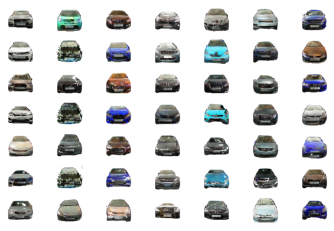

./output/Silver/1.jpg
./output/Green/1.jpg
./output/Blue/1.jpg
./output/Black/1.jpg
./output/Grey/1.jpg
./output/Beige/1.jpg
./output/Red/1.jpg
./output/White/1.jpg
./output/Purple/1.jpg
./output/Orange/1.jpg
./output/Brown/1.jpg
./output/Yellow/1.jpg
./output/Bronze/1.jpg
./output/Unlisted/1.jpg
./output/Silver/2.jpg
./output/Green/2.jpg
./output/Blue/2.jpg
./output/Black/2.jpg
./output/Grey/2.jpg
./output/Beige/2.jpg
./output/Red/2.jpg
./output/White/2.jpg
./output/Purple/2.jpg
./output/Orange/2.jpg
./output/Brown/2.jpg
./output/Yellow/2.jpg
./output/Bronze/2.jpg
./output/Unlisted/2.jpg
./output/Silver/3.jpg
./output/Green/3.jpg
./output/Blue/3.jpg
./output/Black/3.jpg
./output/Grey/3.jpg
./output/Beige/3.jpg
./output/Red/3.jpg
./output/White/3.jpg
./output/Purple/3.jpg
./output/Orange/3.jpg
./output/Brown/3.jpg
./output/Yellow/3.jpg
./output/Bronze/3.jpg
./output/Unlisted/3.jpg
./output/Silver/4.jpg
./output/Green/4.jpg
./output/Blue/4.jpg
./output/Black/4.jpg
./output/Grey/4.jpg
./

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
import cv2
import matplotlib
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=14):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
		# pyplot.imshow(cv2.cvtColor(examples[i], cv2.COLOR_BGR2RGB))
# 		fname = "id_" + str(i) + ".png"
# 		pyplot.imsave(fname, examples[i])
	pyplot.show()

def save_img(examples, n):
    for i in range(140):  # range(n*n)
        # i = int(i)
        path_Silver = "./output/Silver/"
        path_Green = "./output/Green/"
        path_Blue = "./output/Blue/"
        path_Black = "./output/Black/"
        path_Grey = "./output/Grey/"
        path_Beige = "./output/Beige/"
        path_Red = "./output/Red/"
        path_White = "./output/White/"
        path_Purple = "./output/Purple/"
        path_Orange = "./output/Orange/"
        path_Brown = "./output/Brown/"
        path_Yellow = "./output/Yellow/"
        path_Bronze = "./output/Bronze/"
        path_Unlisted = "./output/Unlisted/"
        # print(int(i))
        if int(i)%14==0:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Silver+fname)
            matplotlib.image.imsave(path_Silver+fname, examples[i])
        elif int(i)%14==1:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Green+fname)
            matplotlib.image.imsave(path_Green+fname, examples[i])
        elif int(i)%14==2:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Blue+fname)
            matplotlib.image.imsave(path_Blue+fname, examples[i])
        elif int(i)%14==3:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Black+fname)
            matplotlib.image.imsave(path_Black+fname, examples[i])
        elif int(i)%14==4:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Grey+fname)
            matplotlib.image.imsave(path_Grey+fname, examples[i])
        elif int(i)%14==5:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Beige+fname)
            matplotlib.image.imsave(path_Beige+fname, examples[i])
        elif int(i)%14==6:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Red+fname)
            matplotlib.image.imsave(path_Red+fname, examples[i])
        elif int(i)%14==7:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_White+fname)
            matplotlib.image.imsave(path_White+fname, examples[i])
        elif int(i)%14==8:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Purple+fname)
            matplotlib.image.imsave(path_Purple+fname, examples[i])
        elif int(i)%14==9:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Orange+fname)
            matplotlib.image.imsave(path_Orange+fname, examples[i])
        elif int(i)%14==10:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Brown+fname)
            matplotlib.image.imsave(path_Brown+fname, examples[i])
        elif int(i)%14==11:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Yellow+fname)
            matplotlib.image.imsave(path_Yellow+fname, examples[i])
        elif int(i)%14==12:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Bronze+fname)
            matplotlib.image.imsave(path_Bronze+fname, examples[i])
        elif int(i)%14==13:
            tmp = i / 14
            tmp = int(tmp) + 1
            fname = str(tmp) + ".jpg"
            print(path_Unlisted+fname)
            matplotlib.image.imsave(path_Unlisted+fname, examples[i])
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(140, 140)
print(labels)
# specify labels
labels = asarray([x for _ in range(10) for x in range(14)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
print(X.shape)
# plot the result
save_plot(X, 7)

save_img(X,14)